# Necessary Library 

In [2]:
# Ignore Warings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Statistical packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Text Library
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS

#ML model
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix, precision_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib

#Preprocessing
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

# Over sampling
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import NearMiss
plt.rc('figure',figsize=(8,7.5))

np.random.seed(2021)

# Import Downloded Data from Local Drive

In [3]:
df = pd.read_csv('articles_data.csv', index_col=0)
print(f"Number of rows/records: {df.shape[0]}")
print(f"Number of columns/variables: {df.shape[1]}")


Number of rows/records: 10437
Number of columns/variables: 14


# Missing Values Counts 

In [4]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])


In [5]:
# Drop All rows containg null values
df_cleaned = df.dropna()

# Check whther all null values are droped or not 
NA = pd.DataFrame(data=[df_cleaned.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df_cleaned.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])

# Top Ten Author and Source Name

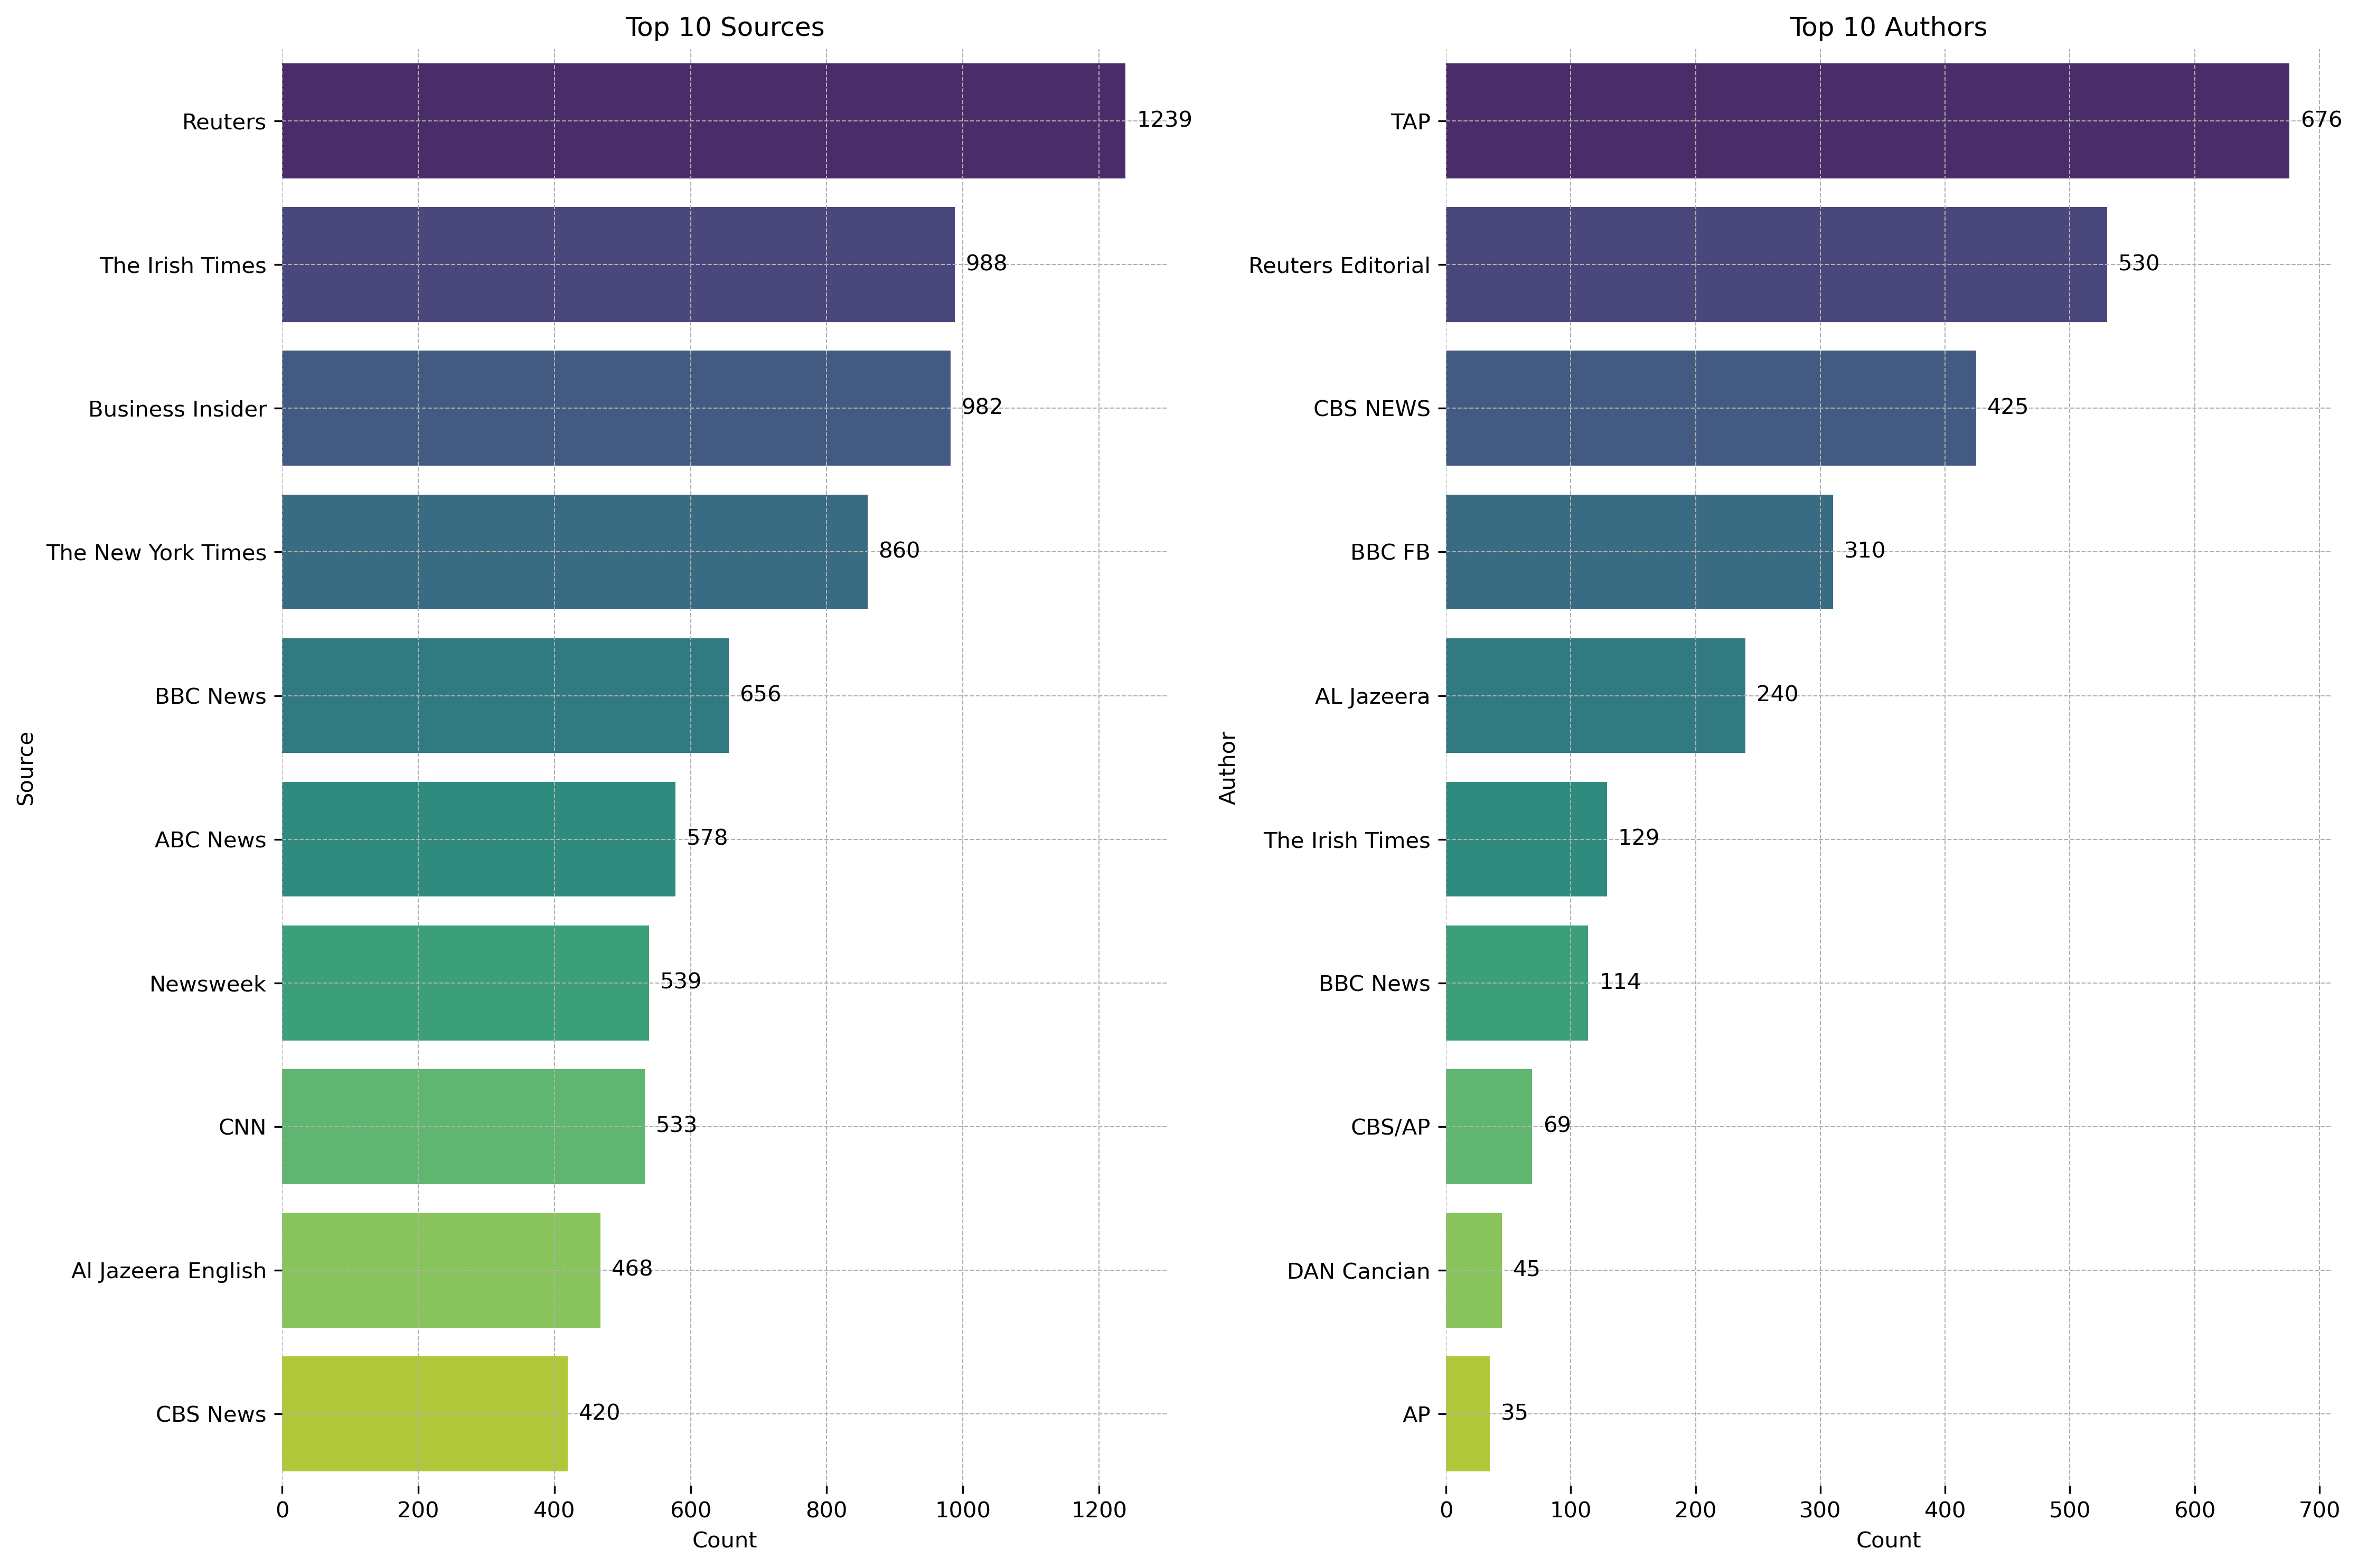

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10),dpi=300)

# Data
source_name = df_cleaned["source_name"].dropna().value_counts()[:10]
author = df_cleaned["author"].value_counts()[:10]

# Custom yticklabels
yticklabels = ['TAP', 'Reuters Editorial', 'CBS NEWS', 'BBC FB', 'AL Jazeera', 
               'The Irish Times', 'BBC News', 'CBS/AP', 'DAN Cancian', 'AP']

# Plotting
sns.barplot(x=source_name, y=source_name.index, palette='viridis', ax=ax1)
sns.barplot(x=author, y=author.index, palette='viridis', ax=ax2)

# Despine for cleaner look
sns.despine(bottom=True, left=True)

# Titles and labels
ax1.set(title='Top 10 Sources', xlabel='Count', ylabel='Source')
ax2.set(title='Top 10 Authors', xlabel='Count', ylabel='Author')
ax2.set_yticklabels(yticklabels);

# Optional: Add data labels
for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(f"{int(p.get_width())}", (p.get_width(), p.get_y() + p.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', ha='left', va='center')


# Add gridlines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Top Ten Author and Article Publication Date

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/815280733.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['published_at'] = pd.to_datetime(df_cleaned['published_at'], errors='coerce', infer_datetime_format=True)


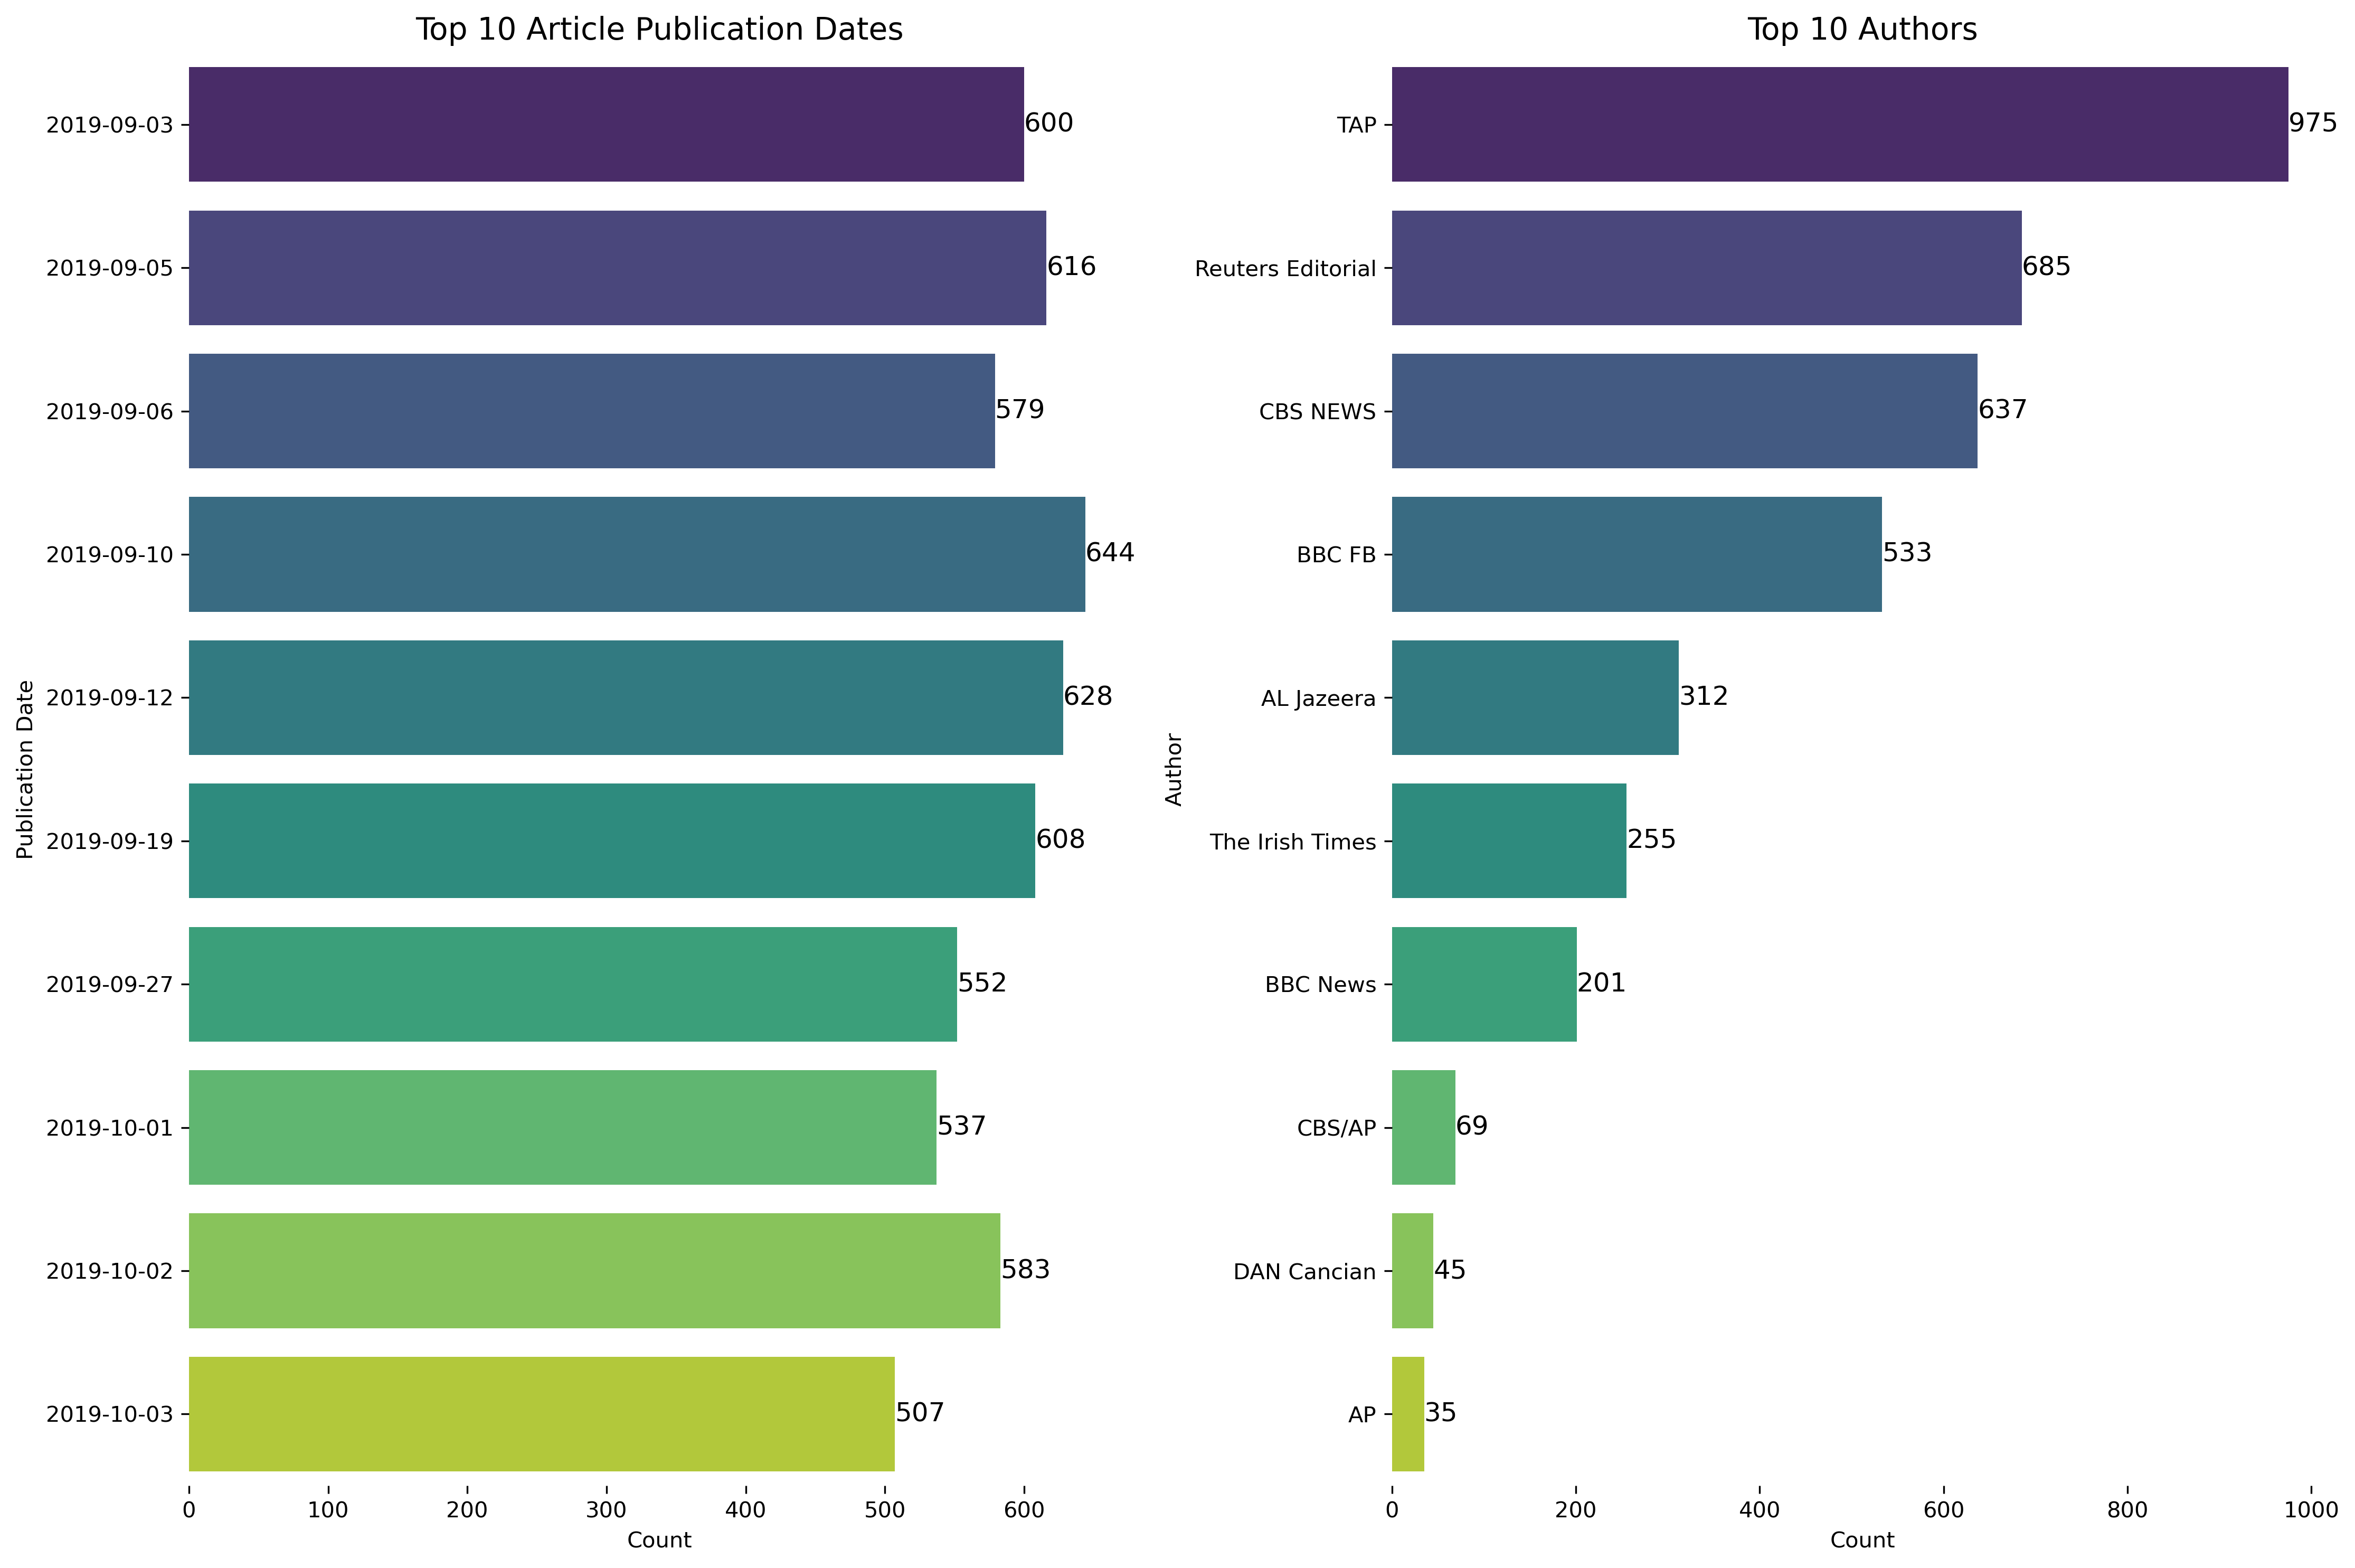

In [7]:
# Assuming df_cleaned['published_at'] is in a suitable date format. If not, convert it:
df['published_at'] = pd.to_datetime(df_cleaned['published_at'], errors='coerce', infer_datetime_format=True)

# Data preparation
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), dpi=300)
source_name = df['published_at'].dt.date.value_counts().nlargest(10).sort_index()
author = df["author"].dropna().value_counts()[:10]

# Custom yticklabels for authors
yticklabels = ['TAP', 'Reuters Editorial', 'CBS NEWS', 'BBC FB', 'AL Jazeera',
               'The Irish Times', 'BBC News', 'CBS/AP', 'DAN Cancian', 'AP']

# Plotting
sns.barplot(x=source_name.values, y=source_name.index.astype(str), palette='viridis', ax=ax1)
sns.barplot(x=author, y=author.index, palette='viridis', ax=ax2)

# Add counts besides the bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=12, color='black')

for p in ax2.patches:
    ax2.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', fontsize=12, color='black')

# Styling
sns.despine(bottom=True, left=True)
ax1.set_title('Top 10 Article Publication Dates', fontsize=14)
ax1.set_xlabel('Count')
ax1.set_ylabel('Publication Date')
ax2.set_title('Top 10 Authors', fontsize=14)
ax2.set_xlabel('Count')
ax2.set_ylabel('Author')
ax2.set_yticklabels(yticklabels)

plt.tight_layout()
plt.show()


In [8]:
df_cleaned.columns

Index(['source_id', 'source_name', 'author', 'title', 'description', 'url',
       'url_to_image', 'published_at', 'content', 'top_article',
       'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count'],
      dtype='object')

# Top Ten Author and engagement_share_count

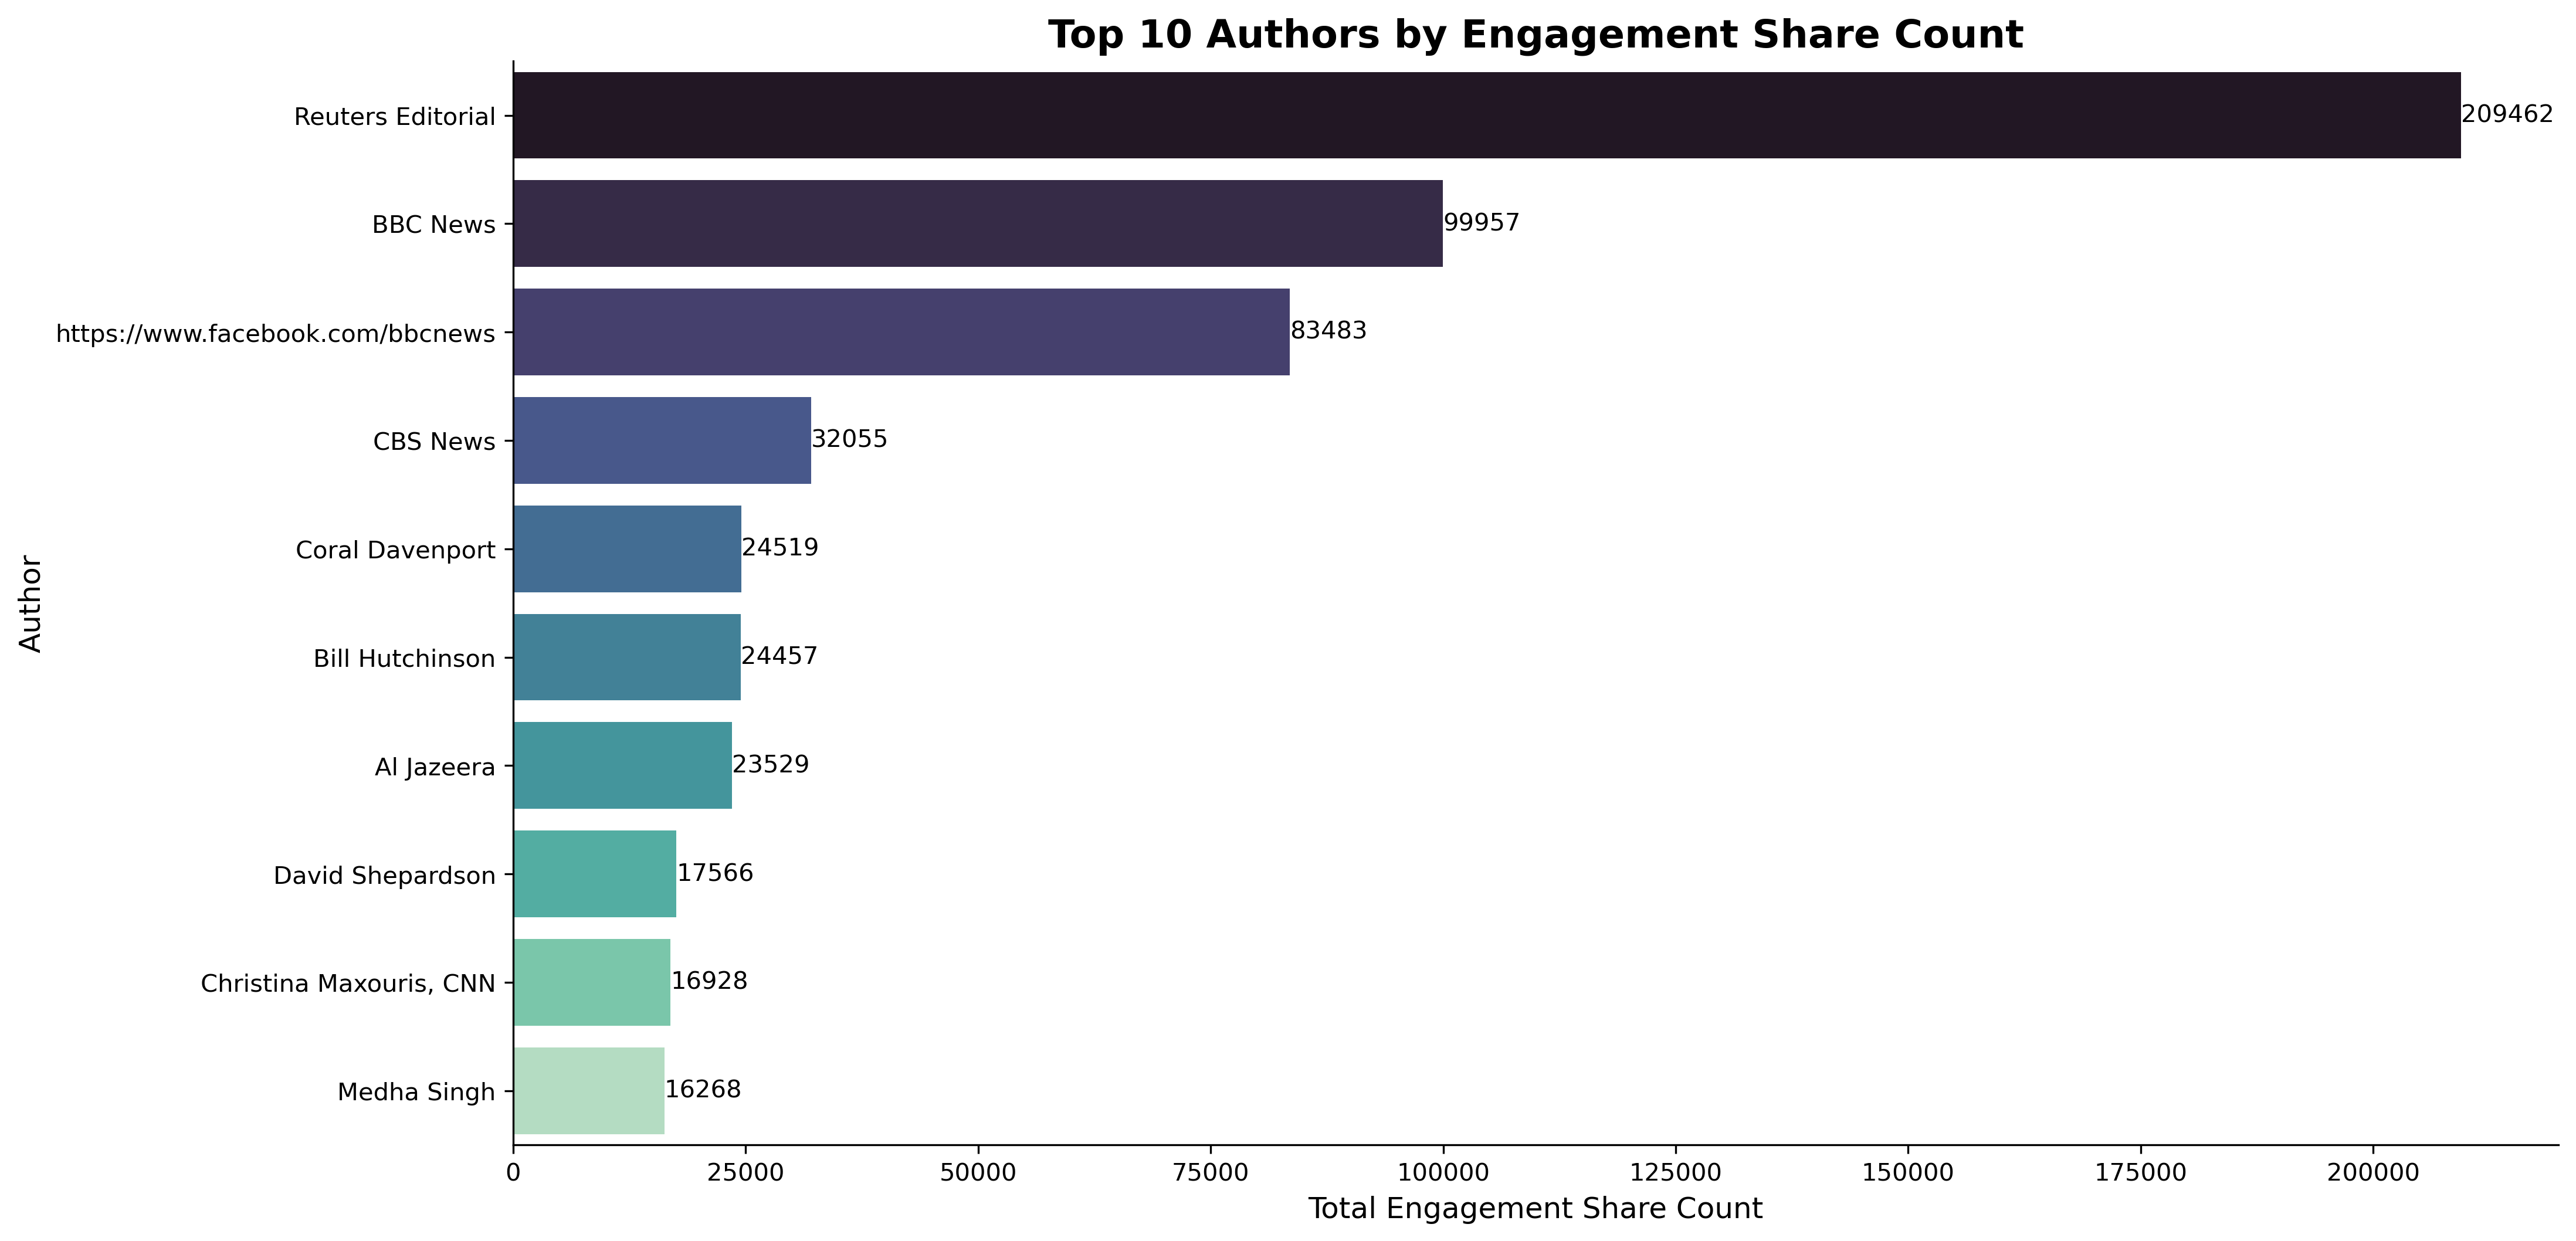

In [9]:

# Aggregate data
author_engagement = df_cleaned.groupby('author')['engagement_share_count'].sum().reset_index()

# Sort and select top ten authors
top_authors = author_engagement.sort_values(by='engagement_share_count', ascending=False).head(10)

# Plotting
plt.figure(figsize=(15, 8),dpi=300)
barplot = sns.barplot(x='engagement_share_count', y='author', data=top_authors, palette='mako')

# Add data labels
for p in barplot.patches:
    width = p.get_width()  # get bar length
    barplot.text(width + 3,  # set the text at 1 unit right of the bar
                 p.get_y() + p.get_height() / 2,  # get Y coordinate + half of the bar height
                 '{:1.0f}'.format(width),  # value to be displayed
                 ha = 'left',   # horizontal alignment
                 va = 'center')  # vertical alignment

# Styling
plt.title('Top 10 Authors by Engagement Share Count', fontsize=16, fontweight='bold')
plt.xlabel('Total Engagement Share Count', fontsize=12)
plt.ylabel('Author', fontsize=12)
sns.despine()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

# Top Ten Author and engagement_reaction_count

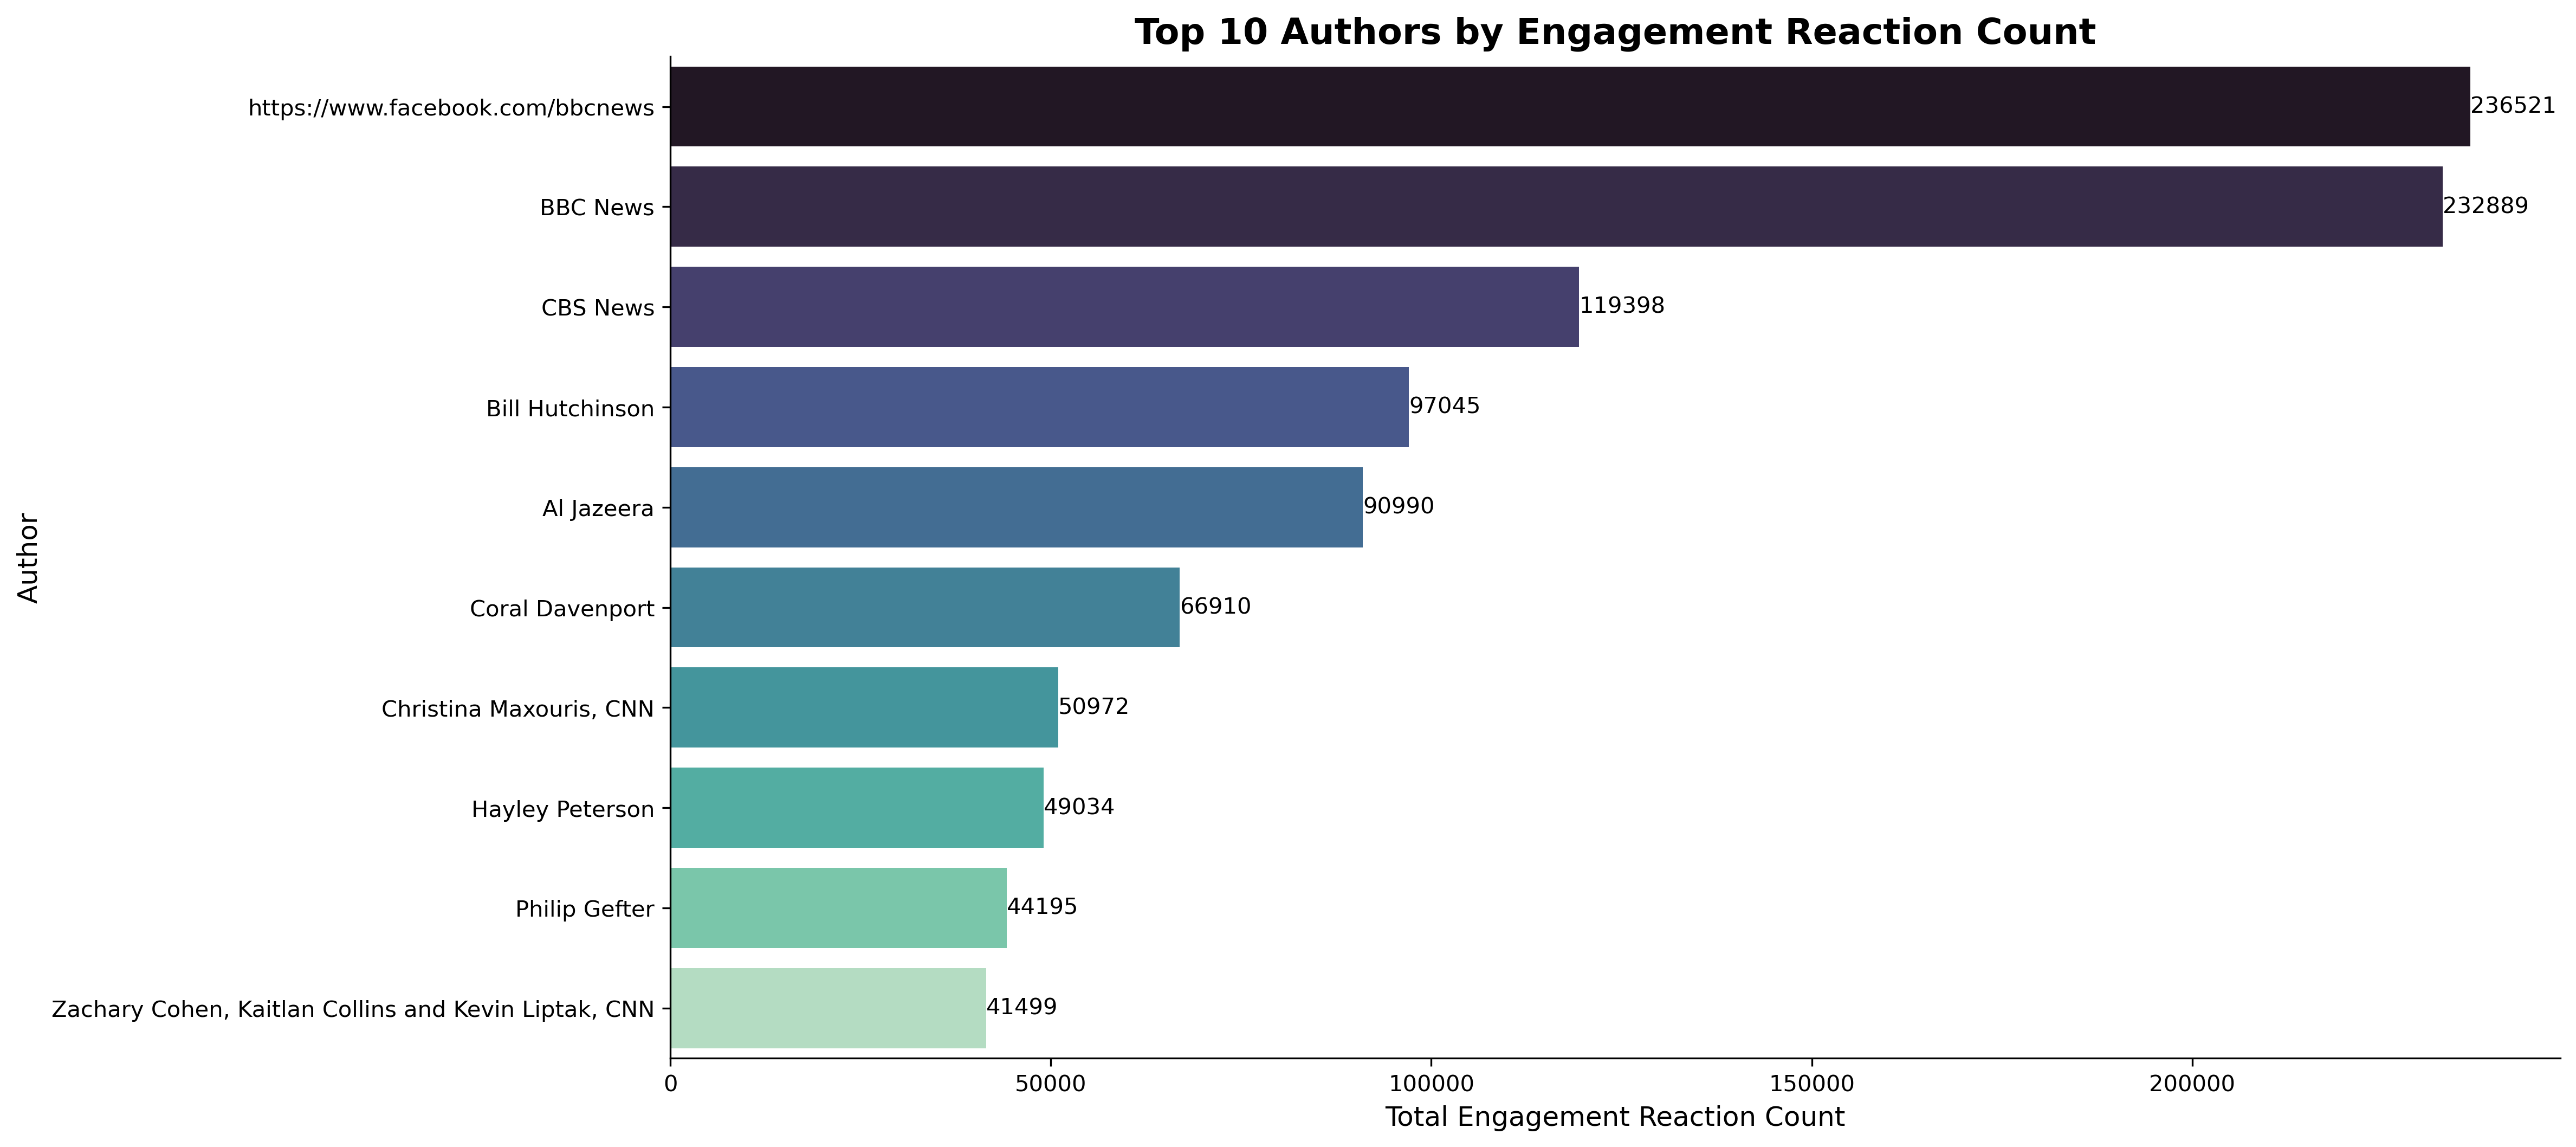

In [10]:
df.columns

# Aggregate data
author_engagement = df_cleaned.groupby('author')['engagement_reaction_count'].sum().reset_index()

# Sort and select top ten authors
top_authors = author_engagement.sort_values(by='engagement_reaction_count', ascending=False).head(10)

# Plotting
plt.figure(figsize=(15, 8),dpi=300)
barplot = sns.barplot(x='engagement_reaction_count', y='author', data=top_authors, palette='mako')

# Add data labels
for p in barplot.patches:
    width = p.get_width()  # get bar length
    barplot.text(width + 3,  # set the text at 1 unit right of the bar
                 p.get_y() + p.get_height() / 2,  # get Y coordinate + half of the bar height
                 '{:1.0f}'.format(width),  # value to be displayed
                 ha = 'left',   # horizontal alignment
                 va = 'center')  # vertical alignment

# Styling
plt.title('Top 10 Authors by Engagement Reaction Count', fontsize=16, fontweight='bold')
plt.xlabel('Total Engagement Reaction Count', fontsize=12)
plt.ylabel('Author', fontsize=12)
sns.despine()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

# Top Ten Author and engagement_comment_count

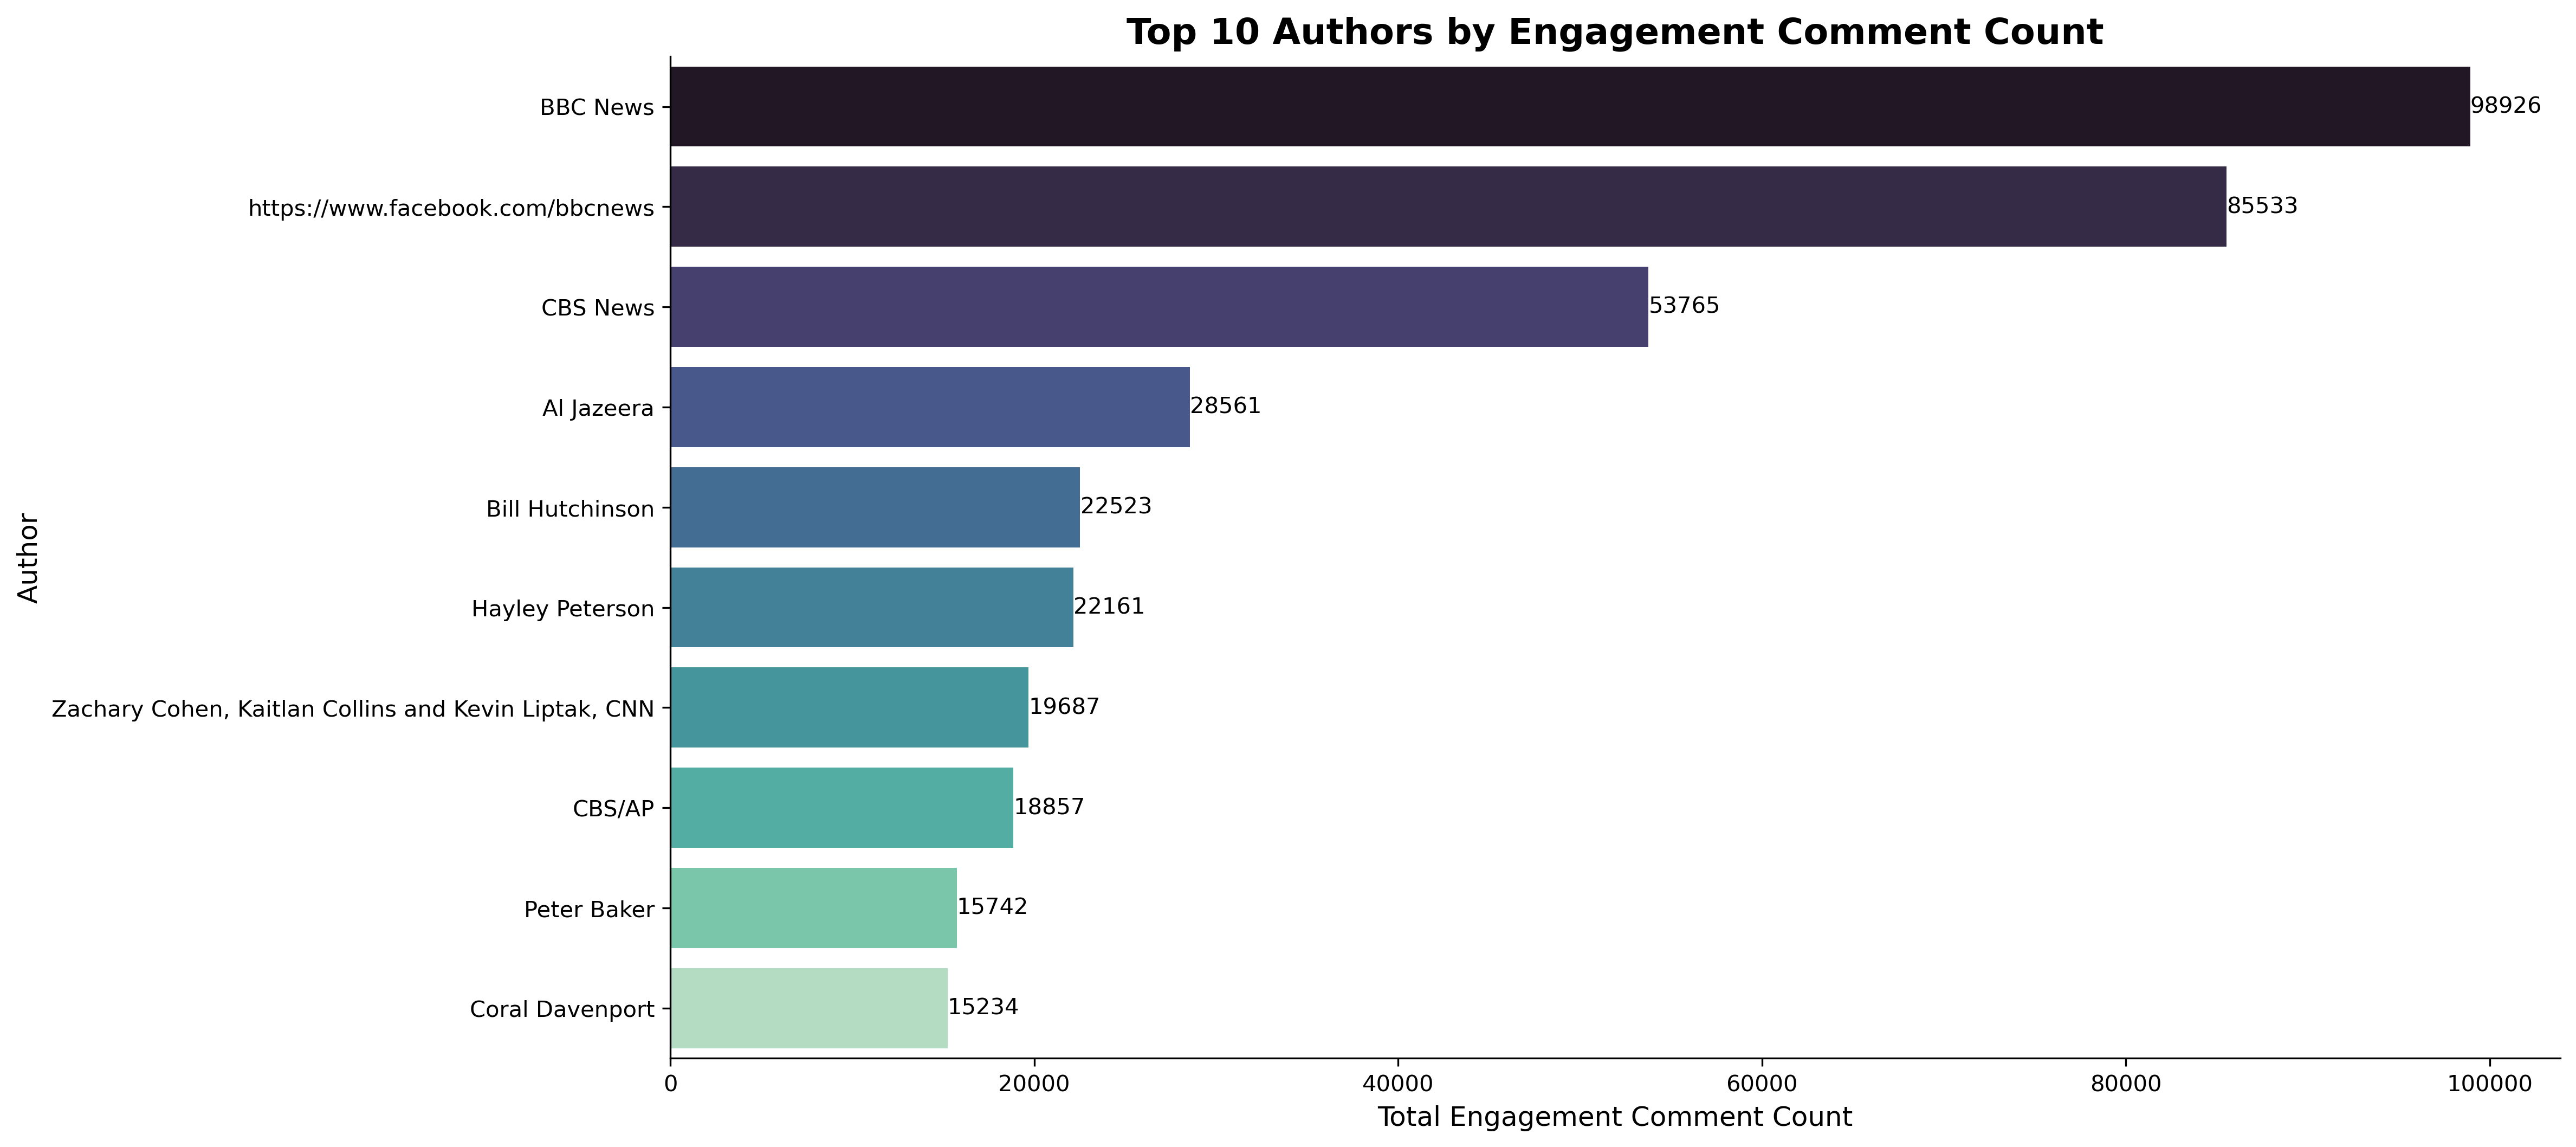

In [11]:
df.columns

# Aggregate data
author_engagement = df_cleaned.groupby('author')['engagement_comment_count'].sum().reset_index()

# Sort and select top ten authors
top_authors = author_engagement.sort_values(by='engagement_comment_count', ascending=False).head(10)

# Plotting
plt.figure(figsize=(15, 8), dpi=300)
barplot = sns.barplot(x='engagement_comment_count', y='author', data=top_authors, palette='mako')

# Add data labels
for p in barplot.patches:
    width = p.get_width()  # get bar length
    barplot.text(width + 3,  # set the text at 1 unit right of the bar
                 p.get_y() + p.get_height() / 2,  # get Y coordinate + half of the bar height
                 '{:1.0f}'.format(width),  # value to be displayed
                 ha = 'left',   # horizontal alignment
                 va = 'center')  # vertical alignment

# Styling
plt.title('Top 10 Authors by Engagement Comment Count', fontsize=16, fontweight='bold')
plt.xlabel('Total Engagement Comment Count', fontsize=12)
plt.ylabel('Author', fontsize=12)
sns.despine()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

# Top Ten Author and Total Engagement

It sums up the comment count, reaction count, and share count to get a total engagement score for each author.

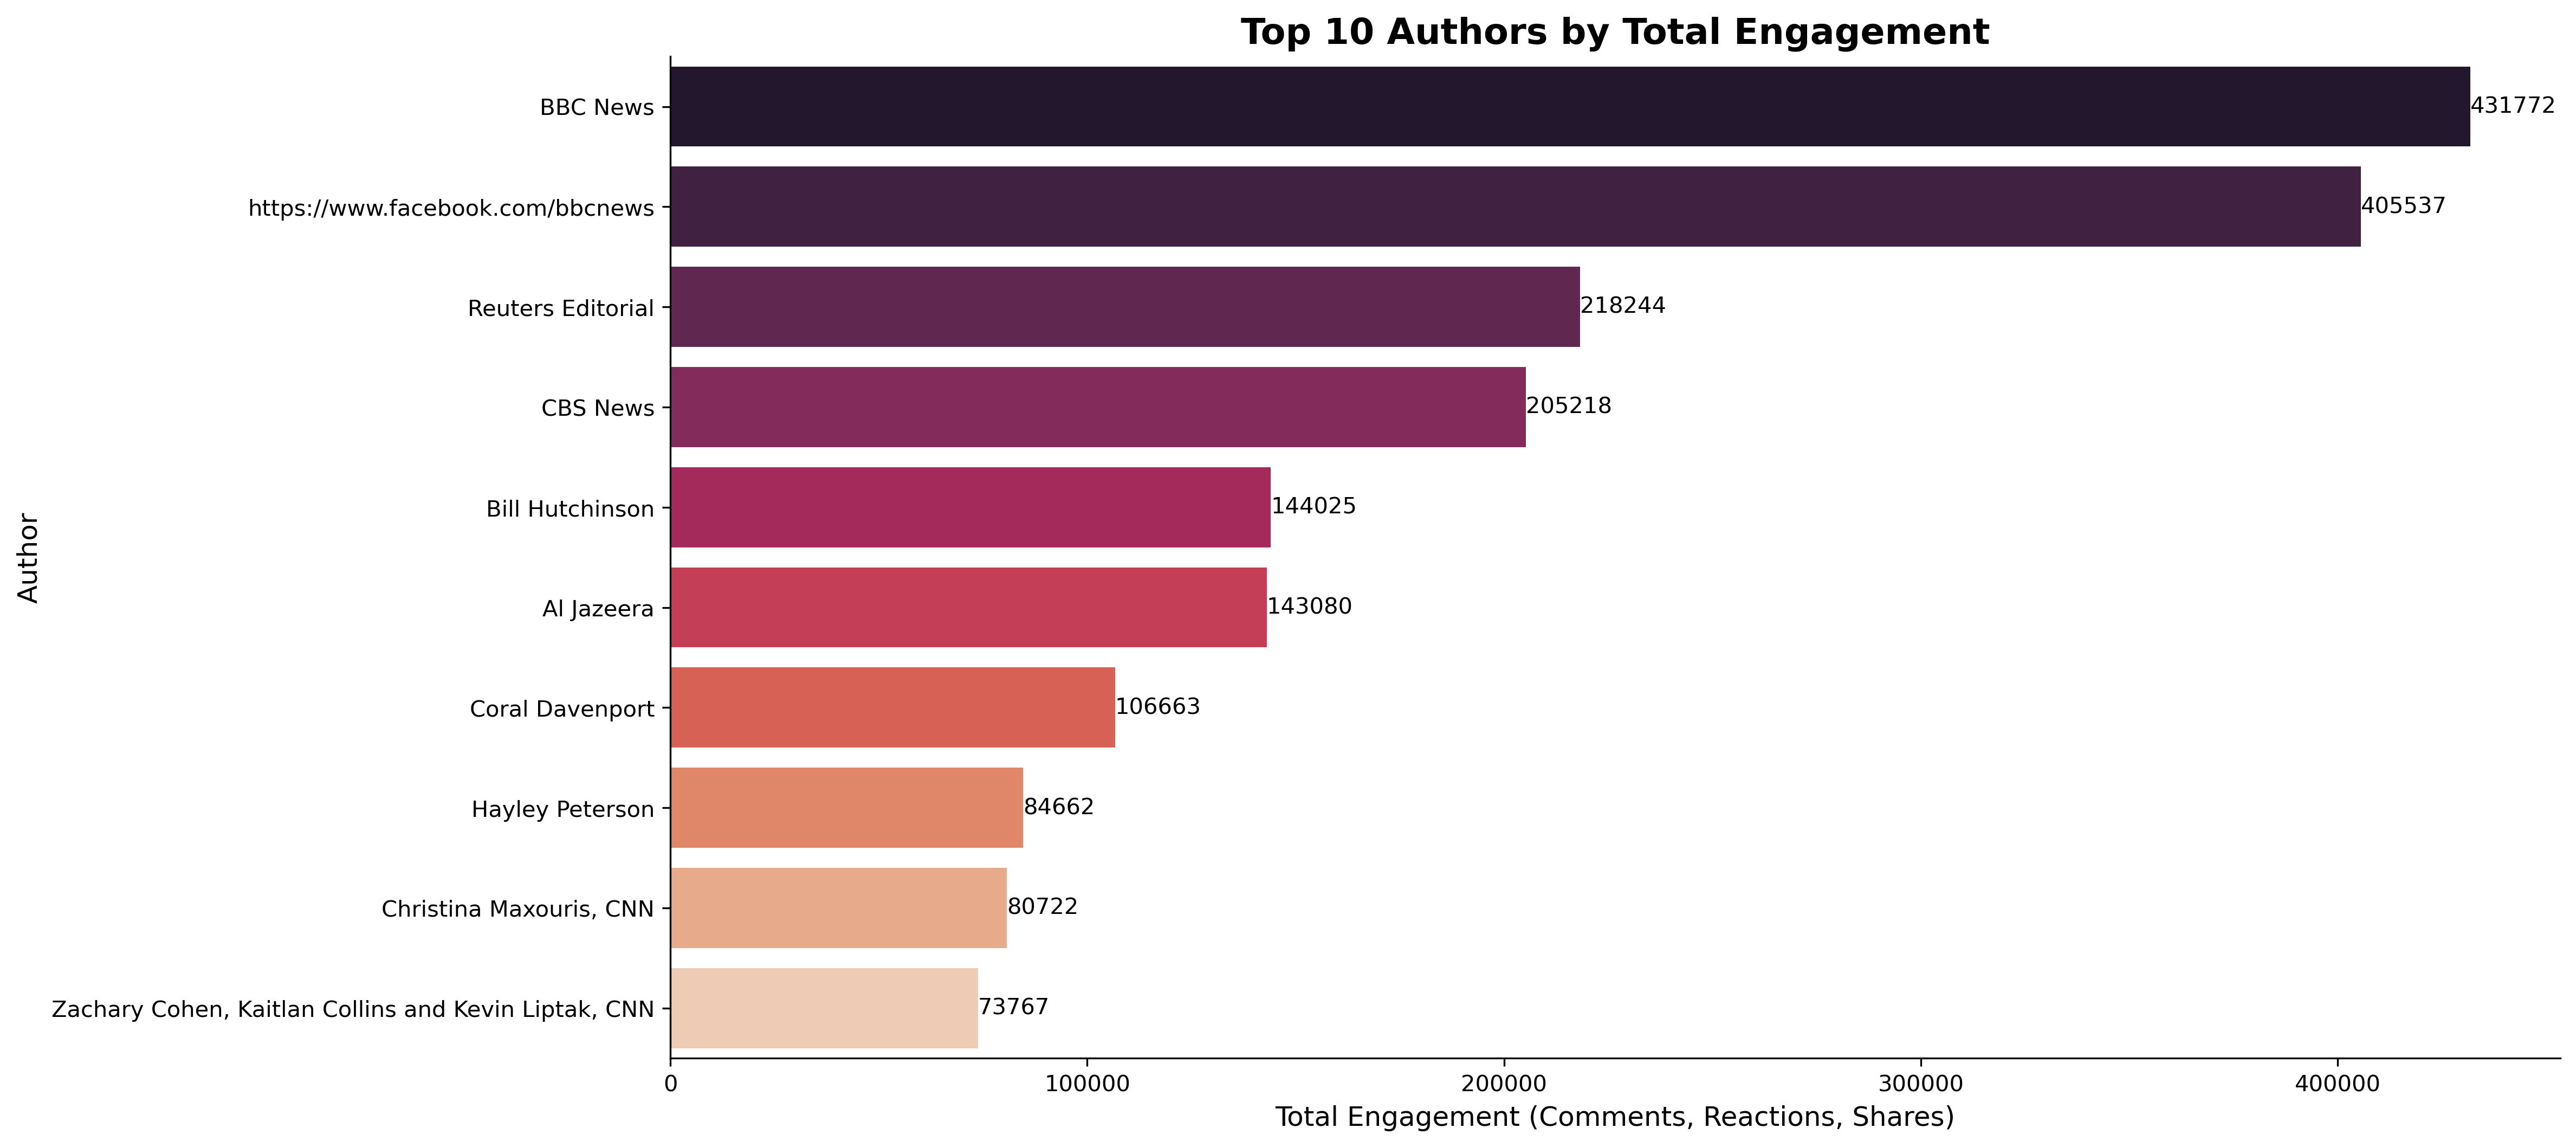

In [12]:
# Aggregate all types of engagements
df['total_engagement'] = df_cleaned[['engagement_comment_count', 
                                             'engagement_reaction_count', 
                                             'engagement_share_count']].sum(axis=1)

# Group by author and sum total engagements
author_total_engagement = df.groupby('author')['total_engagement'].sum().reset_index()

# Sort and select top ten authors
top_authors_total = author_total_engagement.sort_values(by='total_engagement', ascending=False).head(10)

# Plotting
plt.figure(figsize=(15, 8),dpi=300)
barplot_total = sns.barplot(x='total_engagement', y='author', data=top_authors_total, palette='rocket')

# Add data labels
for p in barplot_total.patches:
    width = p.get_width()  # get bar length
    barplot_total.text(width + 3,  # set the text at 1 unit right of the bar
                       p.get_y() + p.get_height() / 2,  # get Y coordinate + half of the bar height
                       '{:1.0f}'.format(width),  # value to be displayed
                       ha = 'left',   # horizontal alignment
                       va = 'center')  # vertical alignment

# Styling
plt.title('Top 10 Authors by Total Engagement', fontsize=16, fontweight='bold')
plt.xlabel('Total Engagement (Comments, Reactions, Shares)', fontsize=12)
plt.ylabel('Author', fontsize=12)
sns.despine()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()


# Top Article in PieChart

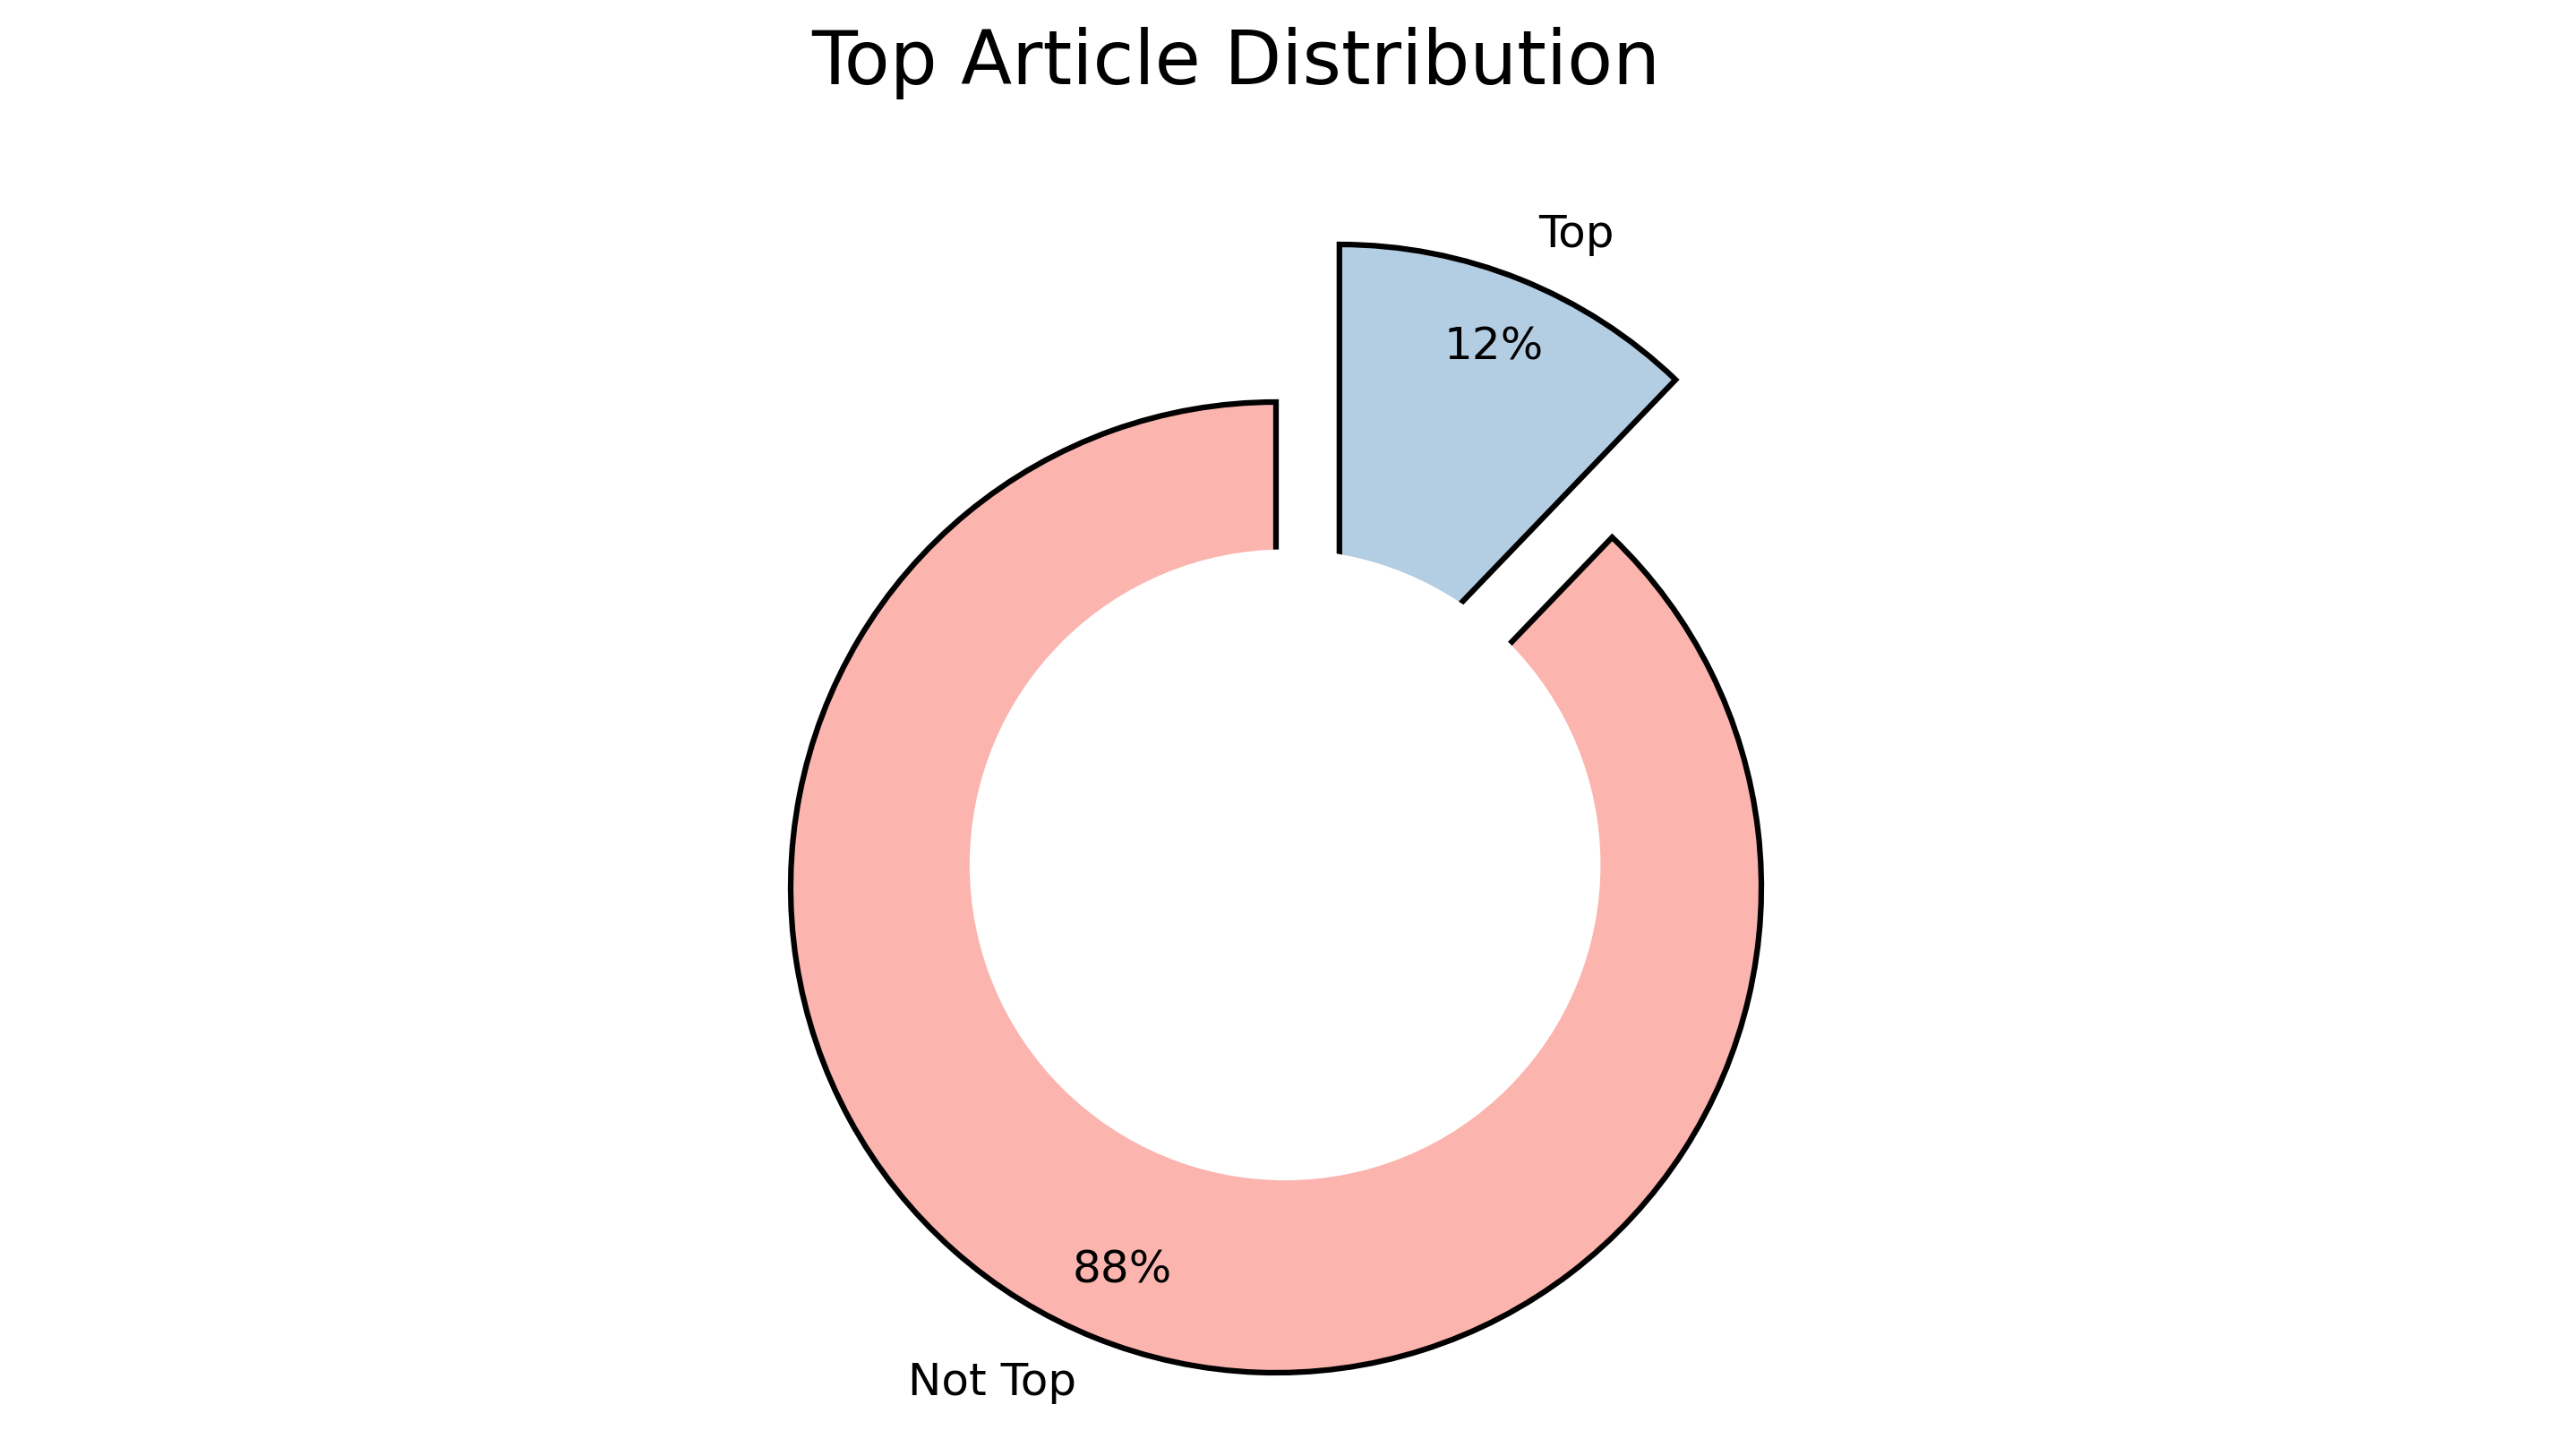

In [13]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

explode = (0.05, 0.3)
labels = ["Not Top", "Top"]
sizes = df_cleaned["top_article"].value_counts()

colors = sns.color_palette("Pastel1")

ax.pie(sizes,
       explode=explode,
       labels=labels,
       colors=colors,
       startangle=90,
       autopct='%1.0f%%',
       pctdistance=0.85,
       wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
       textprops={'fontsize': 12, 'color': 'black'}
       )

center_circle = plt.Circle((0, 0), 0.65, fc='white')
ax.add_artist(center_circle)

fig.suptitle('Top Article Distribution', size=20, color="black")

ax.axis('equal')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('top_article_pie_chart.png', bbox_inches='tight', dpi=300)

plt.show()


In [14]:
counts = df_cleaned['top_article'].value_counts()
print(counts)

top_article
0.0    6678
1.0     926
Name: count, dtype: int64


In [15]:

df['published_at'] = pd.to_datetime(df['published_at'], format="%Y-%m-%dT%H:%M:%S%z", errors='coerce')

df['Day_Of_Week'] = df['published_at'].apply(lambda x: x.dayofweek)
df['Month'] = df['published_at'].apply(lambda x: x.month)
df['Year'] = df['published_at'].apply(lambda x: x.year)


# Number of Engagement over Month

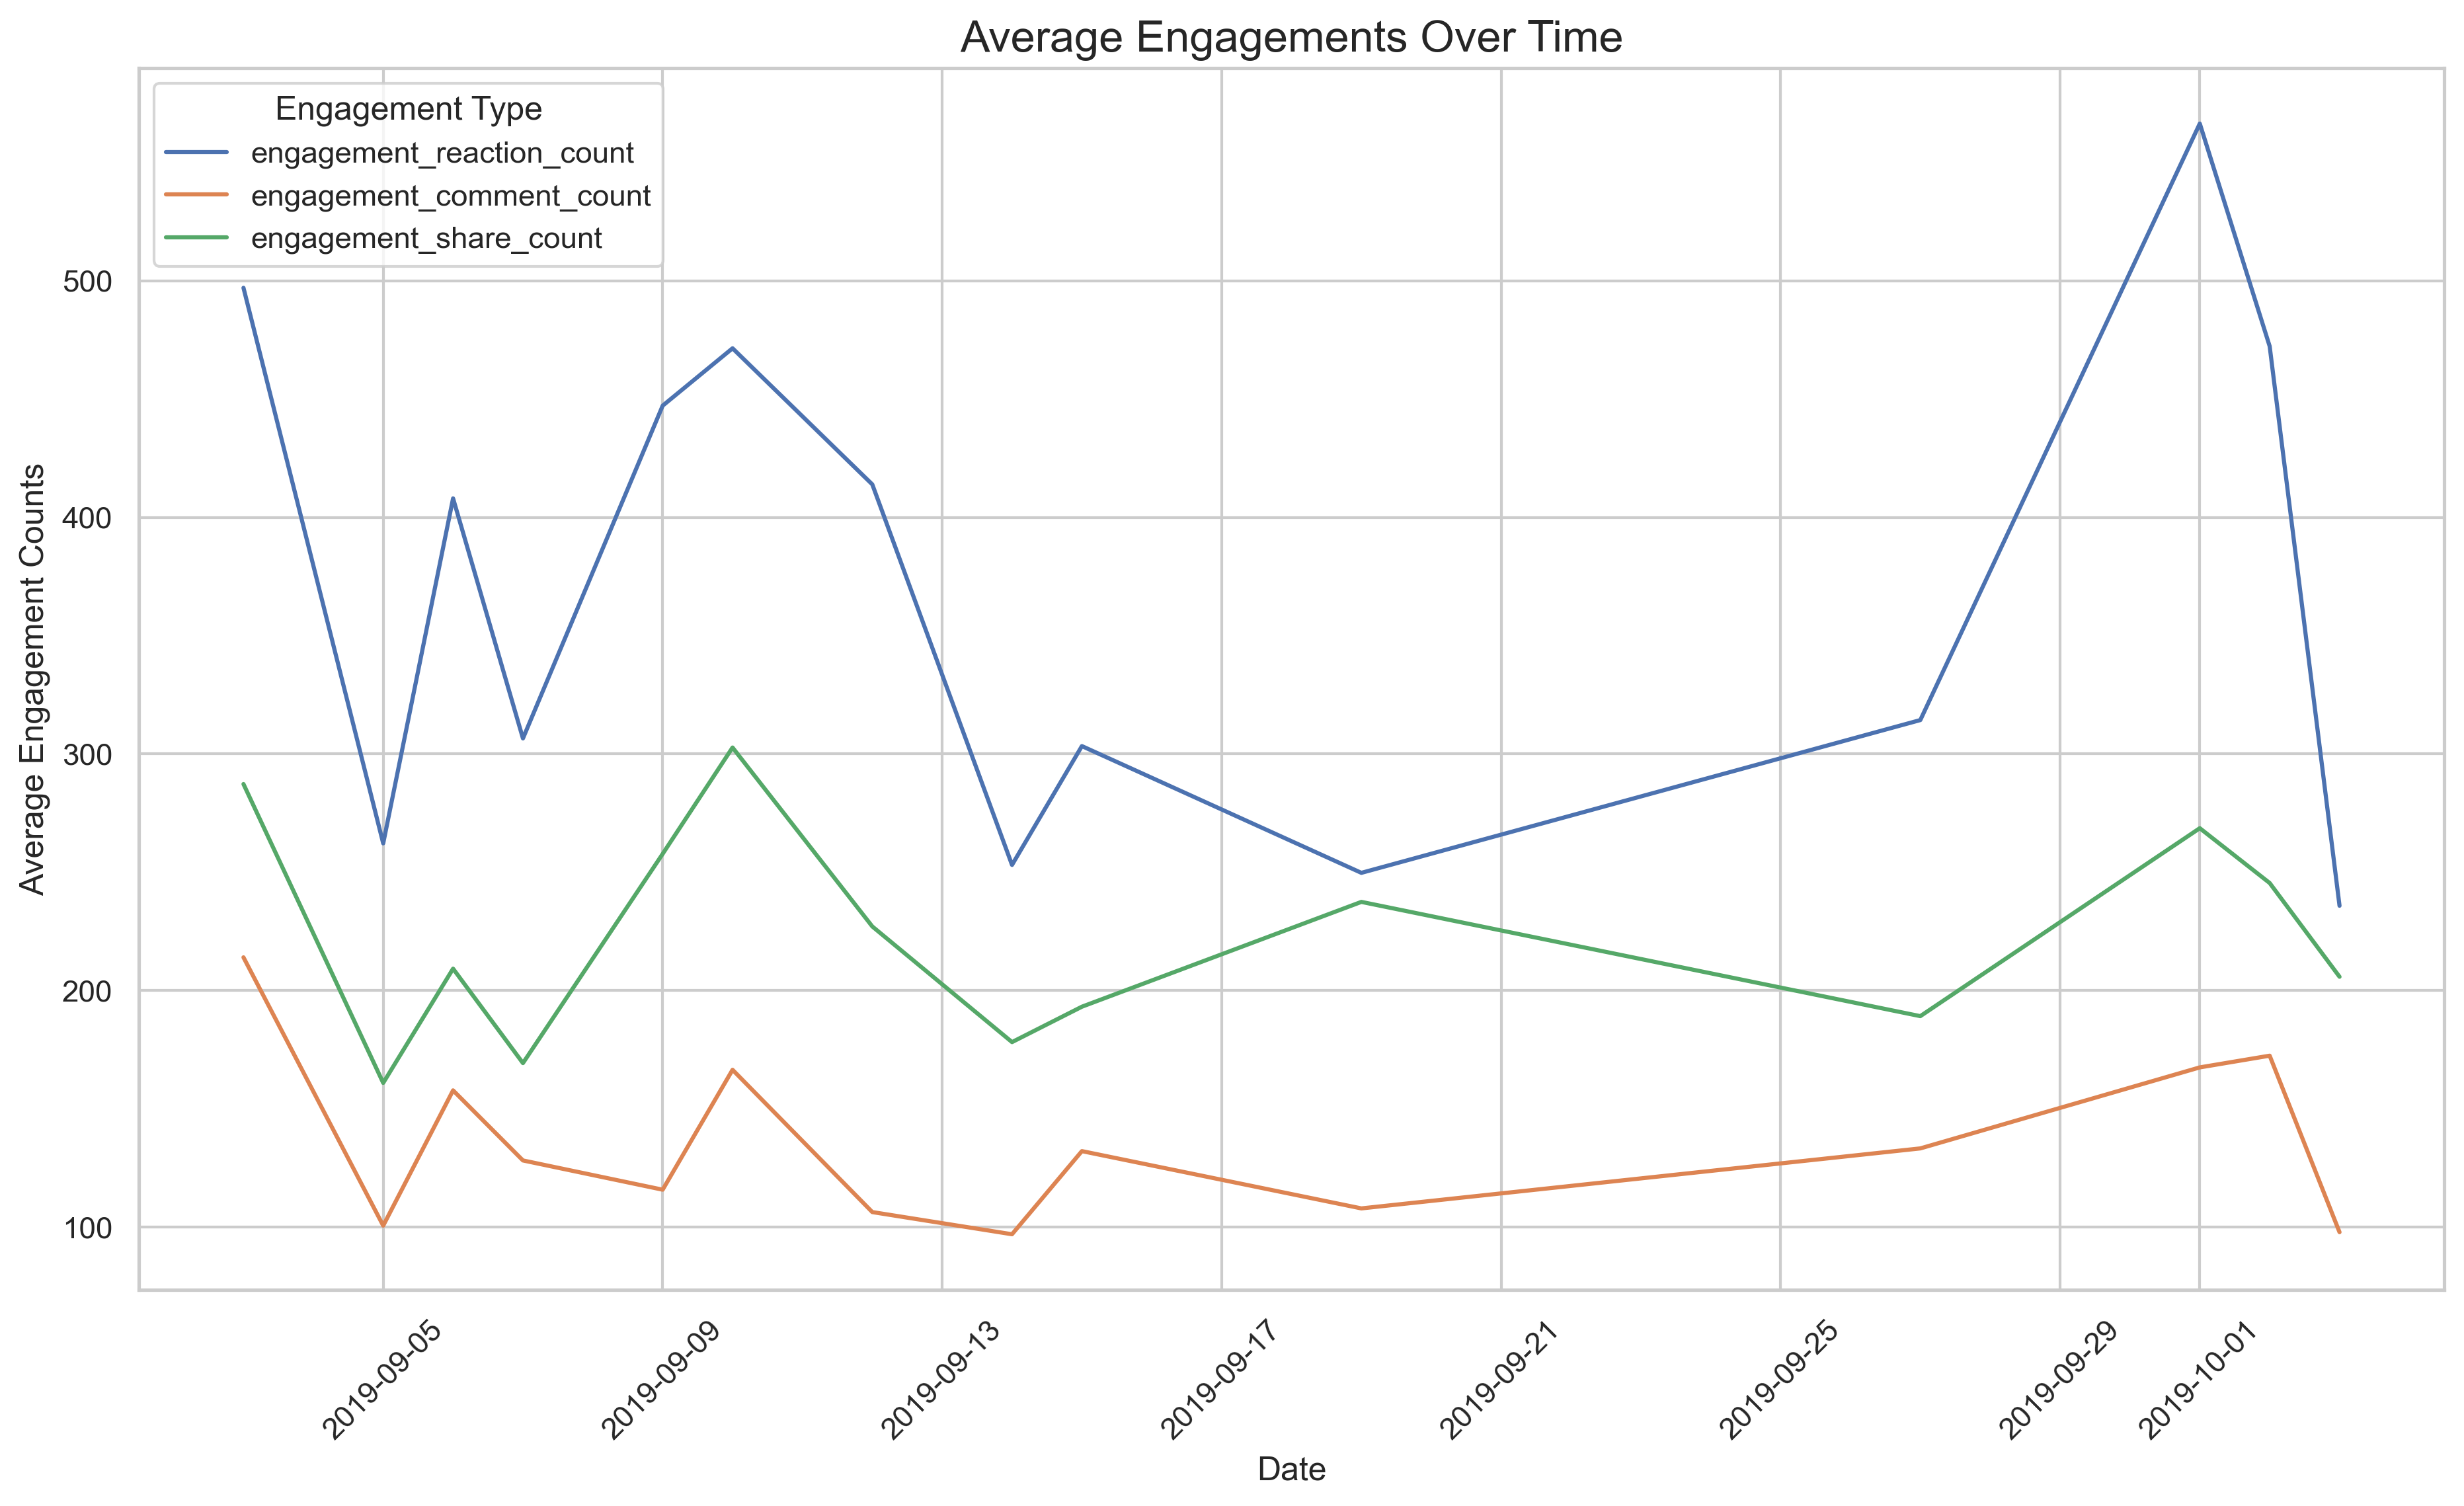

In [16]:
# Assuming df is your DataFrame
# Convert 'published_at' to datetime and normalize
df['published_at'] = pd.to_datetime(df['published_at']).dt.normalize()

# Select only numeric columns and exclude 'engagement_comment_plugin_count'
numeric_columns = df.select_dtypes(include='number').columns
numeric_columns = [col for col in numeric_columns if col != 'engagement_comment_plugin_count']
numeric_df = df[['published_at'] + list(numeric_columns)]

# Group by 'published_at' and calculate mean for numeric columns only
date_mean = numeric_df.groupby(by='published_at').mean().reset_index()

# Create the plot
plt.figure(figsize=[15, 8], dpi=300)
sns.set(style="whitegrid")

# Add lines for each numeric engagement type column
for col in numeric_columns:
    if col.startswith('engagement_'):
        sns.lineplot(data=date_mean, x="published_at", y=col, label=col)

# Customizing the axes and labels
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Engagement Counts', fontsize=12)
plt.title('Average Engagements Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Engagement Type')

# Show the plot
plt.show()


# Coorelation Heatmap

## Correlation of Engagement Metrics
This heatmap will display the correlation between different engagement metrics, such as reaction count, comment count, share count, and plugin comment count

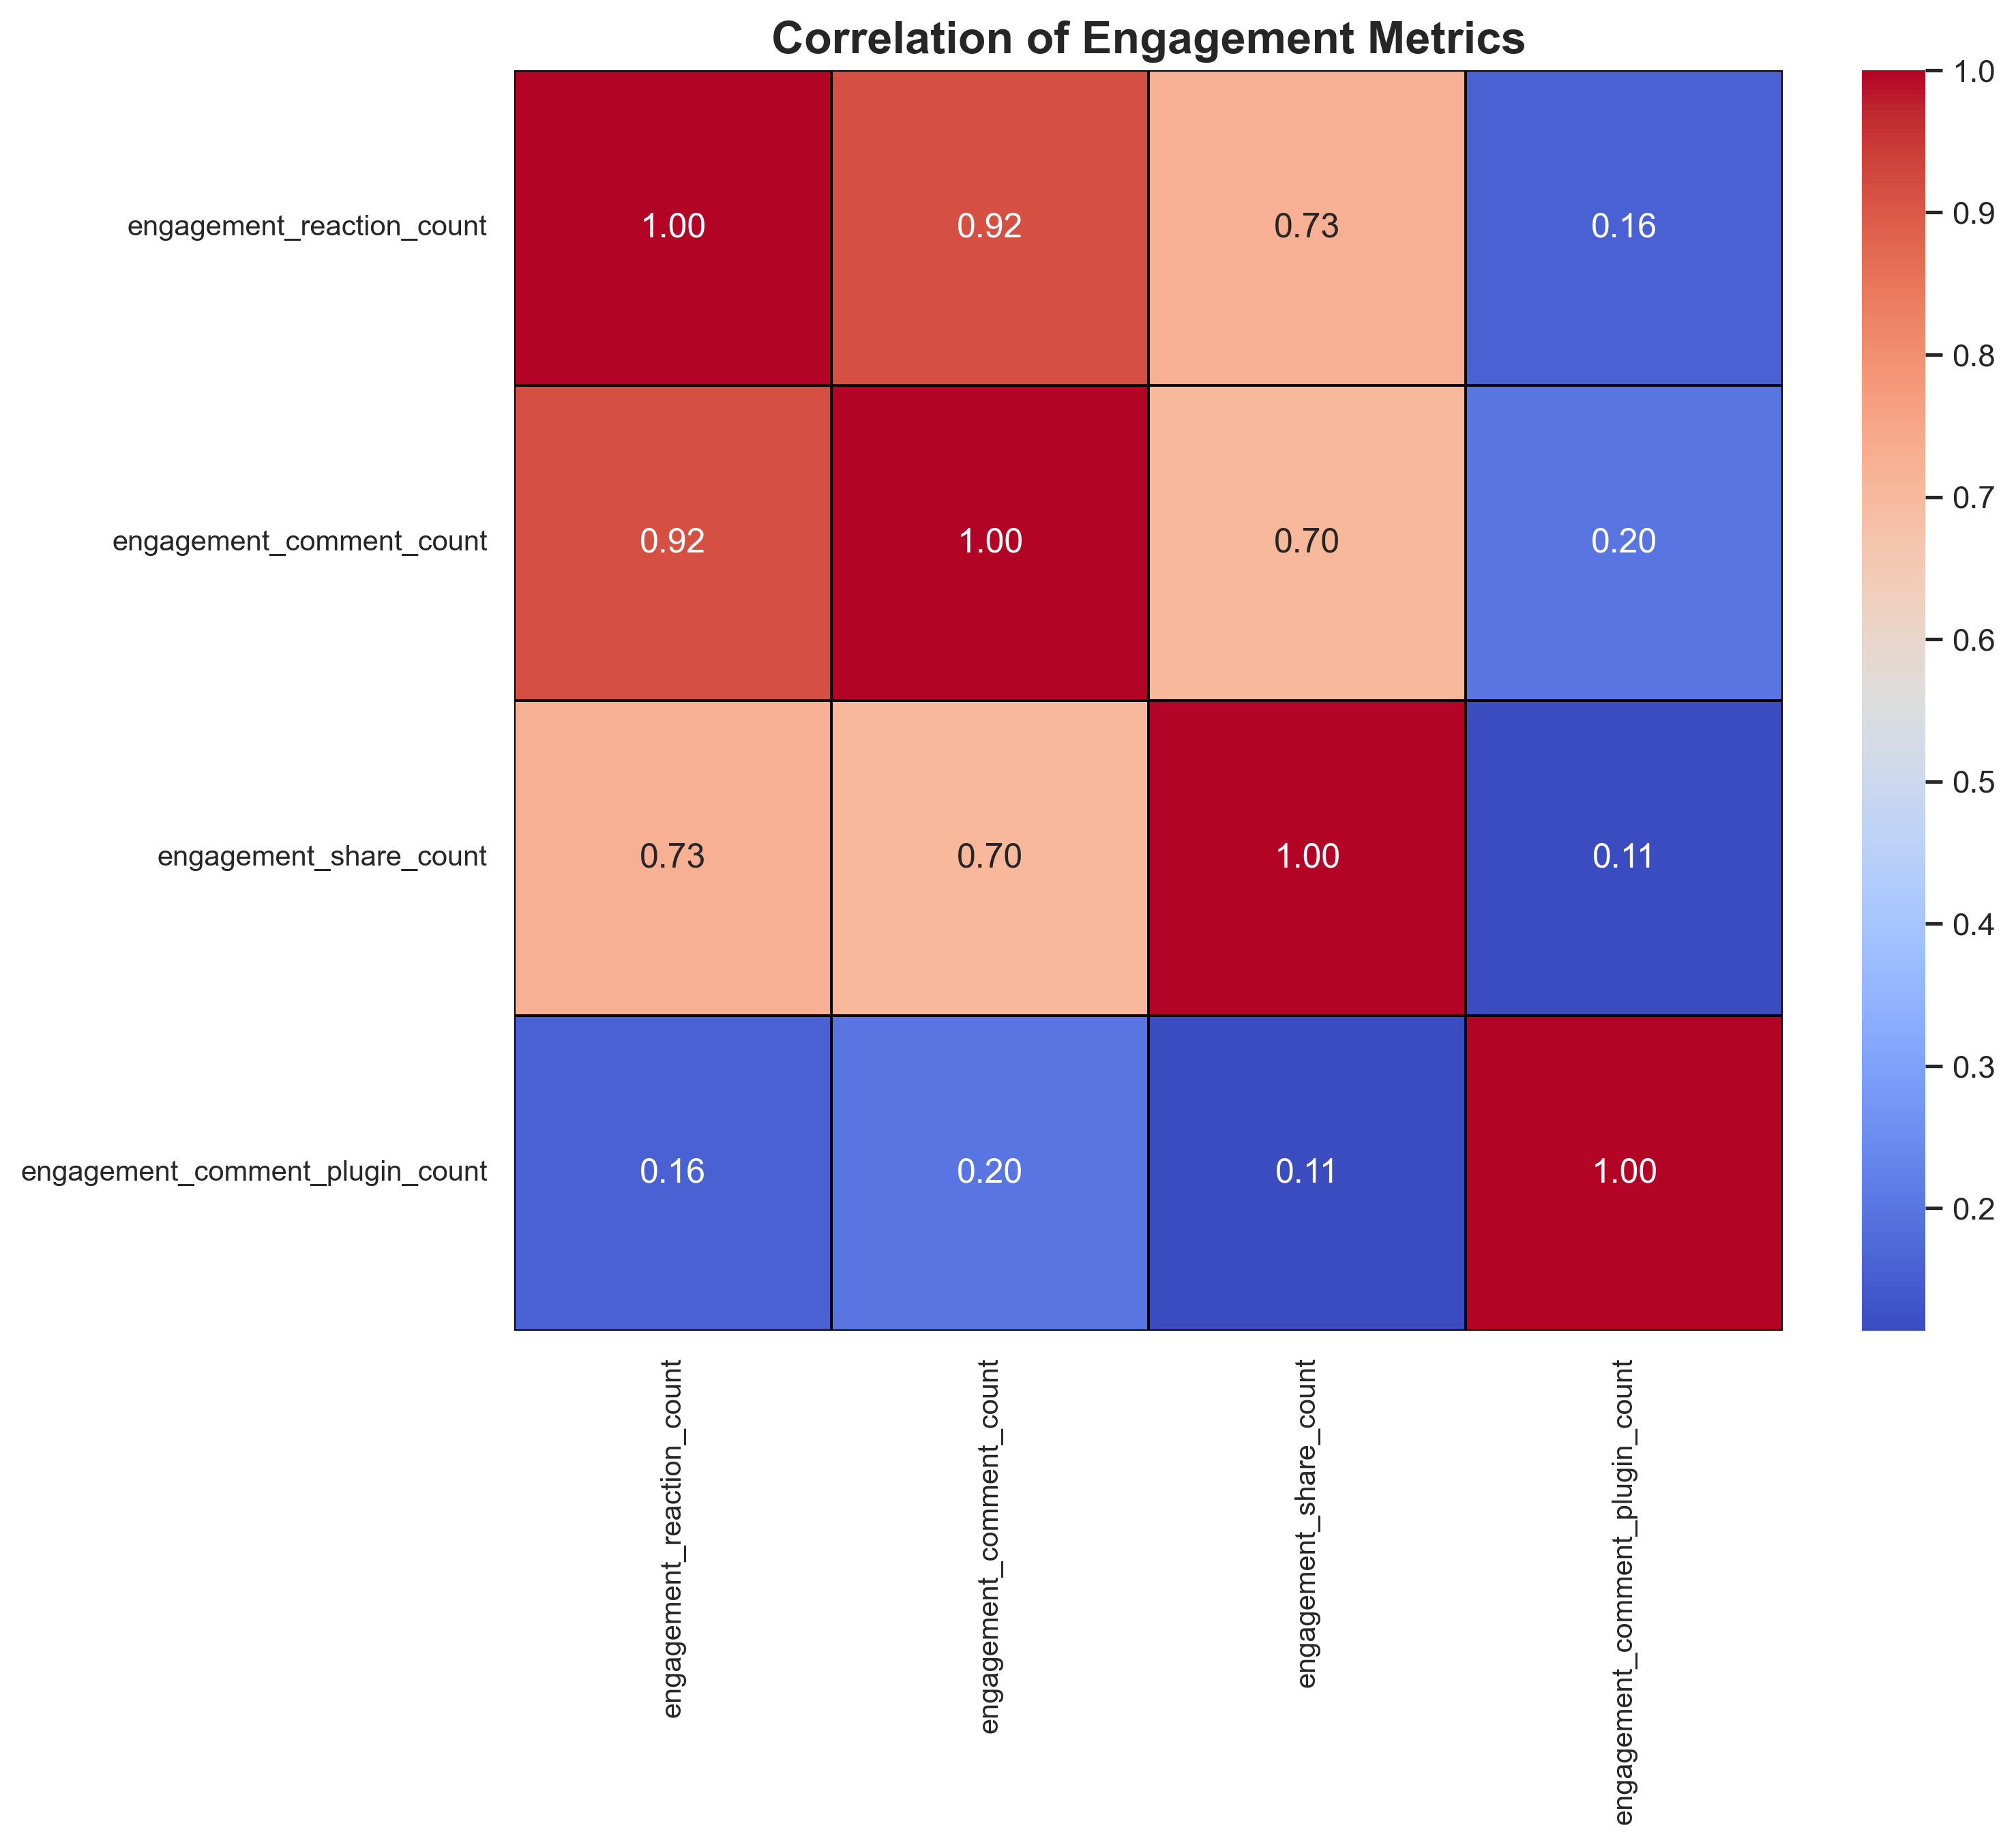

In [17]:
# Select only engagement columns
engagement_columns = ['engagement_reaction_count', 'engagement_comment_count', 
                      'engagement_share_count', 'engagement_comment_plugin_count']
engagement_df = df_cleaned[engagement_columns]

# Calculate the correlation matrix
corr_matrix_engagement = engagement_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(corr_matrix_engagement, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation of Engagement Metrics', fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


## Correlation of Engagement Metrics with Top Article Flag
This heatmap explores how the engagement metrics correlate with whether an article is marked as a 'top article'.

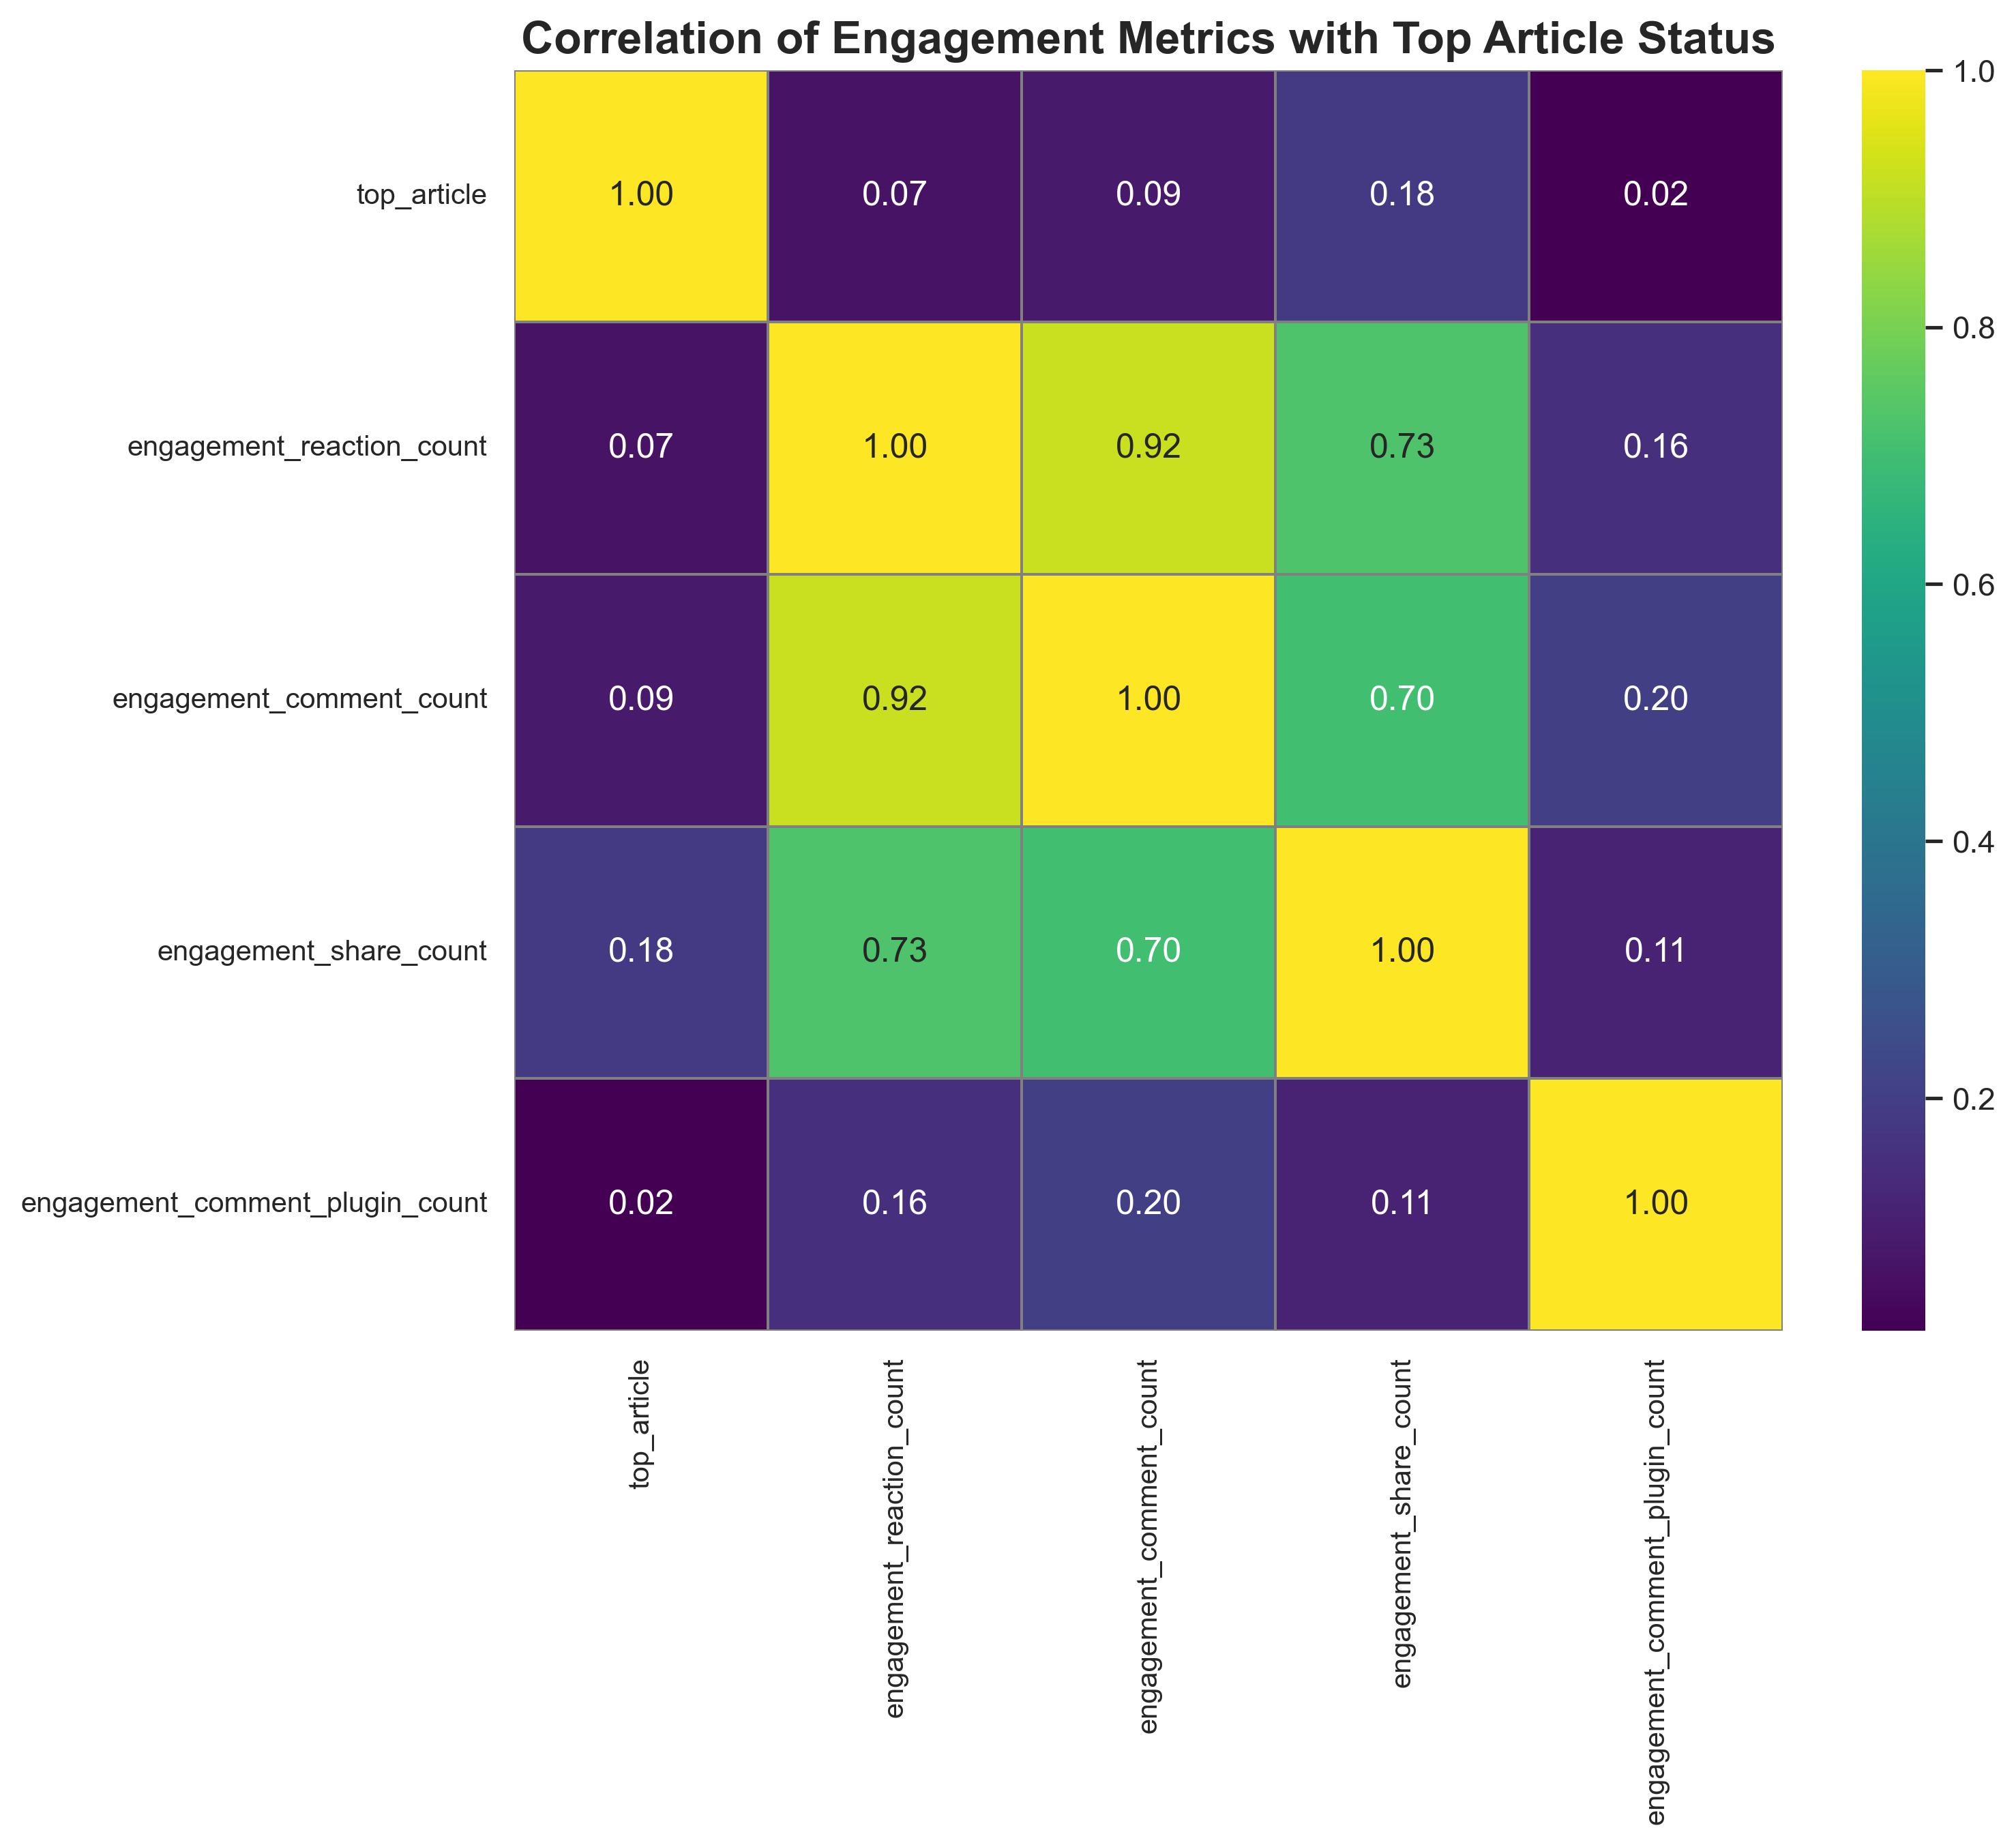

In [18]:
# Select engagement columns and top_article column
engagement_and_top_article = ['top_article'] + engagement_columns
engagement_top_article_df =df_cleaned[engagement_and_top_article]

# Calculate the correlation matrix
corr_matrix_top_article = engagement_top_article_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(corr_matrix_top_article, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5, linecolor='grey')
plt.title('Correlation of Engagement Metrics with Top Article Status', fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


## Correlation of Engagement Metrics over Time
This heatmap will show the correlation of engagement metrics over different months or years, depending on how the 'published_at' data is processed.

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3201860328.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['published_at'].dt.to_period('M')


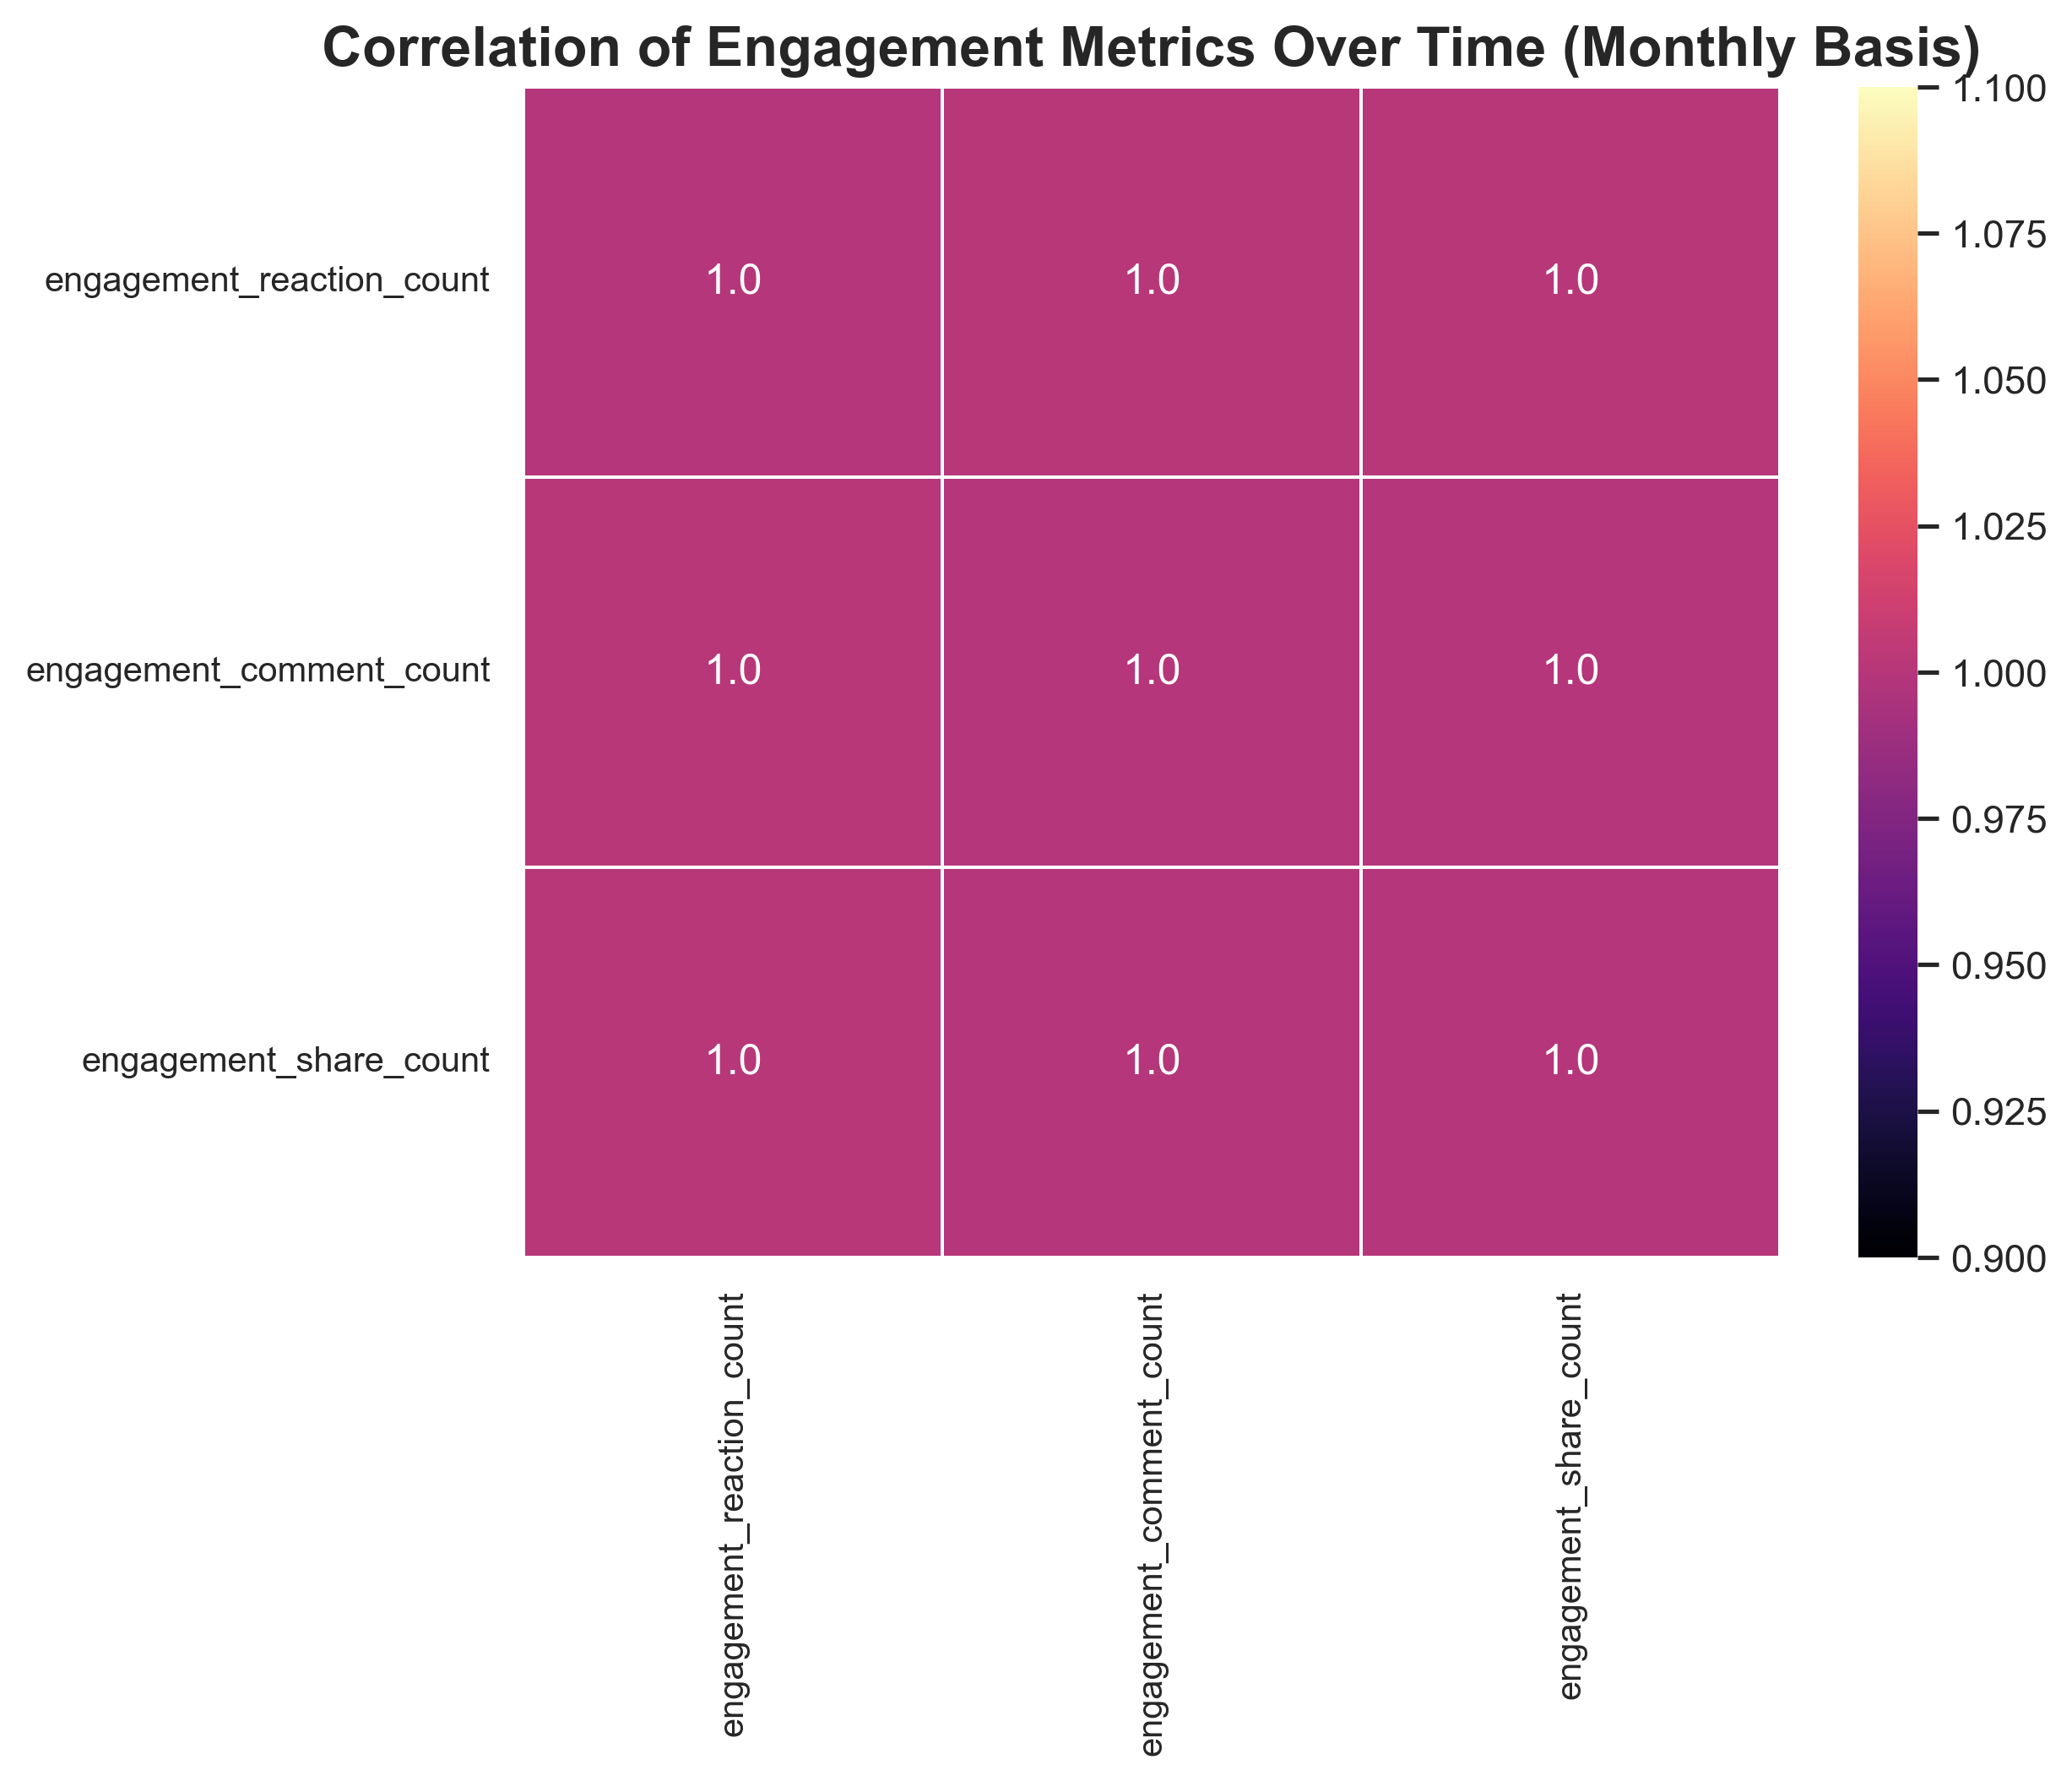

In [19]:
# Convert 'published_at' to datetime and extract month and year
df['published_at'] = pd.to_datetime(df['published_at'])
df['month_year'] = df['published_at'].dt.to_period('M')

# Select only engagement columns
engagement_columns = ['engagement_reaction_count', 'engagement_comment_count', 
                      'engagement_share_count']

# Group by month_year and calculate the mean of engagement metrics
monthly_engagement = df.groupby('month_year')[engagement_columns].mean()

# Calculate the correlation matrix
corr_matrix_monthly = monthly_engagement.corr()

# Create the heatmap
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(corr_matrix_monthly, annot=True, fmt=".1f", cmap='magma', linewidths=0.5, linecolor='white')
plt.title('Correlation of Engagement Metrics Over Time (Monthly Basis)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [20]:
df_cleaned.describe()


top_article  engagement_reaction_count  engagement_comment_count  \
count  7604.000000                7604.000000               7604.000000   
mean      0.121778                 380.792741                139.069174   
std       0.327051                2858.598827                984.854566   
min       0.000000                   0.000000                  0.000000   
25%       0.000000                   0.000000                  0.000000   
50%       0.000000                   2.000000                  0.000000   
75%       0.000000                  61.000000                 18.000000   
max       1.000000              125106.000000              48490.000000   

       engagement_share_count  engagement_comment_plugin_count  
count             7604.000000                      7604.000000  
mean               231.258680                         0.012888  
std               1061.326433                         0.293902  
min                  0.000000                         0.000000  
25%                  1.000000                         0.000000  
50%                 11.000000                         0.000000  
75%                 62.250000                         0.000000  
max              36720.000000                        15.000000

# Popularity Score Estimation and Visualization

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/1158332557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Popularity_Score'] = np.log1p((df_cleaned['engagement_reaction_count'] +


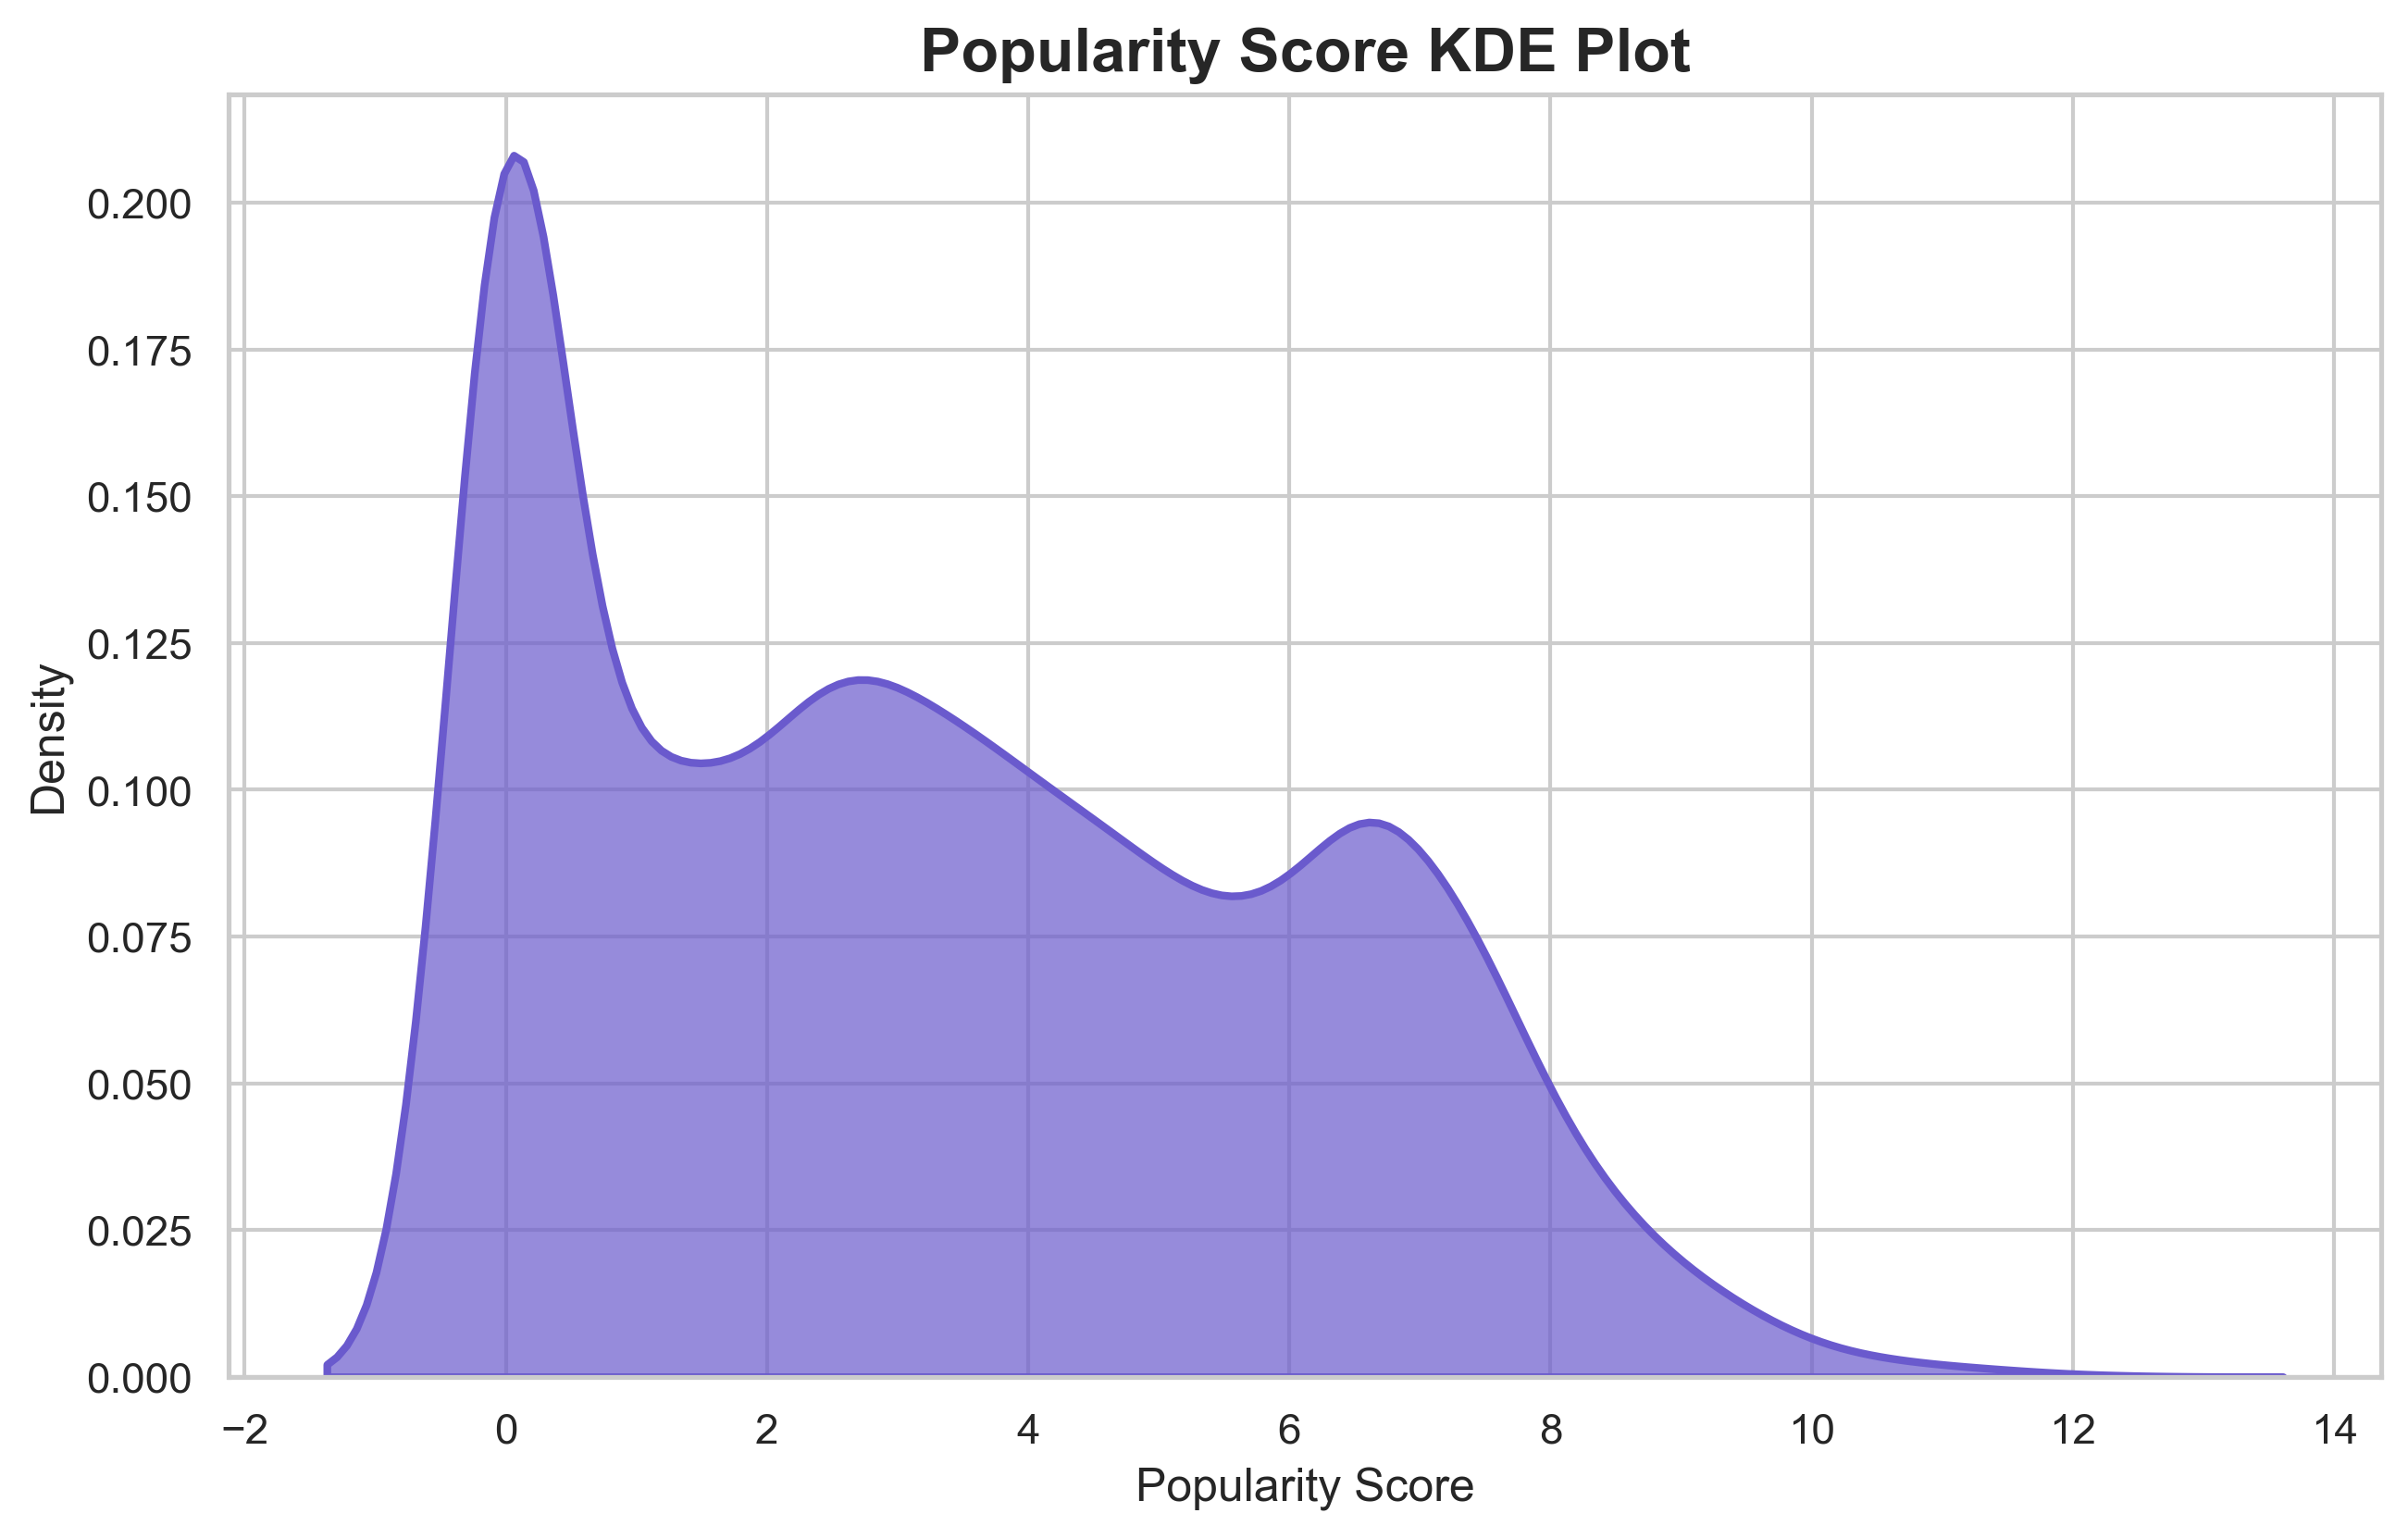

In [21]:
# Assuming df is your DataFrame and the engagement columns exist
# Calculate the Popularity Score
df_cleaned['Popularity_Score'] = np.log1p((df_cleaned['engagement_reaction_count'] +
                                   df_cleaned['engagement_comment_count'] +
                                   df_cleaned['engagement_share_count'] +
                                   df_cleaned['engagement_comment_plugin_count']))

# Set a style
sns.set(style="whitegrid", palette="pastel")

# Create the KDE plot with additional styling
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(df_cleaned['Popularity_Score'], shade=True, color="slateblue", alpha=0.7, linewidth=2)

# Customizing plot labels and title
plt.title('Popularity Score KDE Plot', fontsize=16, fontweight='bold')
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Display the plot
plt.show()


In [22]:
# Assuming df['published_at'] is in a suitable date format. If not, convert it:
df_cleaned['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', infer_datetime_format=True)

# Convert the 'Popularity_Score' column to numeric (assuming it contains numeric data)
df_cleaned['Popularity_Score'] = pd.to_numeric(df_cleaned['Popularity_Score'], errors='coerce')

# Group the data by 'source_name' and calculate the mean 'Popularity_Score' for each source
result = df_cleaned.groupby('source_name')['Popularity_Score'].mean().reset_index()

# Sort the result by 'Popularity_Score' in descending order
result = result.sort_values(by='Popularity_Score', ascending=False)

# Display the result
print(result)


                source_name  Popularity_Score
4                  CBS News          5.321296
10       The New York Times          4.835046
5                       CNN          4.589151
3          Business Insider          3.830393
1        Al Jazeera English          3.775333
11  The Wall Street Journal          3.635721
2                  BBC News          3.554769
8                   Reuters          2.699387
7                  Newsweek          2.674136
0                  ABC News          2.281455
9           The Irish Times          1.442981
6                      ESPN          0.000000


/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3165491958.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_cleaned['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', infer_datetime_format=True)
/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3165491958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', infer_datetime_format=True)
/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_8137

In [23]:
df.columns

Index(['source_id', 'source_name', 'author', 'title', 'description', 'url',
       'url_to_image', 'published_at', 'content', 'top_article',
       'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count',
       'total_engagement', 'Day_Of_Week', 'Month', 'Year', 'month_year'],
      dtype='object')

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3253088008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Popularity_Score'] = np.log1p(df['engagement_reaction_count'] + \


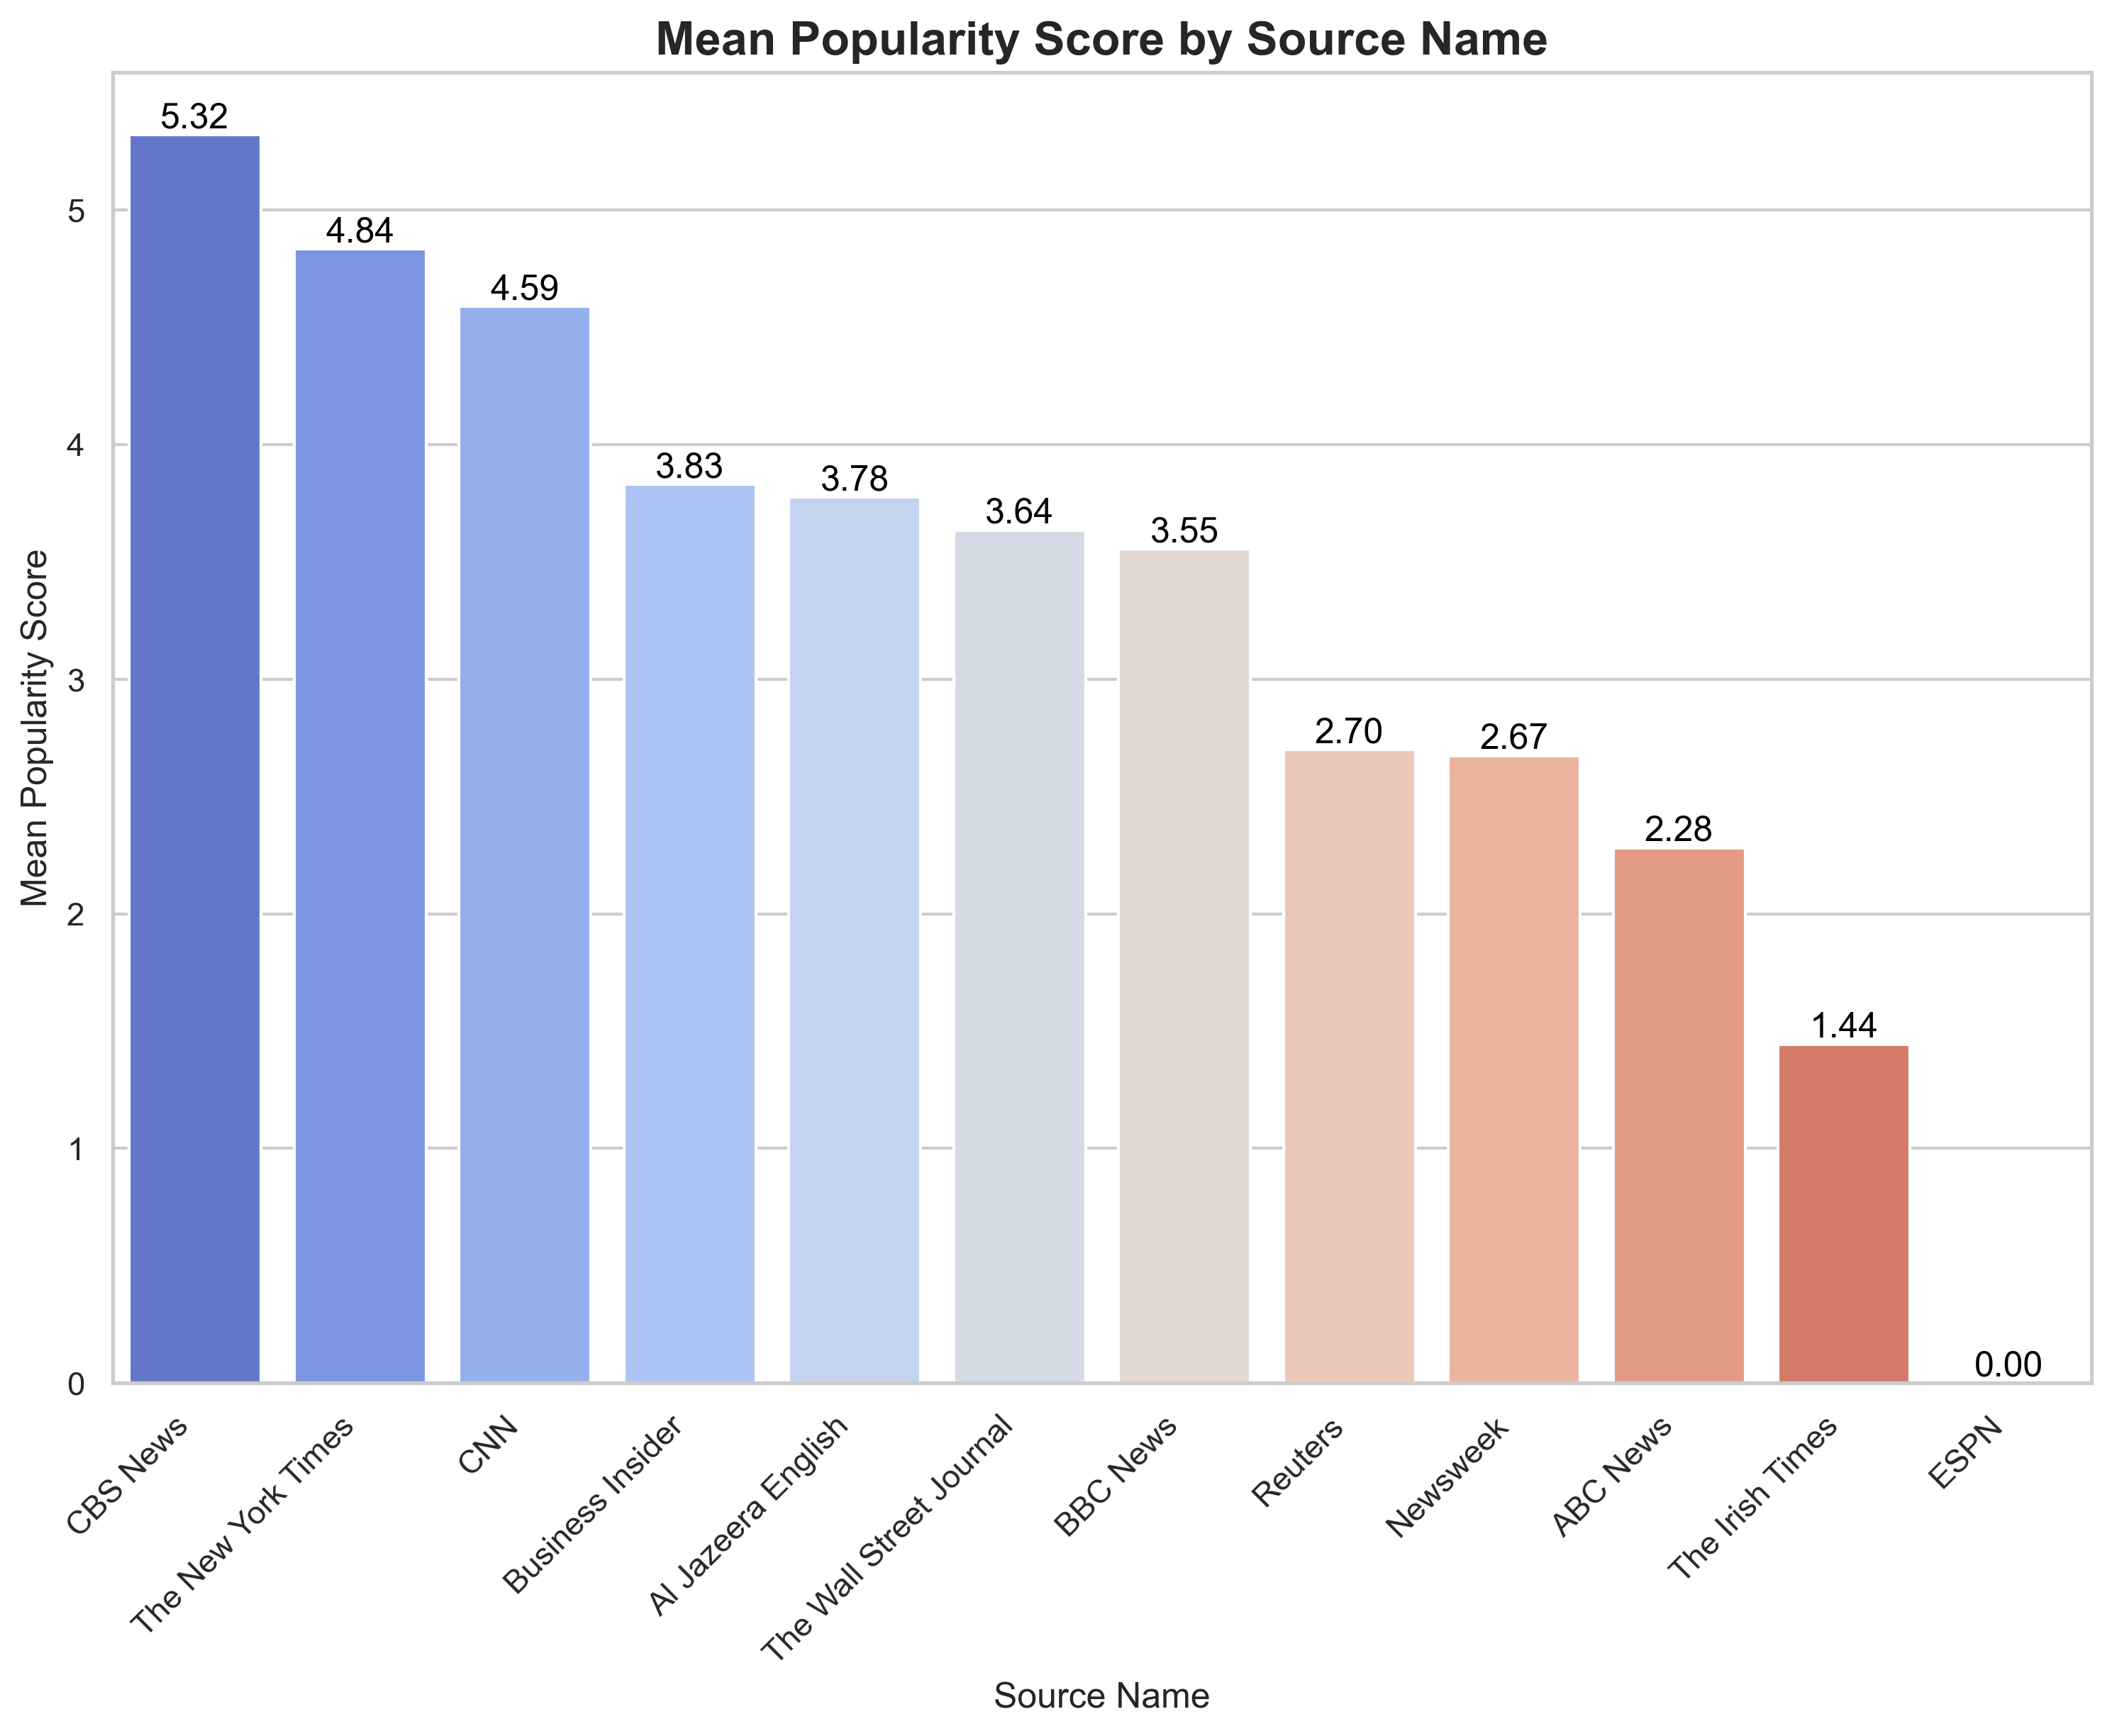

In [24]:
# Calculate the Popularity Score
df_cleaned['Popularity_Score'] = np.log1p(df['engagement_reaction_count'] + \
                                  df_cleaned['engagement_comment_count'] + \
                                  df_cleaned['engagement_share_count'] + \
                                  df_cleaned['engagement_comment_plugin_count'])

# Calculate mean popularity by source name
mean_popularity = df_cleaned.groupby(by='source_name')['Popularity_Score'].mean().to_frame()

# Sort the DataFrame by 'Popularity_Score' in descending order
mean_popularity = mean_popularity.sort_values(by='Popularity_Score', ascending=False)

# Enhanced Bar Chart Visualization
plt.figure(figsize=(12, 8), dpi=300)
pal = sns.color_palette("coolwarm", len(mean_popularity))
rank = mean_popularity['Popularity_Score'].argsort().argsort()
sns.barplot(x=mean_popularity.index, y='Popularity_Score', data=mean_popularity, palette=np.array(pal[::-1])[rank])

# Adding annotations
for index, value in enumerate(mean_popularity['Popularity_Score']):
    plt.text(index, value, f'{value:.2f}', color='black', ha="center", va="bottom")

# Customizing plot labels and title
plt.title('Mean Popularity Score by Source Name', fontsize=16, fontweight='bold')
plt.xlabel('Source Name', fontsize=12)
plt.ylabel('Mean Popularity Score', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


# Title Cleaning

In [25]:
# Data Cleaning 
def clean_title(x:str):    
    # lowering the text
    x=x.lower() 
 
    #removing square brackets
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x) 

    #removing hyperlink
    x = re.sub('https?://\S+|www\.\S+', '', x) 

    #removing puncuation
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x) 
    x = re.sub('\n', '', x) 

    #remove words containing numbers
    x = re.sub('\w*\d\w*', '', x) 
    return x

# Word Cloud
Most common word used in Title.

In [26]:
np.array(list(STOPWORDS))[-5:]

array(['on', 'by', 'cannot', 'they', 'be'], dtype='<U10')

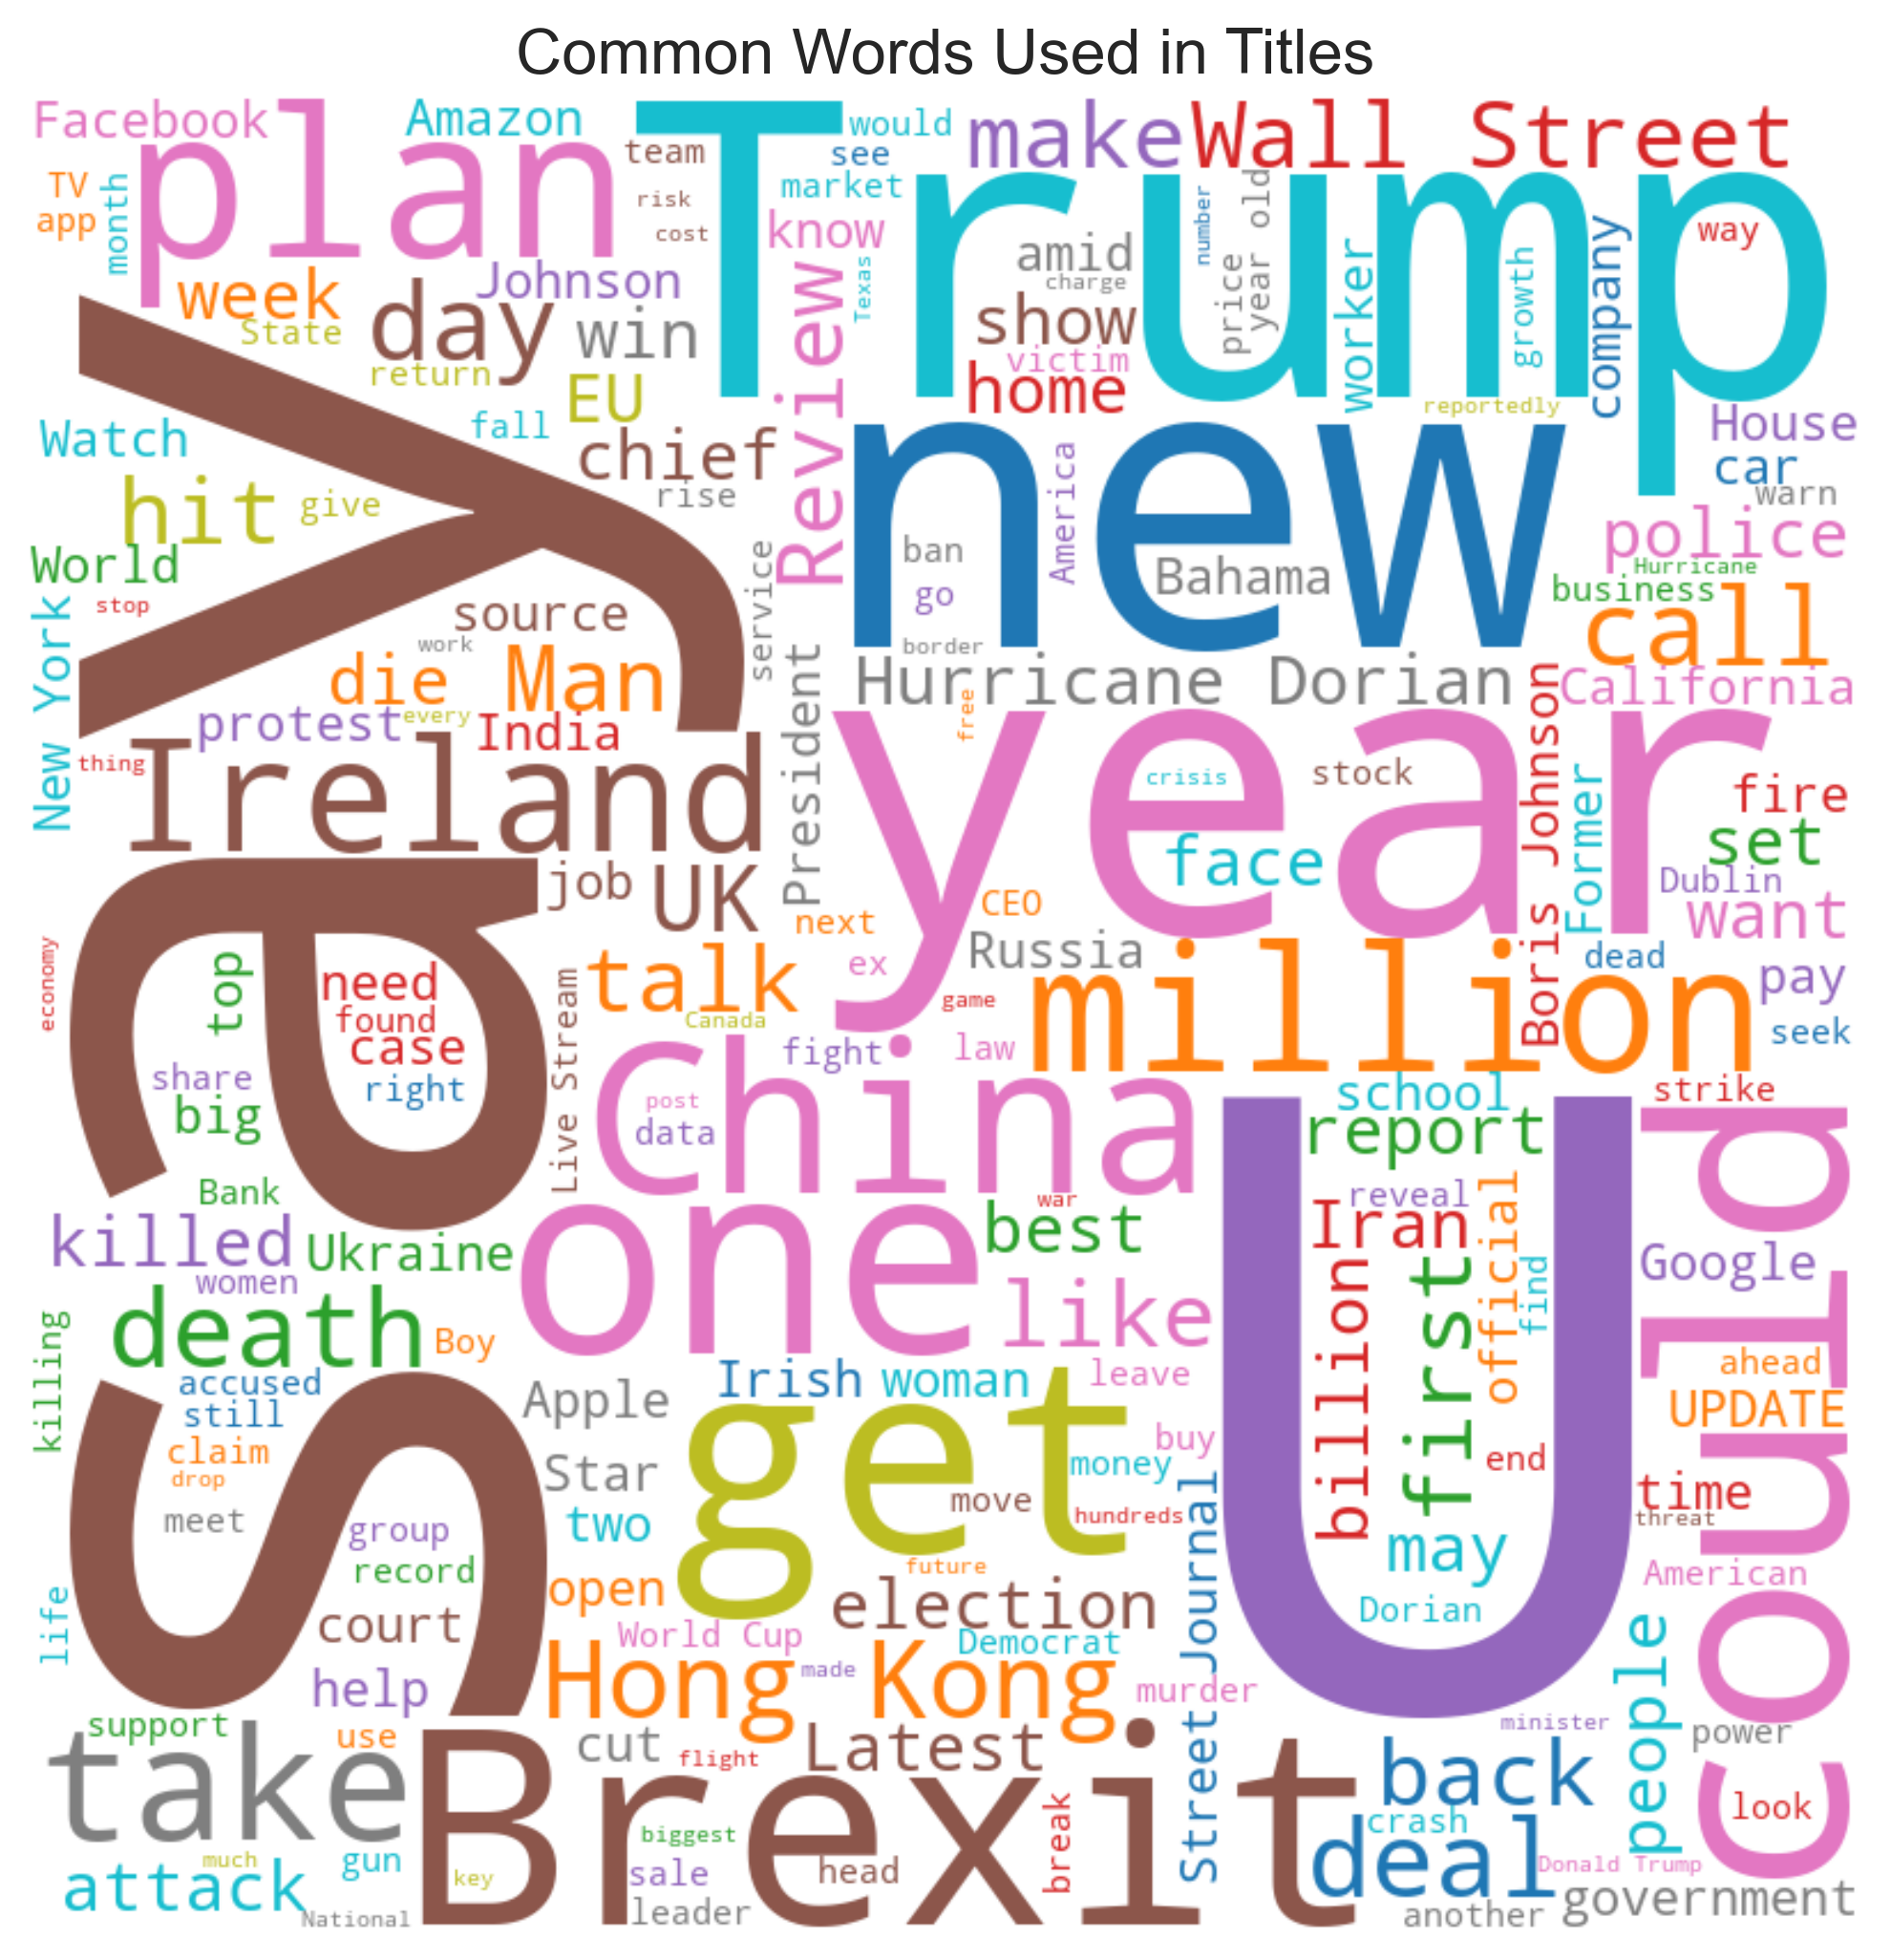

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import nltk
from nltk.corpus import stopwords


# Load the stop words
stop_words = set(stopwords.words("english"))

# Custom color function for the WordCloud
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    return np.random.choice(colors)

# Creating the WordCloud
wc = WordCloud(width=800, height=800, background_color="white", min_font_size=10, 
               repeat=True, stopwords=stop_words, contour_color='black', contour_width=3)

# Assuming df is your DataFrame containing the 'title' column
wc.generate(" ".join(df_cleaned['title'].astype(str)))

# Creating the figure
fig, ax = plt.subplots(figsize=[14, 7], facecolor=None, dpi=300)

# Displaying the WordCloud
ax.imshow(wc.recolor(color_func=custom_color_func), interpolation="bilinear")
ax.axis("off")
ax.set_title('Common Words Used in Titles', fontsize=16)

plt.tight_layout()
plt.show()

# Stemming

To reduce words to their base or root form. The process, known as stemming, involves trimming off the ends of words

In [28]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import pandas as pd

def stem_sentence(sentence):
    stemmer = PorterStemmer()
    token_words = nltk.word_tokenize(sentence)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

df_cleaned['stemmed_title'] = df_cleaned['title'].fillna('').apply(lambda x: stem_sentence(str(x)))

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/609962260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['stemmed_title'] = df_cleaned['title'].fillna('').apply(lambda x: stem_sentence(str(x)))


# Preprocessing
Replace missing titles
Convert titles into vectors
Replace missing values in top_article
Over sampling using SMOTE
Creating popularity pcore

# Tfidf Vectorizer
Our machine learning models understand only numerical values so in order to train our model on text data we will convert it to a matrix of TF-IDF features.

In [29]:
# Adding new columns containing clean titles
df_cleaned['clean_title'] = df_cleaned['stemmed_title'].astype(str).apply(clean_title) 
df_cleaned['clean_title'][0:5]

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3145216190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['clean_title'] = df_cleaned['stemmed_title'].astype(str).apply(clean_title)


0    ntsb say autopilot engag in  california tesla ...
1                 unemploy fall to postcrash low of   
3    north korean footbal han join italian giant ju...
6    eu want to see if lawmak will block brexit bef...
7    european third quarter profit outlook improv s...
Name: clean_title, dtype: object

In [30]:
df_cleaned['clean_title'].fillna('Missing',inplace=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(df_cleaned['clean_title'])

/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/1327571116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['clean_title'].fillna('Missing',inplace=True)


# Oversampling
Our top_article data is unbalanced as we only have 12 percent of 1's. In order to make our model perform better, we will be using oversampling method SMOTE (Synthetic Minority Over-sampling Technique). I have also tried other oversampling and under sampling methods but SMOTE performed better.

In [31]:
df_cleaned['top_article'] = df_cleaned['top_article'].astype(int)

list_labels = df_cleaned["top_article"].fillna(0)


# Now, your 'top_article' column will have values 0 and 1 without decimal points
print(df_cleaned['top_article'].value_counts())


top_article
0    6678
1     926
Name: count, dtype: int64


/var/folders/9s/3m2mztv94tgc632ky6b3jg4m0000gn/T/ipykernel_81377/3639959778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['top_article'] = df_cleaned['top_article'].astype(int)


In [32]:
926/6678

0.13866427073974244

In [33]:
OS = SMOTE()
X,Y = OS.fit_resample(train_tfidf,list_labels)


# Principal component analysis


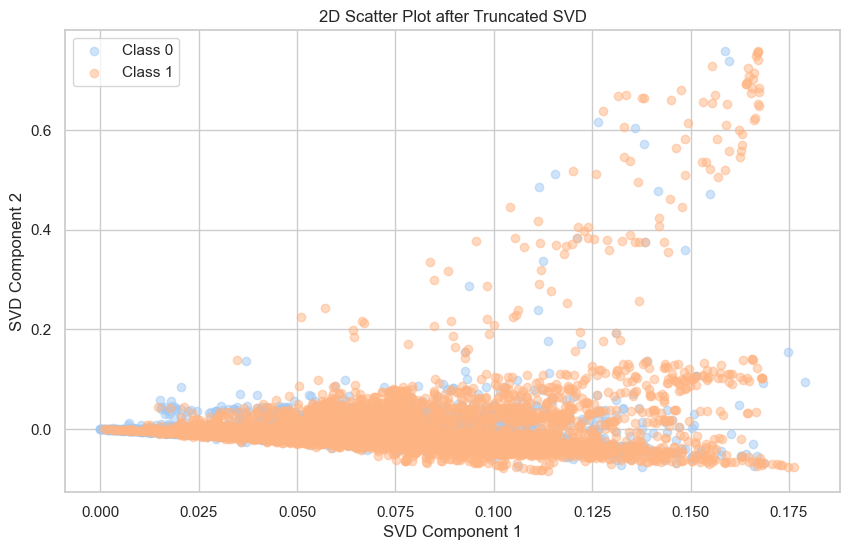

In [34]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Apply Truncated SVD to reduce dimensions to 2
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)  # Assuming X is your TF-IDF data

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[Y == 0, 0], X_reduced[Y == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_reduced[Y == 1, 0], X_reduced[Y == 1, 1], label='Class 1', alpha=0.5)
plt.title('2D Scatter Plot after Truncated SVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()


# Test Classifier Model
Let’s build a model that will take titles and predict whether the article will be become top or not.

X = title,
y = top_article

# Spliting Data for Model Construction 
We have experimented with SGD and Random Forest classifier but by far light gradient boosting model performed better. After hyperparameter tunning our model was is ready to be trained on the dataset.

Splitting into train and test.
Stratify our top_article so they are equaly distributed.
Using LGBMClassifier
learning_rate=0.5,
max_depth=20,
num_leaves=50,
n_estimators=120,
max_bin=2000
Cross Validation
Training and Testing
Confusion Matrix

In [35]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    stratify = Y ,
                                                    random_state=40)



In [36]:
y_train.value_counts()

top_article
1    5342
0    5342
Name: count, dtype: int64

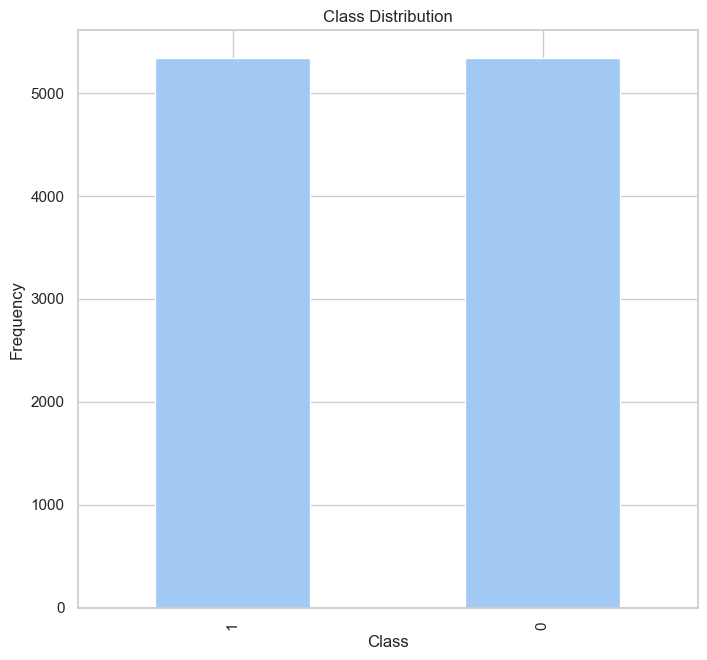

In [37]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


# Hyperparameters tunning using RandomizedSearchCV

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Define the parameter distributions for LGBMClassifier
param_dist_lgb = {
    'learning_rate': sp_uniform(0.01, 0.5),
    'max_depth': sp_randint(5, 20),
    'num_leaves': sp_randint(20, 50),
    'n_estimators': sp_randint(50, 150),
    'max_bin': sp_randint(200, 2000)
}

# Initialize the RandomizedSearchCV object for LGBMClassifier
random_search_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(verbose=-1),
    param_distributions=param_dist_lgb,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=40,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data for LGBMClassifier
random_search_lgb.fit(X_train, y_train)

# Define the parameter distributions for DecisionTreeClassifier
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 5)
}

# Initialize the RandomizedSearchCV object for DecisionTreeClassifier
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_dist_dt,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=40,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data for DecisionTreeClassifier
random_search_dt.fit(X_train, y_train)

# Define the parameter distributions for LogisticRegression
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': sp_uniform(0.01, 10.0),
    'solver': ['liblinear', 'lbfgs'],  # 'liblinear' is compatible with 'l1' penalty
    'max_iter': sp_randint(100, 301)
}

# Initialize the RandomizedSearchCV object for LogisticRegression
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_dist_lr,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=40,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data for LogisticRegression
random_search_lr.fit(X_train, y_train)

# Get the best parameters and scores for each classifier
best_params_lgb = random_search_lgb.best_params_
best_score_lgb = random_search_lgb.best_score_
best_params_dt = random_search_dt.best_params_
best_score_dt = random_search_dt.best_score_
best_params_lr = random_search_lr.best_params_
best_score_lr = random_search_lr.best_score_

# Print the best parameters and scores
print("Best Parameters for LGBMClassifier:", best_params_lgb)
print("Best Score for LGBMClassifier:", best_score_lgb)
print("Best Parameters for DecisionTreeClassifier:", best_params_dt)
print("Best Score for DecisionTreeClassifier:", best_score_dt)
print("Best Parameters for LogisticRegression:", best_params_lr)
print("Best Score for LogisticRegression:", best_score_lr)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/sannaishtiaq/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sannaishtiaq/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
110 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sannaishtiaq/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sannaishtiaq/anaconda3/lib/python3.11/site-packages/sklearn/base.py", li

Best Parameters for LGBMClassifier: {'learning_rate': 0.2561205440771298, 'max_bin': 297, 'max_depth': 17, 'n_estimators': 97, 'num_leaves': 45}
Best Score for LGBMClassifier: 0.9060096223059844
Best Parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score for DecisionTreeClassifier: 0.8654656509076922
Best Parameters for LogisticRegression: {'C': 9.574738869698843, 'max_iter': 175, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score for LogisticRegression: 0.9523124656134085


# LGBMClassifier

In [39]:
LGB = LGBMClassifier(verbose=-1,
                          learning_rate=0.2561,
                          max_depth=17,
                          num_leaves=45, 
                          n_estimators=97,
                          max_bin=297)


### Cross Validation for LGBMClassifier 

In [40]:
scores_LGB = cross_val_score(
                 LGB, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores for LGBMClassifier : ",scores_LGB)

Cross Validation F1 Scores for LGBMClassifier :  [0.89833387 0.91006066 0.91053703 0.90018768 0.91141898]


# Decision Tree Classifier 

In [41]:
DT = DecisionTreeClassifier(criterion='entropy',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_leaf_nodes=None,
    class_weight=None)

### Cross Validation for Decision Tree Classifier 

In [42]:
scores_DT = cross_val_score(
                 DT, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores for Decision Tree Classifier : ",scores_DT)

Cross Validation F1 Scores for Decision Tree Classifier :  [0.85626198 0.86895107 0.86608515 0.87270134 0.86514537]


# Logisticregression Classifier

In [43]:
LG = LogisticRegression(penalty='l2',
    C=9.574,
    solver='liblinear',
    max_iter=175,
    multi_class='auto',
    class_weight=None)

### Cross Validation with Logistic Regression Classifier

In [44]:
scores_LG = cross_val_score(
                 LG, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores for Logistic Regression Classifier : ",scores_LG)

Cross Validation F1 Scores for Logistic Regression Classifier :  [0.95175832 0.95174055 0.94987603 0.95410143 0.954086  ]


In [45]:
# Decision Tree Classifier
DT.fit(X_train, y_train)
pred_DT = DT.predict(X_test)

# Logistic Regression Classifier
LG.fit(X_train, y_train)
pred_LG = LG.predict(X_test)

# LGBM Classifier
LGB.fit(X_train, y_train)
pred_LGB = LGB.predict(X_test)

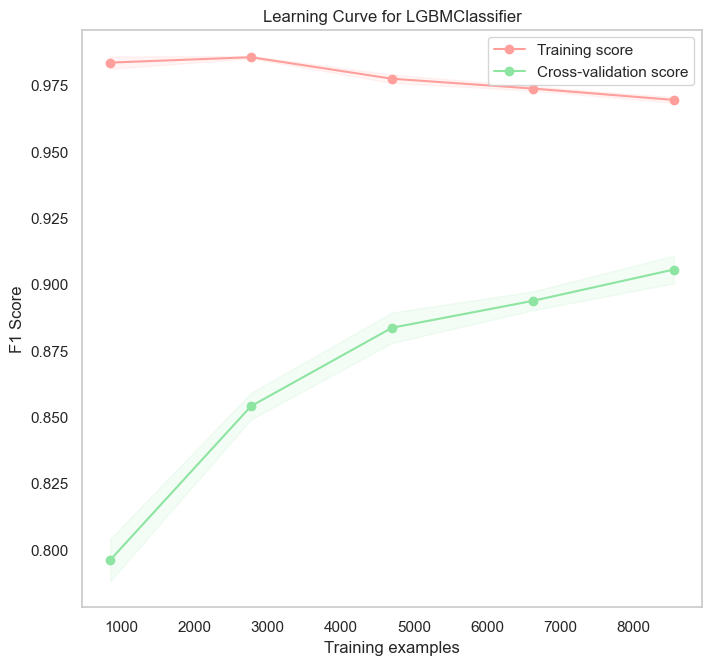

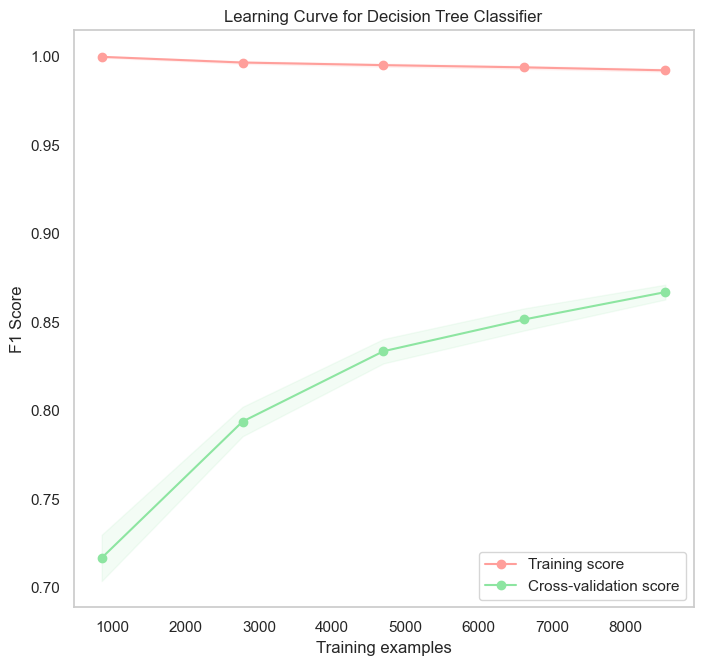

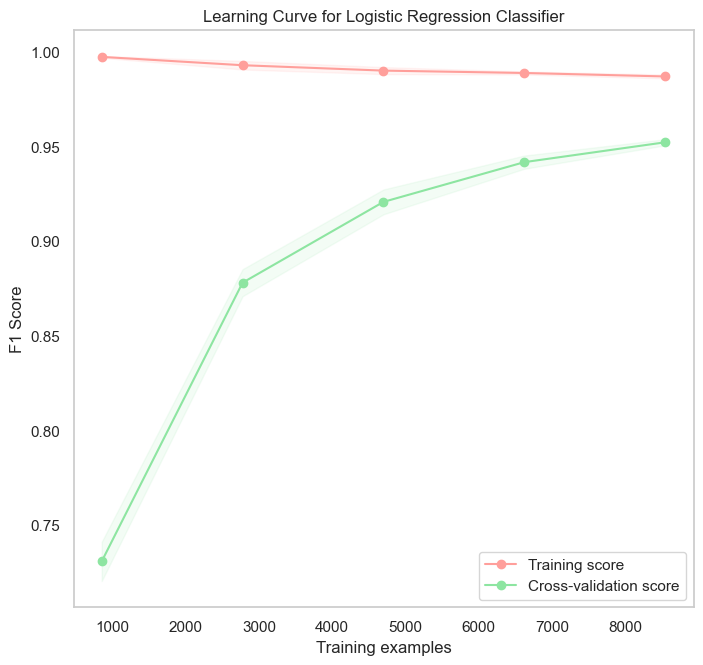

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Create learning curves for each model
plot_learning_curve(LGB, "Learning Curve for LGBMClassifier", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(DT, "Learning Curve for Decision Tree Classifier", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

plot_learning_curve(LG, "Learning Curve for Logistic Regression Classifier", X_train, y_train, cv=5, n_jobs=-1)
plt.show()


By examining these learning curve plots, you can gain insights into whether your models are overfitting (if there's a large gap between the training and validation curves) or underfitting (if both curves converge to a low score).

# Feature Importance 

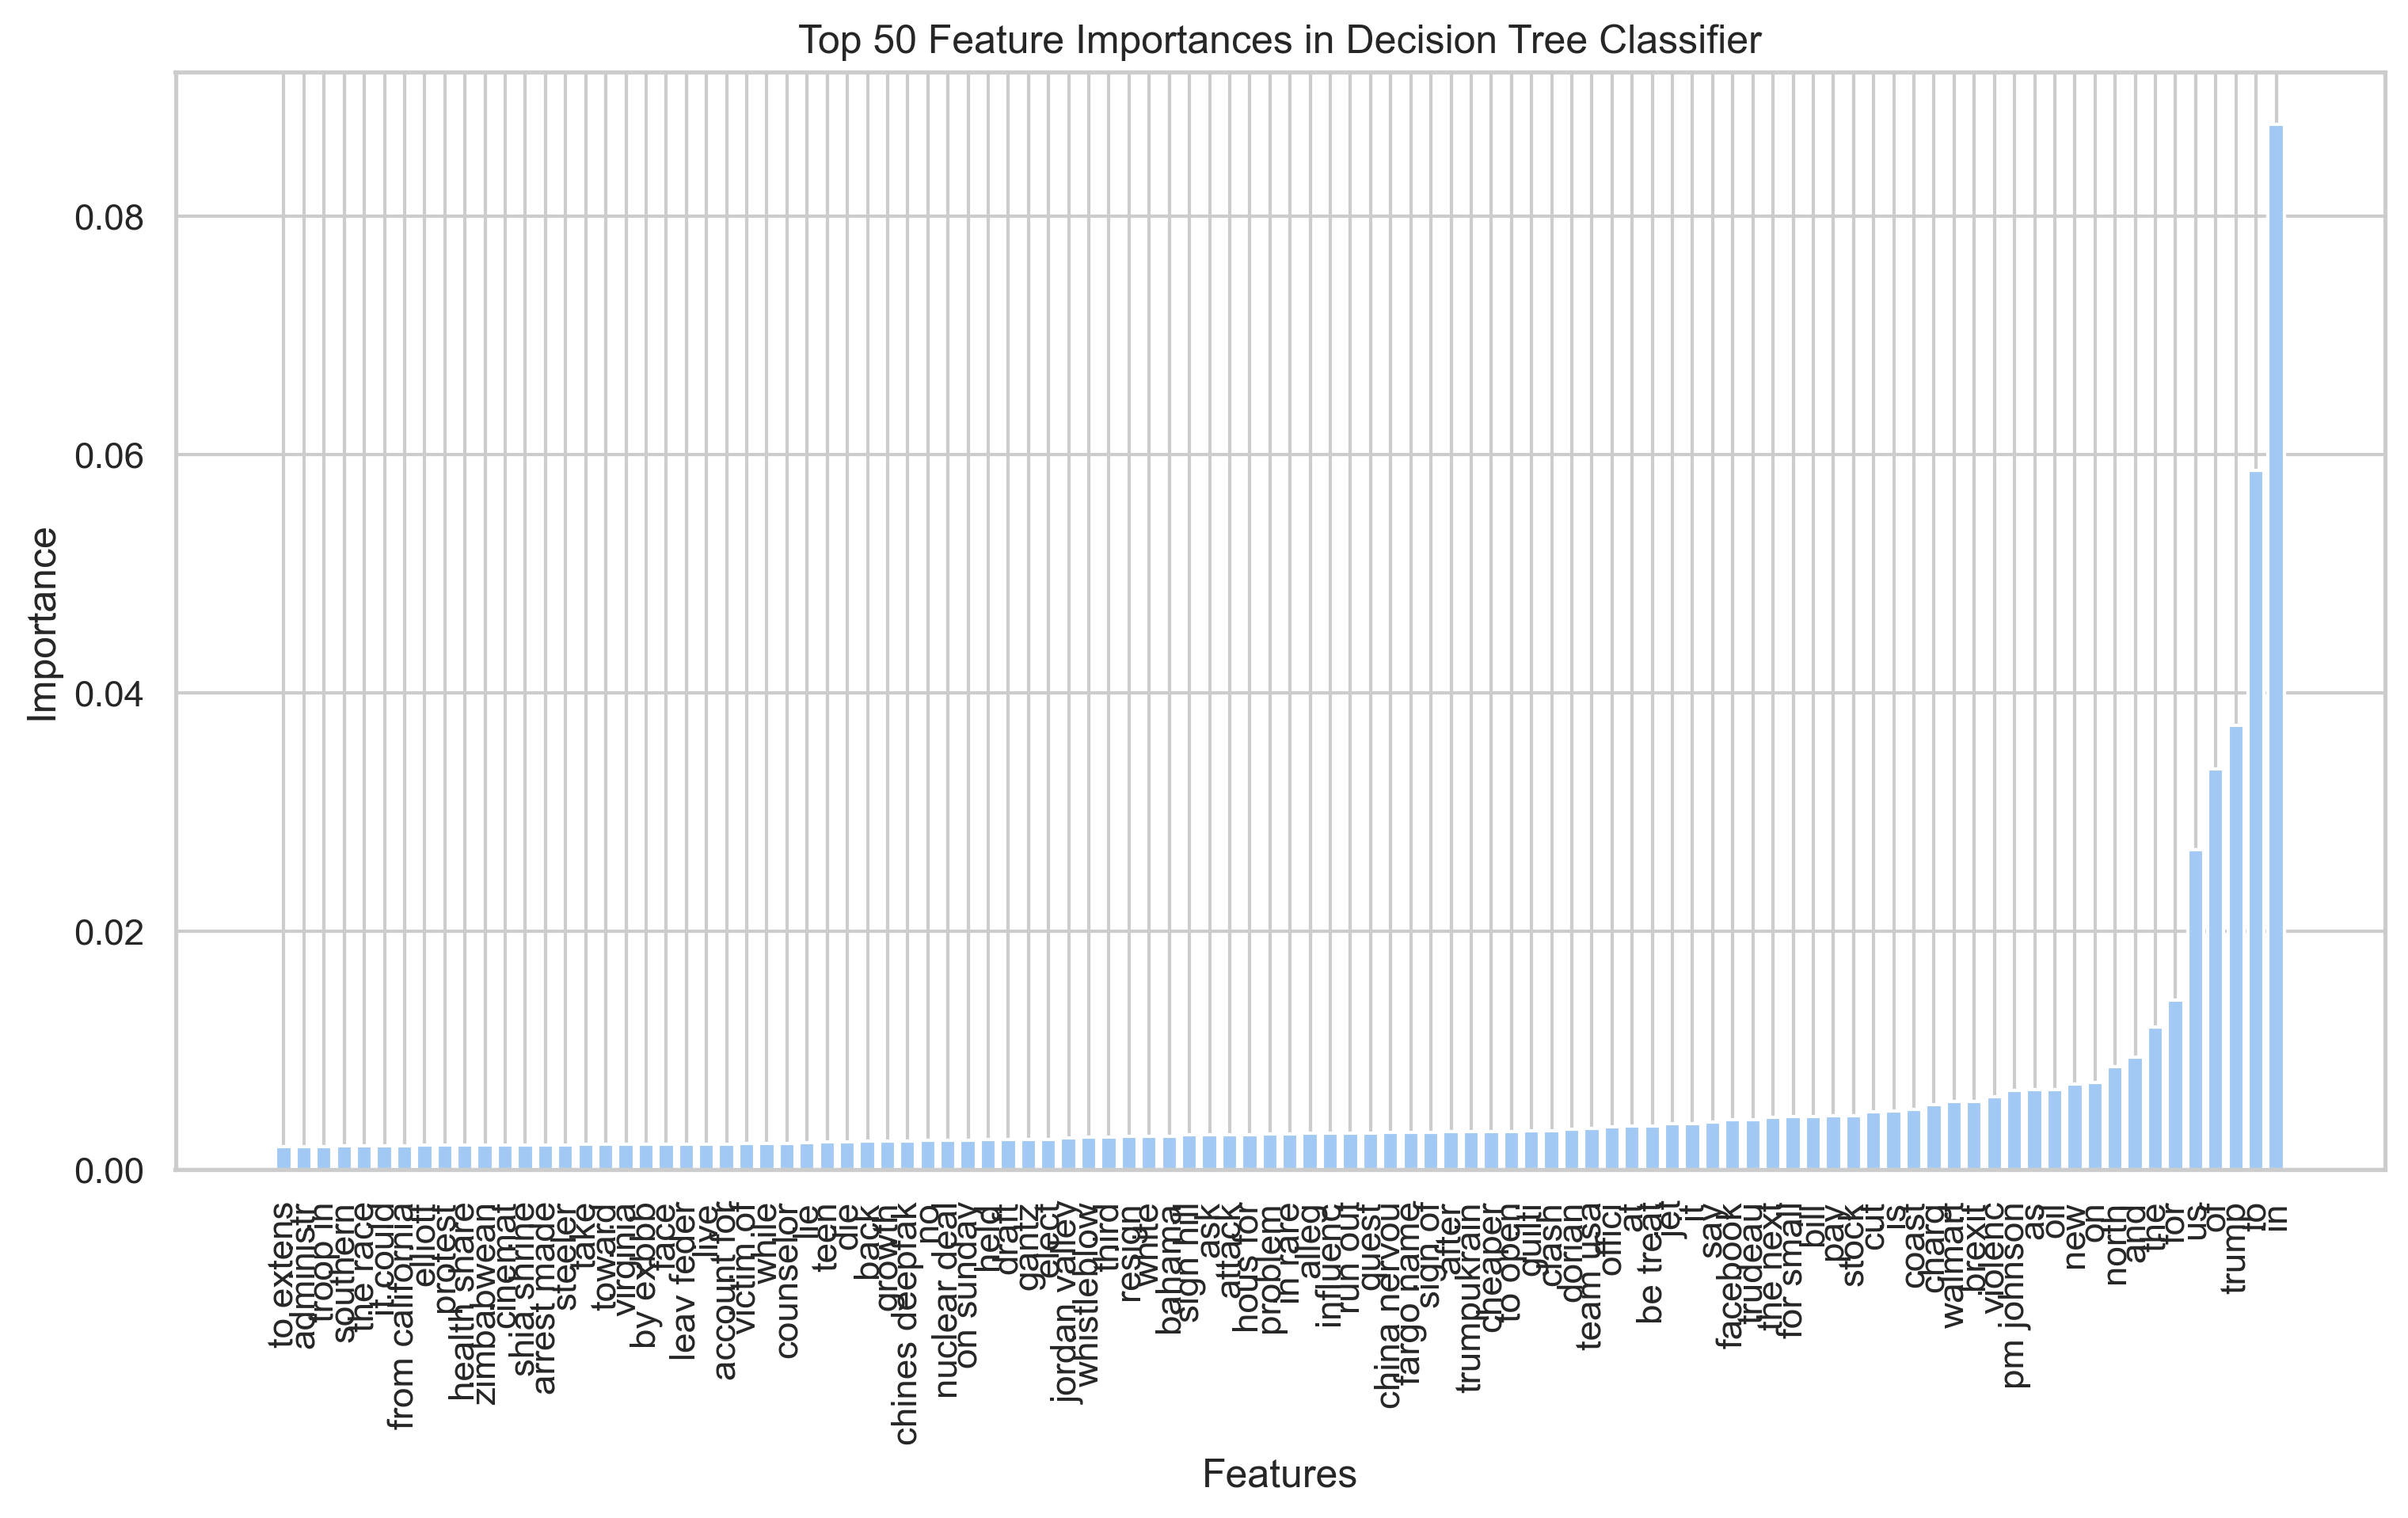

In [47]:
feature_importances_dt = DT.feature_importances_
# Assuming your TF-IDF vectorizer is named tfidf_vec
feature_names = tfidf_vec.get_feature_names_out()


#Example for top N features
N = 100  # You can change this number as needed
sorted_idx = feature_importances_dt.argsort()[-N:]
plt.figure(figsize=(12, 6),dpi=300)
plt.bar(range(N), feature_importances_dt[sorted_idx], align='center')
plt.xticks(range(N), feature_names[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 50 Feature Importances in Decision Tree Classifier')
plt.show()

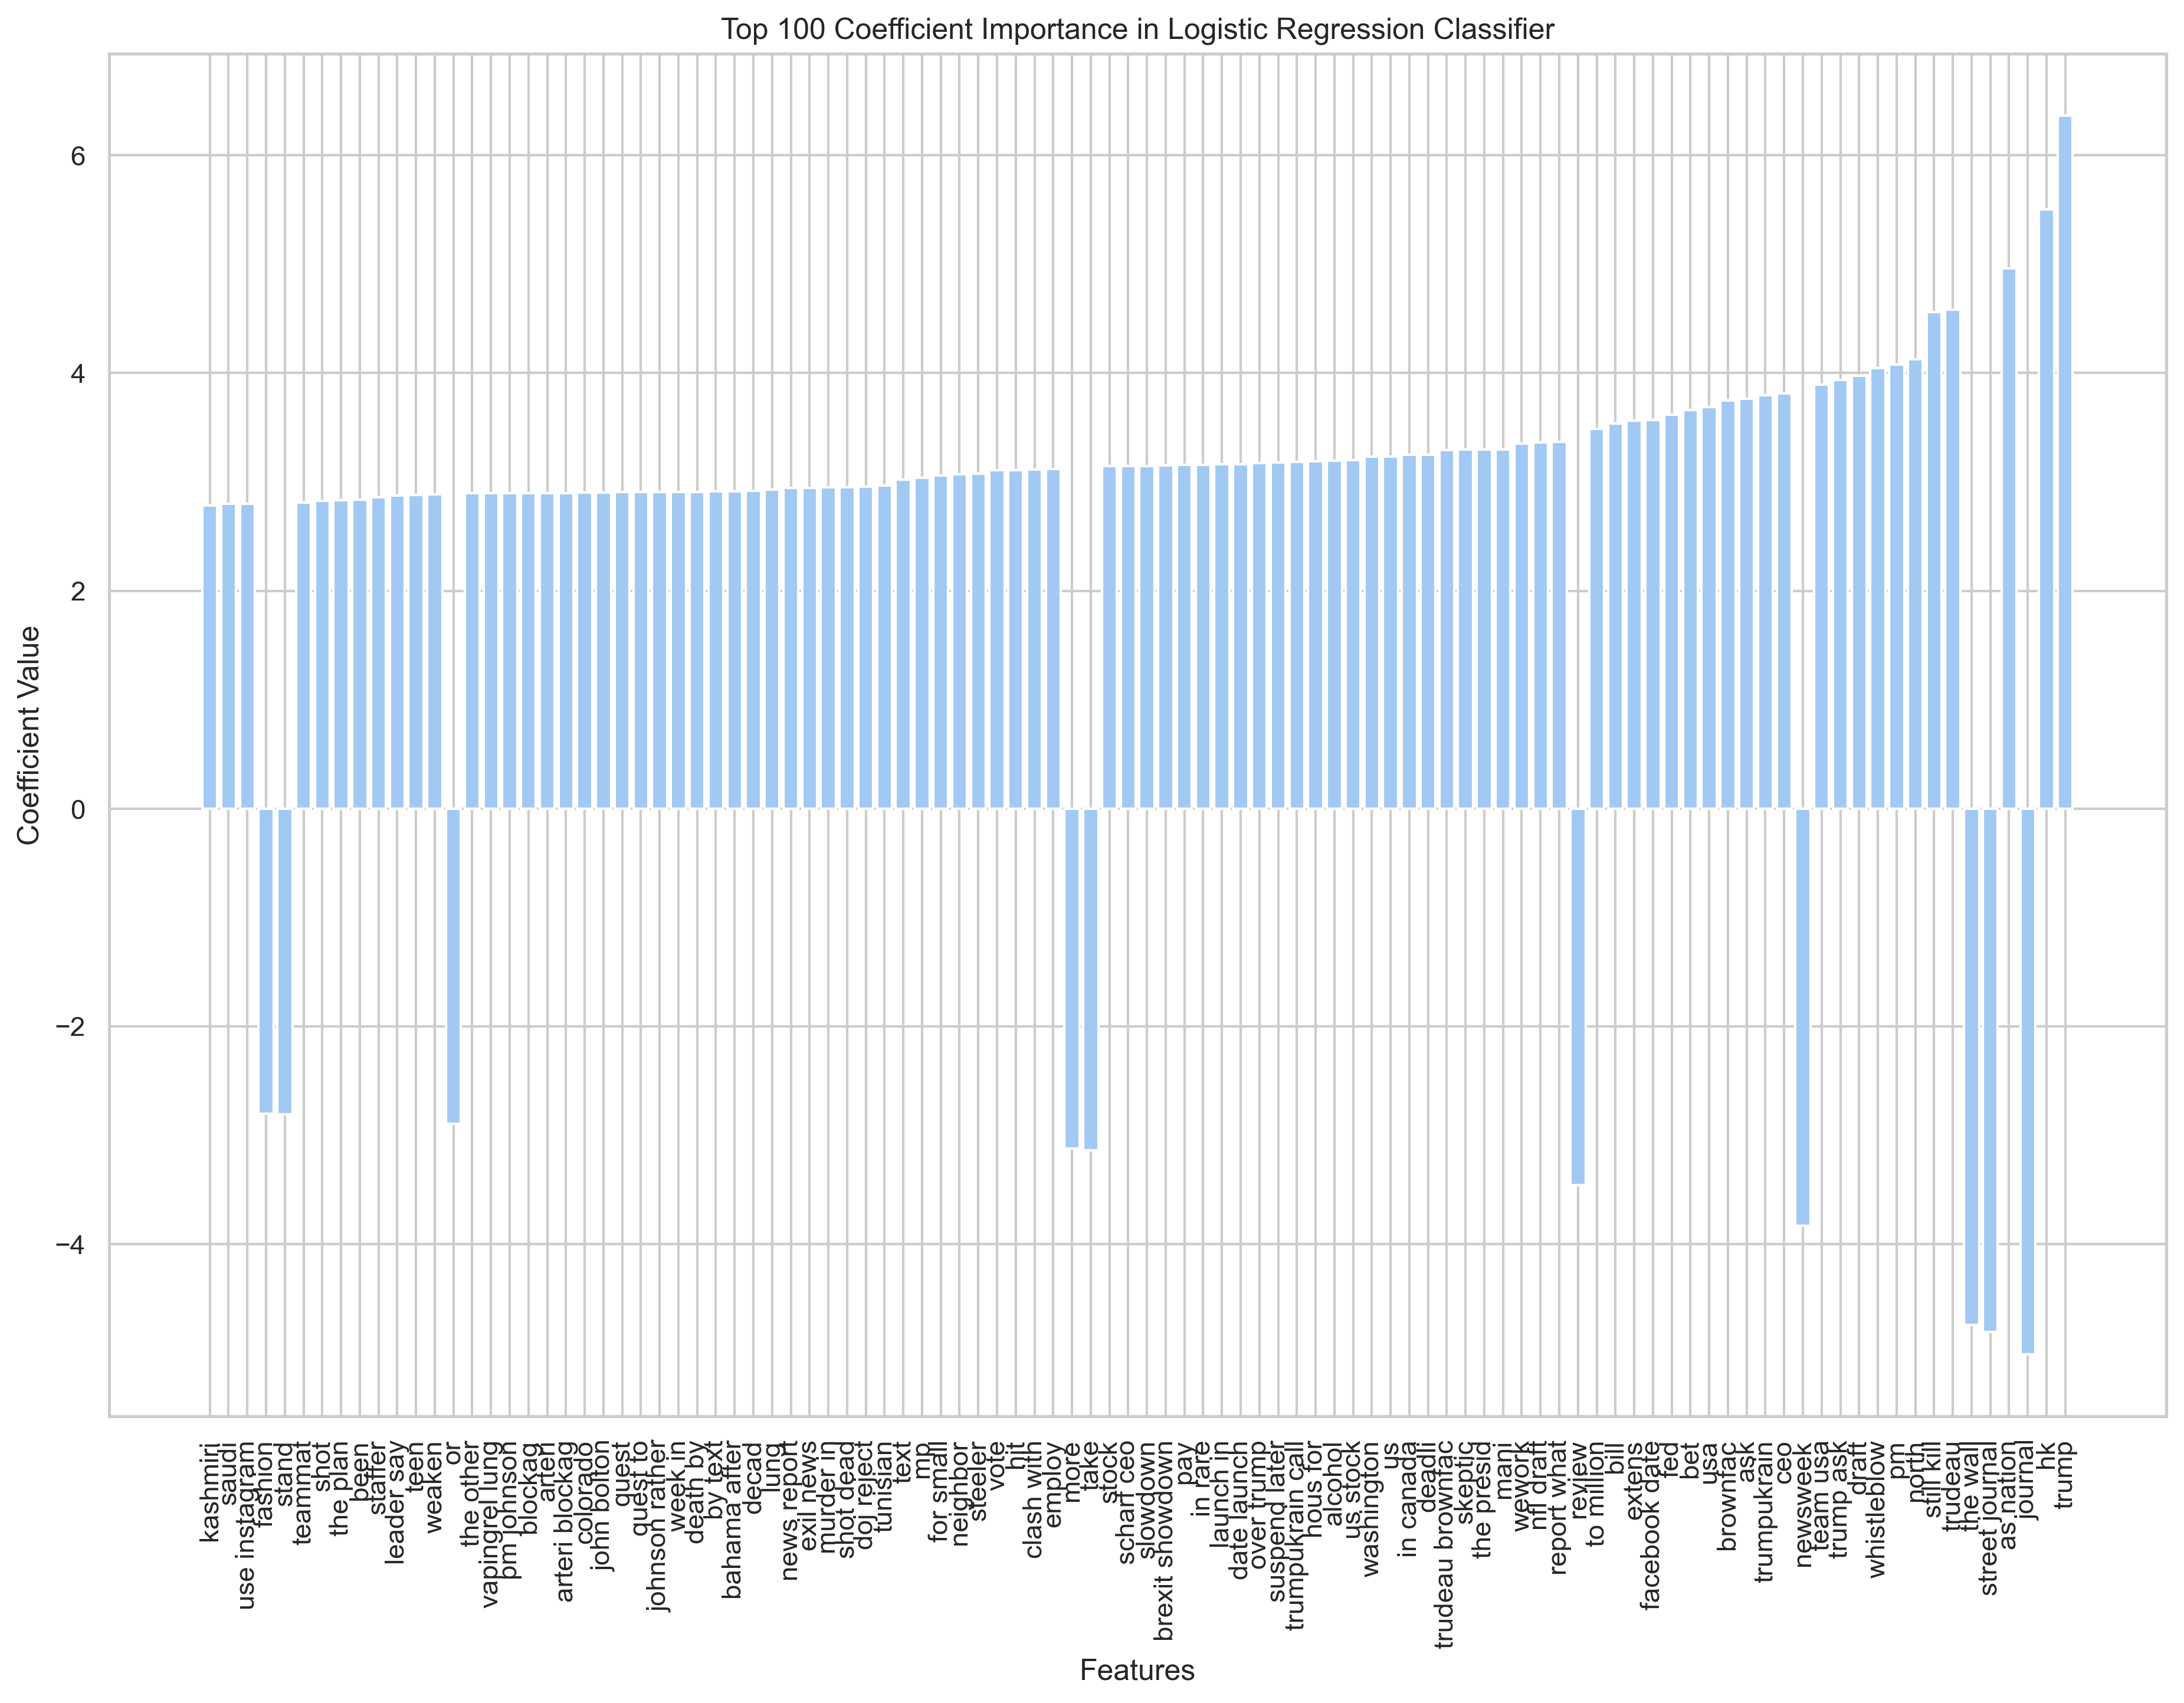

In [48]:
feature_importances_lg = LG.coef_[0]

N = 100

# Get the indices of the top 100 features
sorted_indices = np.argsort(np.abs(feature_importances_lg))[-N:]

# Get the top 100 feature names and their corresponding coefficients
top_features = np.array(feature_names)[sorted_indices]
top_coefficients = feature_importances_lg[sorted_indices]

# Plotting the top 100 features
plt.figure(figsize=(15, 10), dpi=300)  # Adjusted for better readability
plt.bar(range(100), top_coefficients, align='center')
plt.xticks(range(100), top_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Top 100 Coefficient Importance in Logistic Regression Classifier')
plt.show()

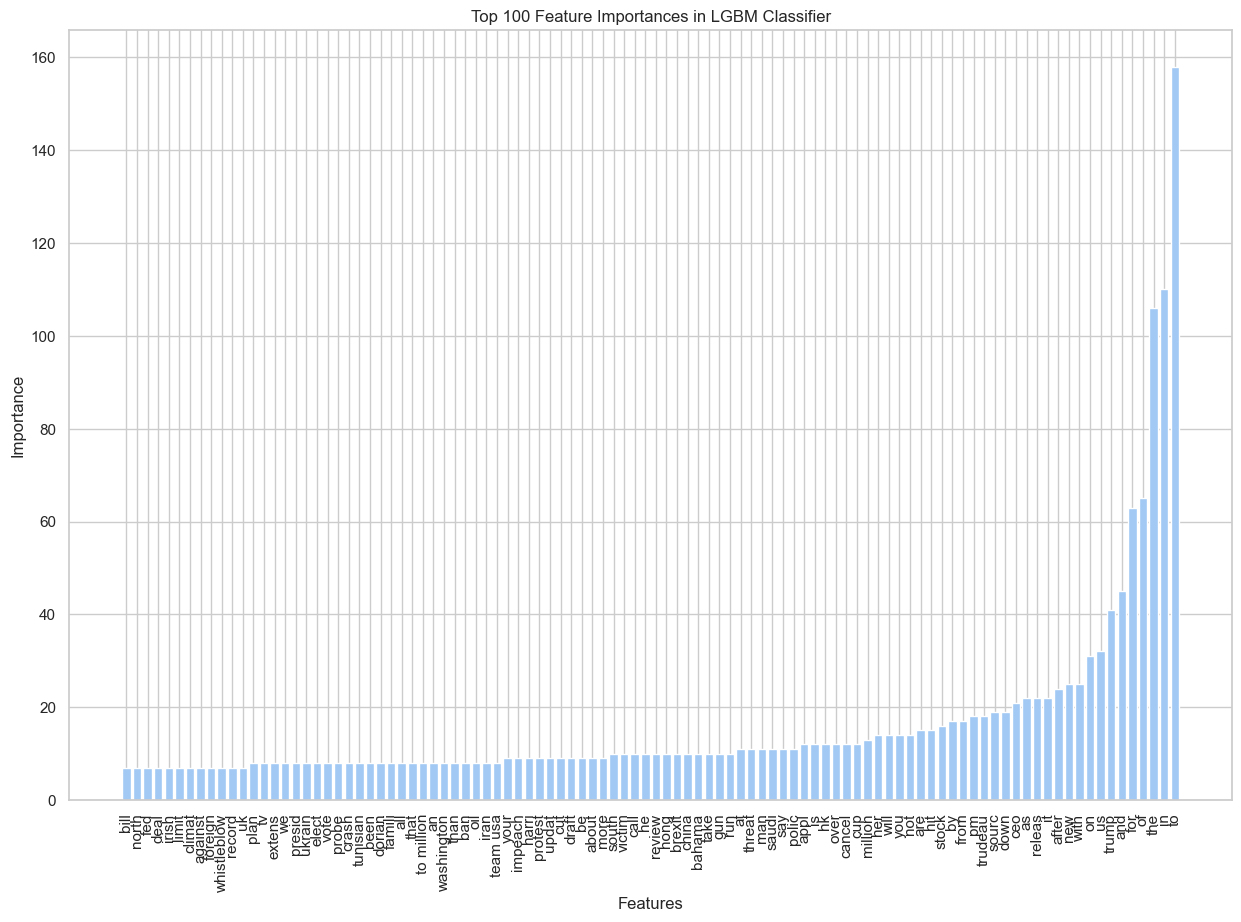

In [49]:
feature_importances_lgb = LGB.feature_importances_

N = 100

# Sorting the feature importances and getting the indices of top 100
sorted_indices_lgb = np.argsort(feature_importances_lgb)[-N:]

# Extracting the top 100 feature names and their corresponding importances
top_features_lgb = np.array(feature_names)[sorted_indices_lgb]
top_importances_lgb = feature_importances_lgb[sorted_indices_lgb]

# Plotting the top 100 features
plt.figure(figsize=(15, 10))  # Adjusted for better readability
plt.bar(range(100), top_importances_lgb, align='center')
plt.xticks(range(100), top_features_lgb, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 100 Feature Importances in LGBM Classifier')
plt.show()


## Model Performance Comparision using Test Data

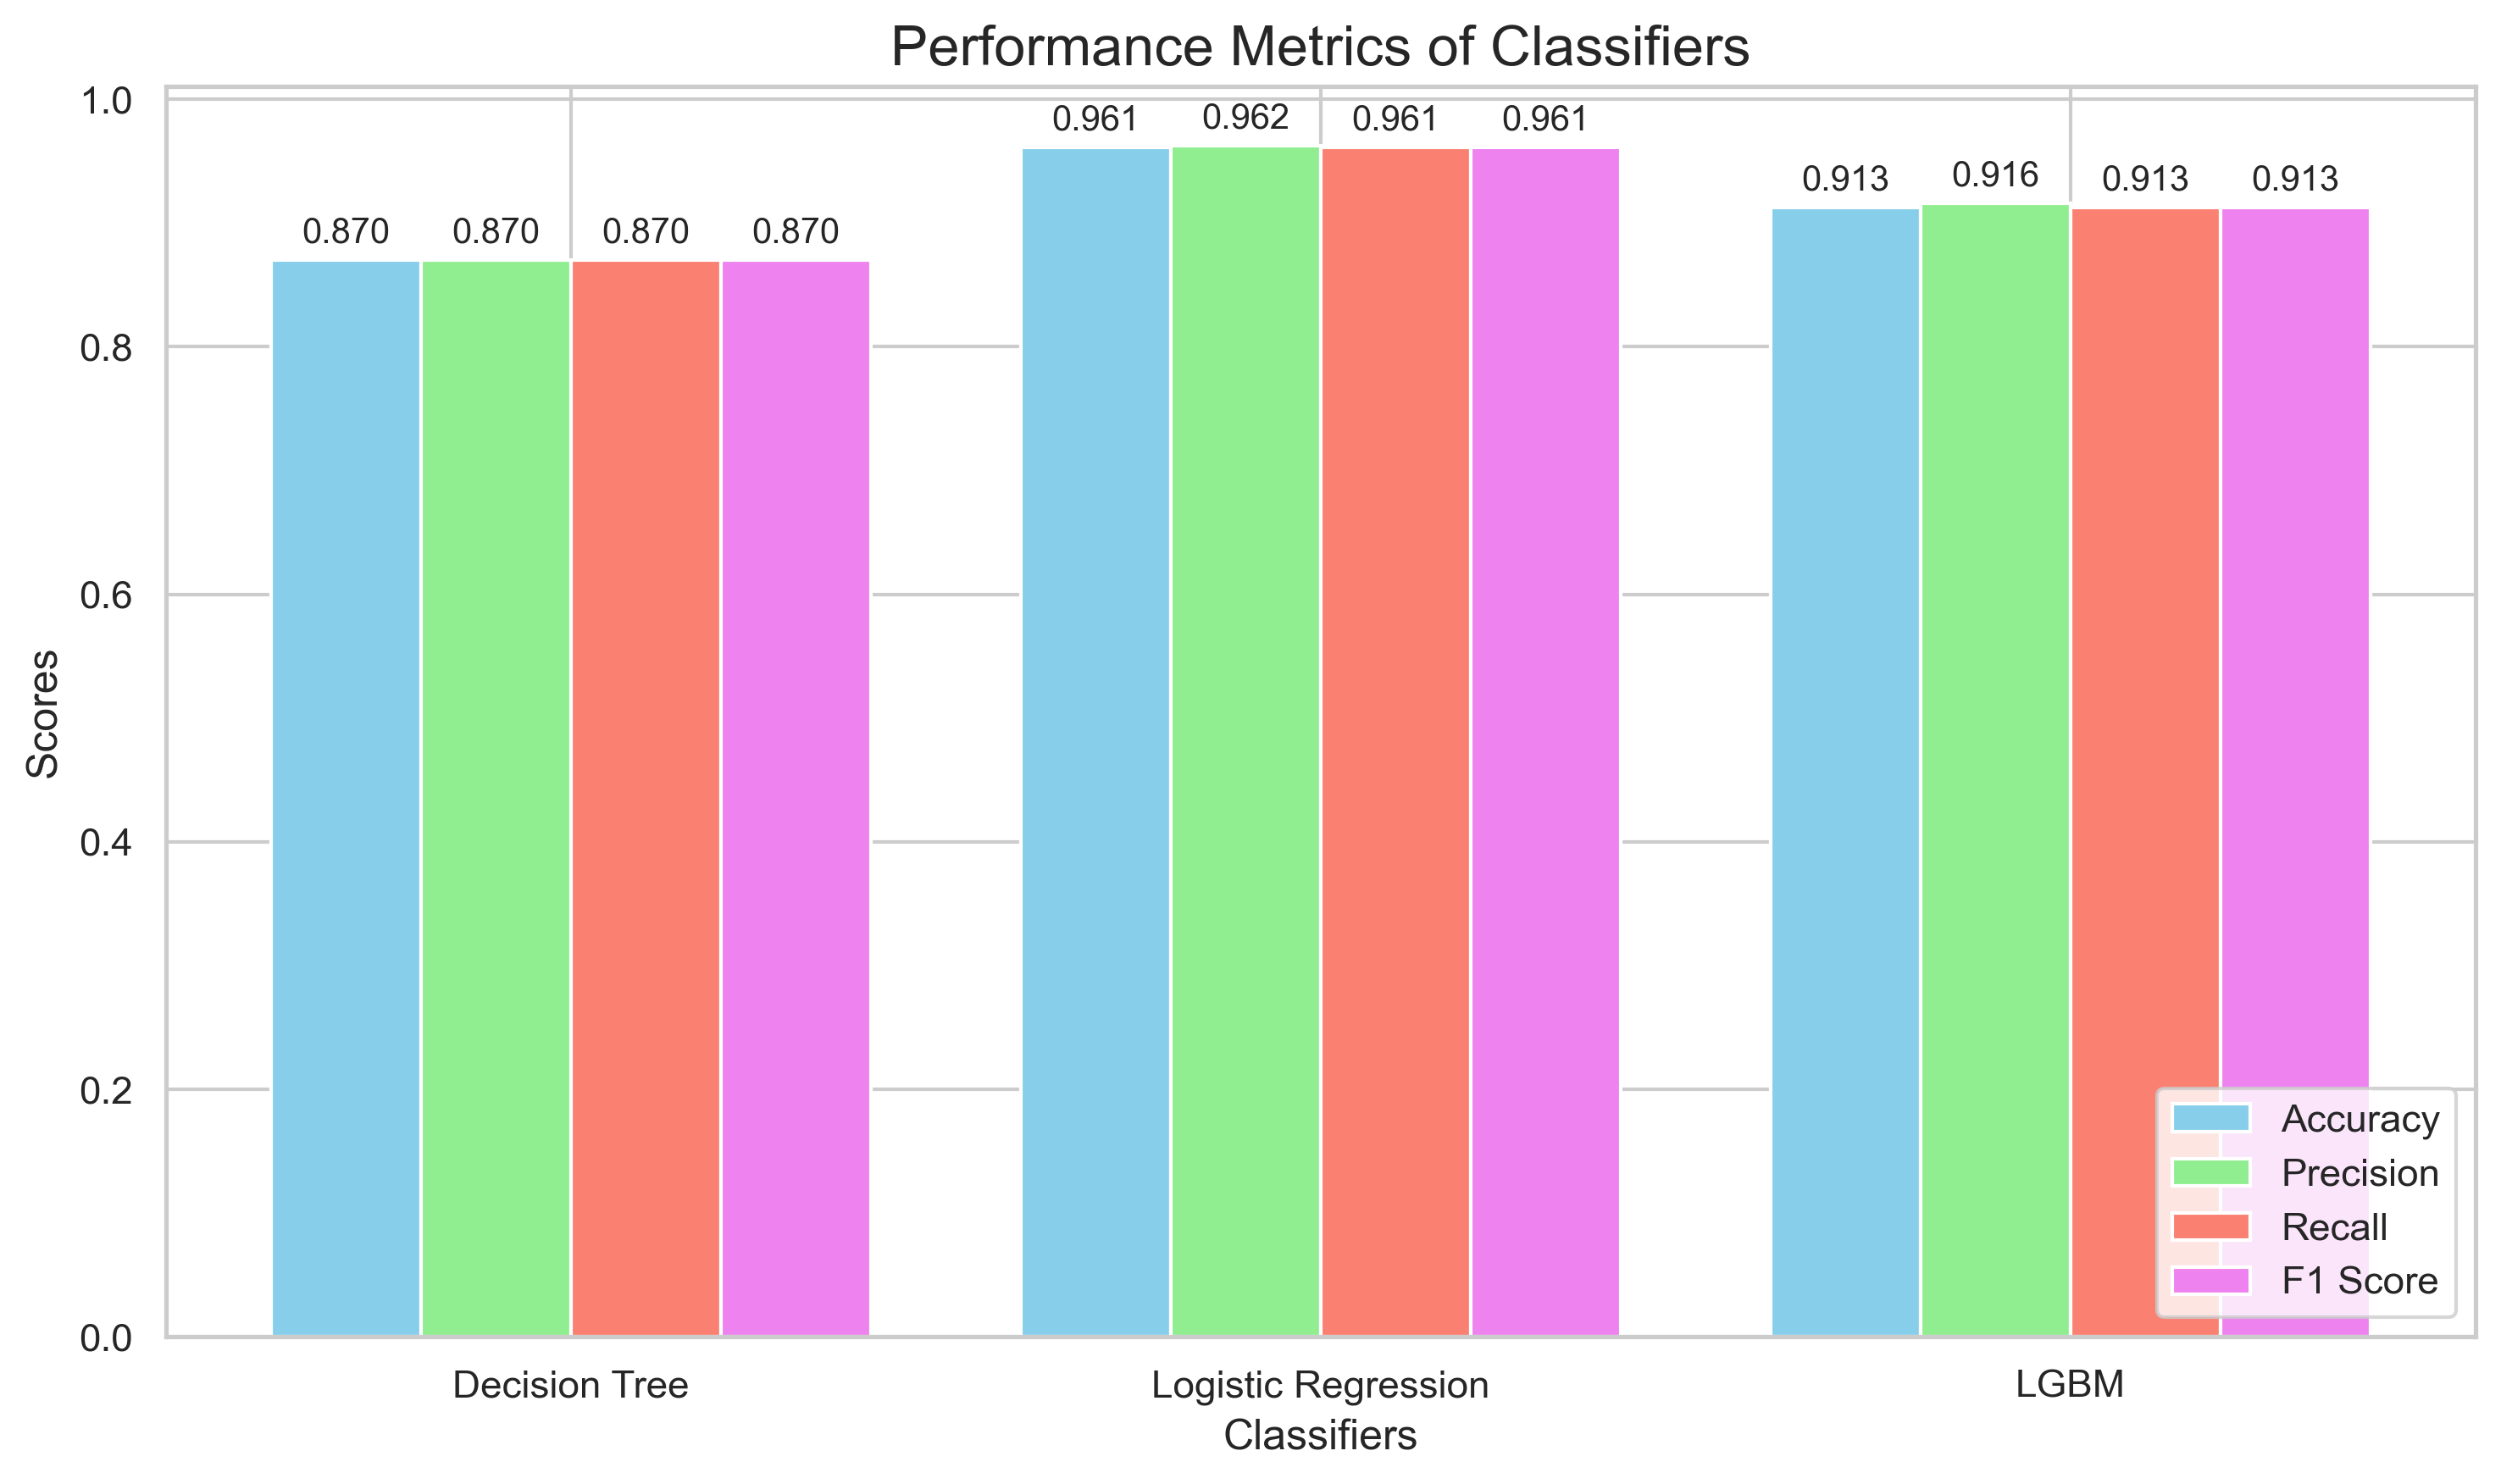

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Calculate metrics for Decision Tree Classifier
accuracy_DT, precision_DT, recall_DT, f1_DT = calculate_metrics(y_test, pred_DT)

# Calculate metrics for Logistic Regression Classifier
accuracy_LG, precision_LG, recall_LG, f1_LG = calculate_metrics(y_test, pred_LG)

# Calculate metrics for LGBM Classifier
accuracy_LGB, precision_LGB, recall_LGB, f1_LGB = calculate_metrics(y_test, pred_LGB)

# Labels for the classifiers
classifiers = ['Decision Tree', 'Logistic Regression', 'LGBM']

# Metrics for each classifier
accuracy = [accuracy_DT, accuracy_LG, accuracy_LGB]
precision = [precision_DT, precision_LG, precision_LGB]
recall = [recall_DT, recall_LG, recall_LGB]
f1 = [f1_DT, f1_LG, f1_LGB]

# Classifiers
classifiers = ['Decision Tree', 'Logistic Regression', 'LGBM']

# X-axis locations for the groups
ind = np.arange(len(classifiers))

# Bar width
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  # Slightly larger plot
bars1 = ax.bar(ind - 1.5*width, accuracy, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(ind - 0.5*width, precision, width, label='Precision', color='lightgreen')
bars3 = ax.bar(ind + 0.5*width, recall, width, label='Recall', color='salmon')
bars4 = ax.bar(ind + 1.5*width, f1, width, label='F1 Score', color='violet')


# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Classifiers', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Performance Metrics of Classifiers', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(classifiers)
ax.legend()

# Function to add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Add labels to the bars
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
ax.legend(loc='lower right') 
plt.show()


# Training and Testing Accuracy Check 

In [51]:
from sklearn.metrics import accuracy_score

# Decision Tree Classifier
train_accuracy_DT = accuracy_score(y_train, DT.predict(X_train))
test_accuracy_DT = accuracy_score(y_test, pred_DT)
print("Decision Tree - Training accuracy:", train_accuracy_DT, "Test accuracy:", test_accuracy_DT)

# Logistic Regression Classifier
train_accuracy_LG = accuracy_score(y_train, LG.predict(X_train))
test_accuracy_LG = accuracy_score(y_test, pred_LG)
print("Logistic Regression - Training accuracy:", train_accuracy_LG, "Test accuracy:", test_accuracy_LG)

# LGBM Classifier
train_accuracy_LGB = accuracy_score(y_train, LGB.predict(X_train))
test_accuracy_LGB = accuracy_score(y_test, pred_LGB)
print("LGBM - Training accuracy:", train_accuracy_LGB, "Test accuracy:", test_accuracy_LGB)

# Function to check overfitting
def check_overfitting(train_accuracy, test_accuracy):
    if train_accuracy > test_accuracy:
        if (train_accuracy - test_accuracy) > 0.1:  # This threshold can be adjusted
            return "The model may be overfitting."
        else:
            return "The model is likely not overfitting."
    else:
        return "The model is likely not overfitting."

# Evaluate overfitting
print("Decision Tree:", check_overfitting(train_accuracy_DT, test_accuracy_DT))
print("Logistic Regression:", check_overfitting(train_accuracy_LG, test_accuracy_LG))
print("LGBM:", check_overfitting(train_accuracy_LGB, test_accuracy_LGB))


Decision Tree - Training accuracy: 0.9904530138524897 Test accuracy: 0.8701347305389222
Logistic Regression - Training accuracy: 0.9865219019093973 Test accuracy: 0.9610778443113772
LGBM - Training accuracy: 0.9674279296143766 Test accuracy: 0.9127994011976048
Decision Tree: The model may be overfitting.
Logistic Regression: The model is likely not overfitting.
LGBM: The model is likely not overfitting.


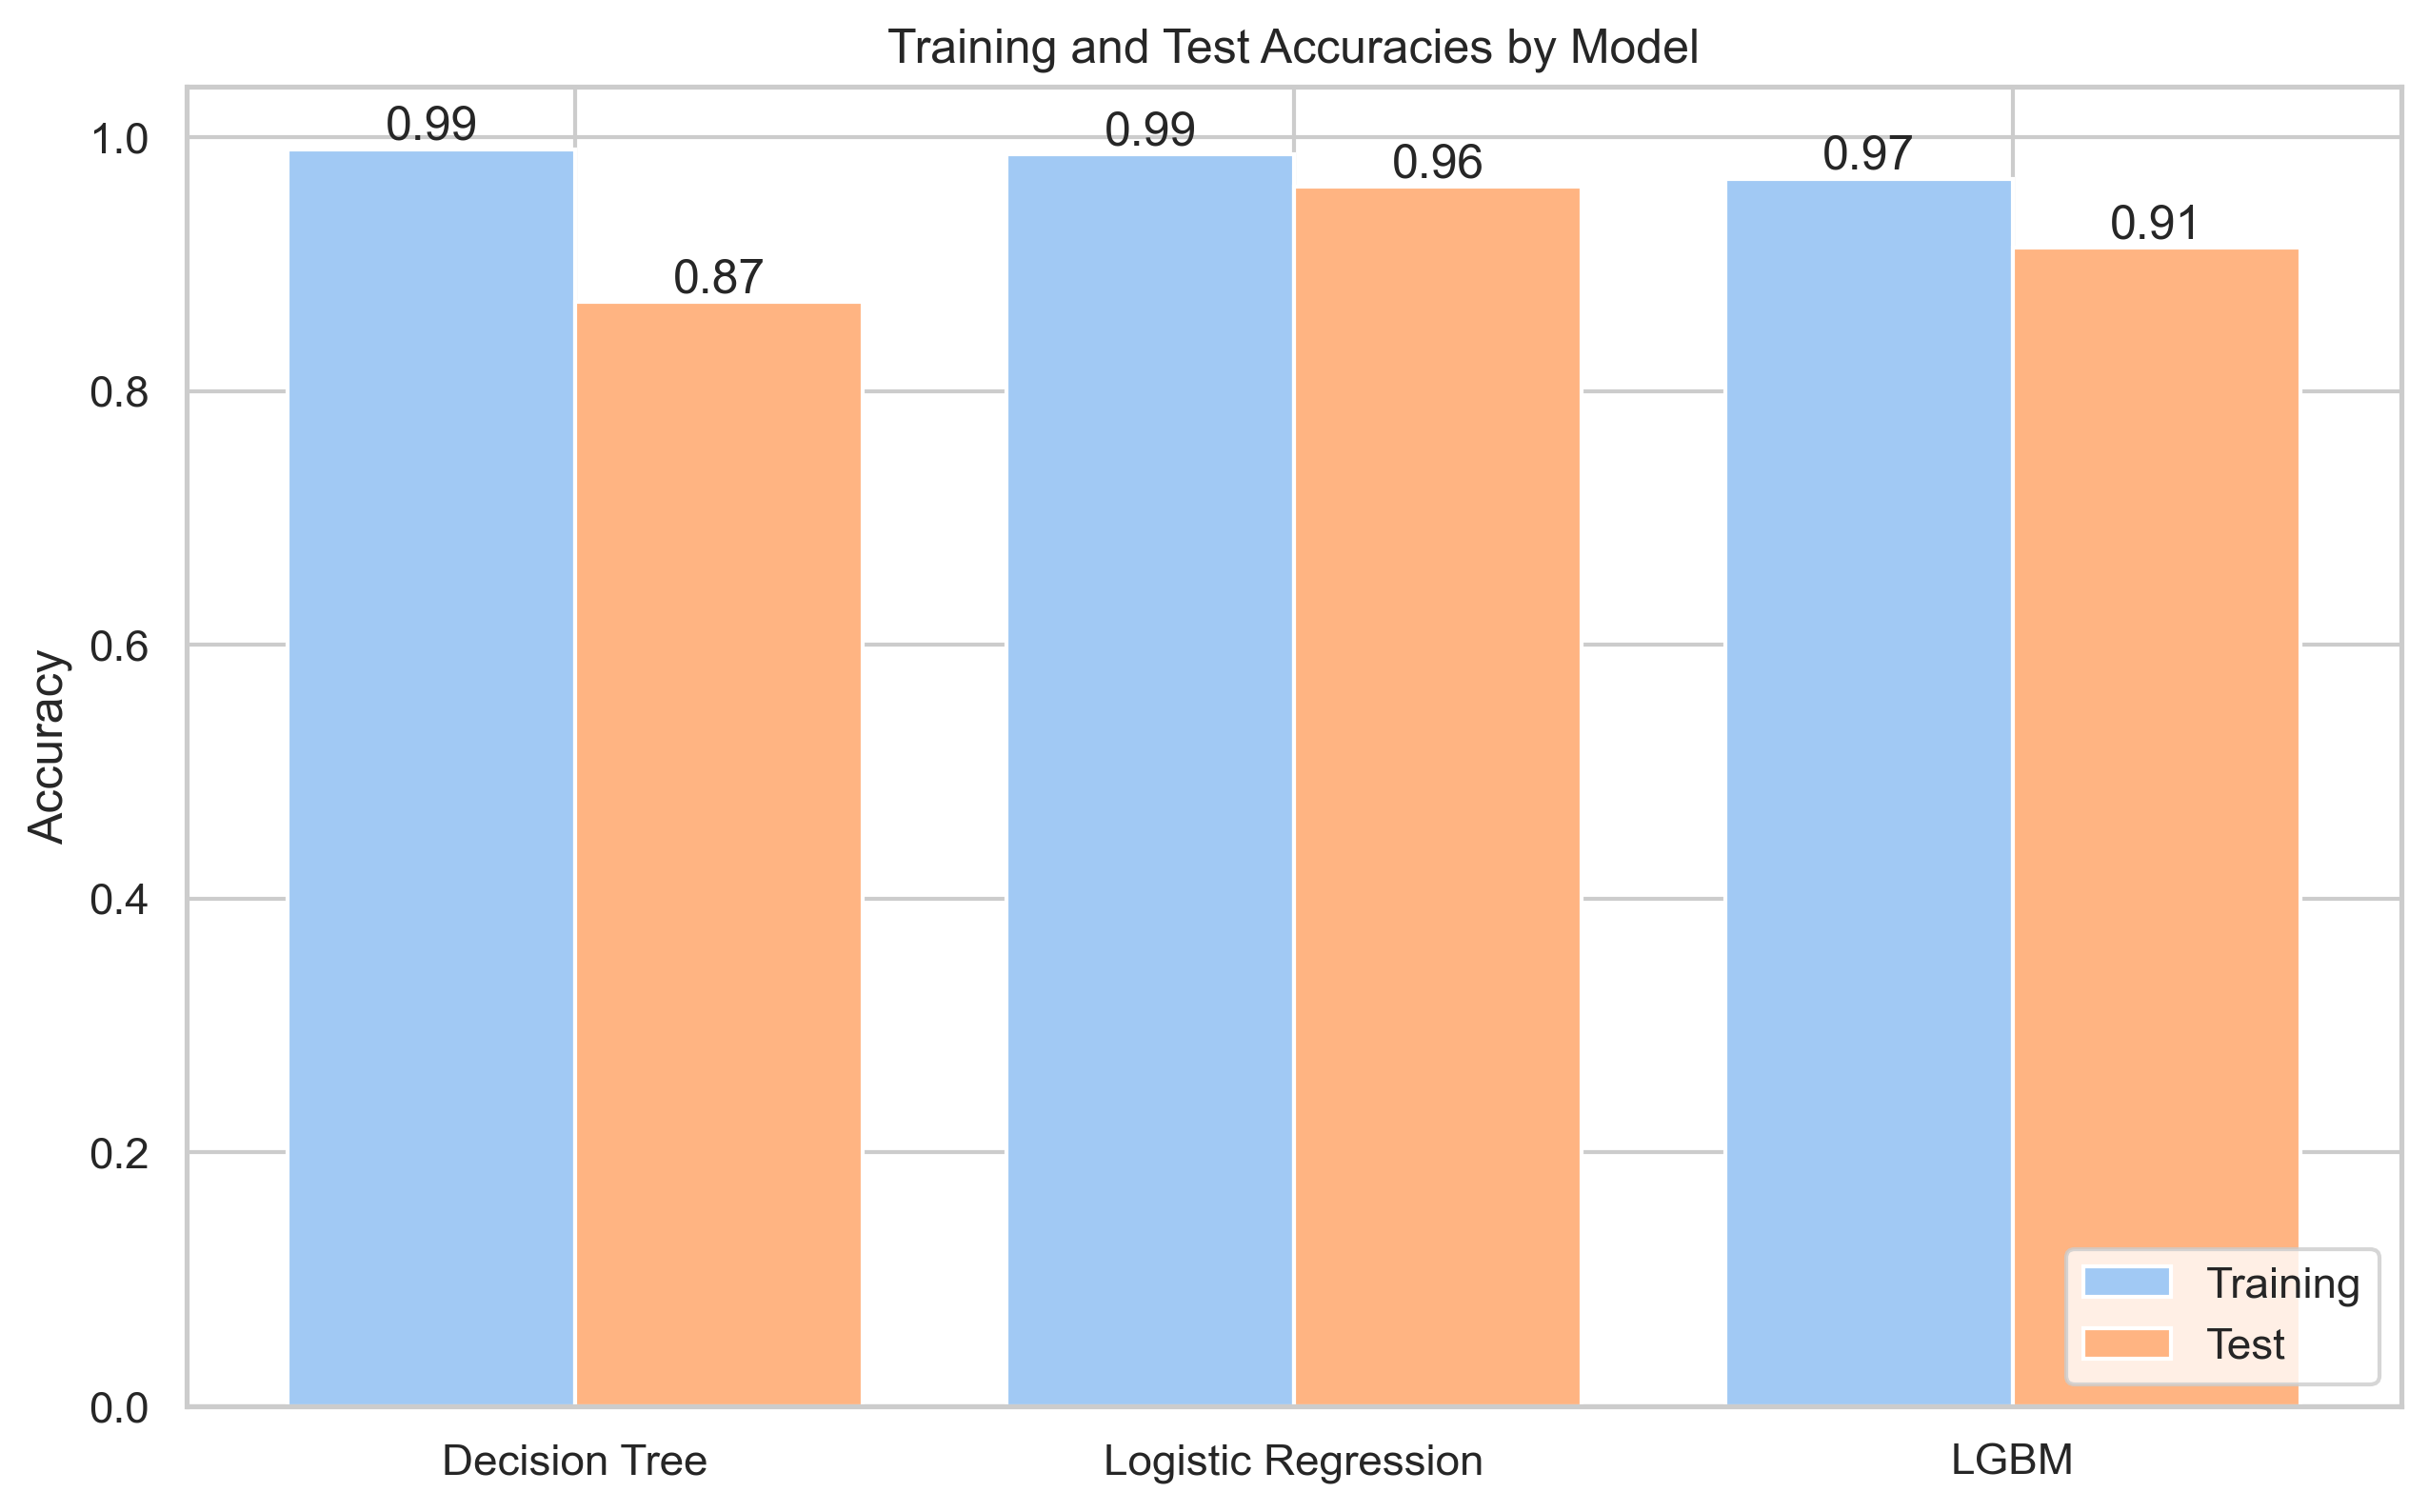

In [52]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Decision Tree', 'Logistic Regression', 'LGBM']
training_accuracies = [train_accuracy_DT, train_accuracy_LG, train_accuracy_LGB]
test_accuracies = [test_accuracy_DT, test_accuracy_LG, test_accuracy_LGB]

x = range(len(models))  # the label locations

# Create the plot
plt.figure(figsize=(10, 6), dpi=300)
bar1 = plt.bar([i - 0.2 for i in x], training_accuracies, width=0.4, label='Training', align='center')
bar2 = plt.bar([i + 0.2 for i in x], test_accuracies, width=0.4, label='Test', align='center')

# Add some text for labels, title, and custom x-axis tick labels
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies by Model')
plt.xticks(x, models)
plt.legend(loc='lower right')  # Position legend in the lower right corner

# Add accuracy values on top of the bars
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

# Show the plot
plt.show()



## Visual Comparison Between the t-statistics and p-values for Each Model Pair

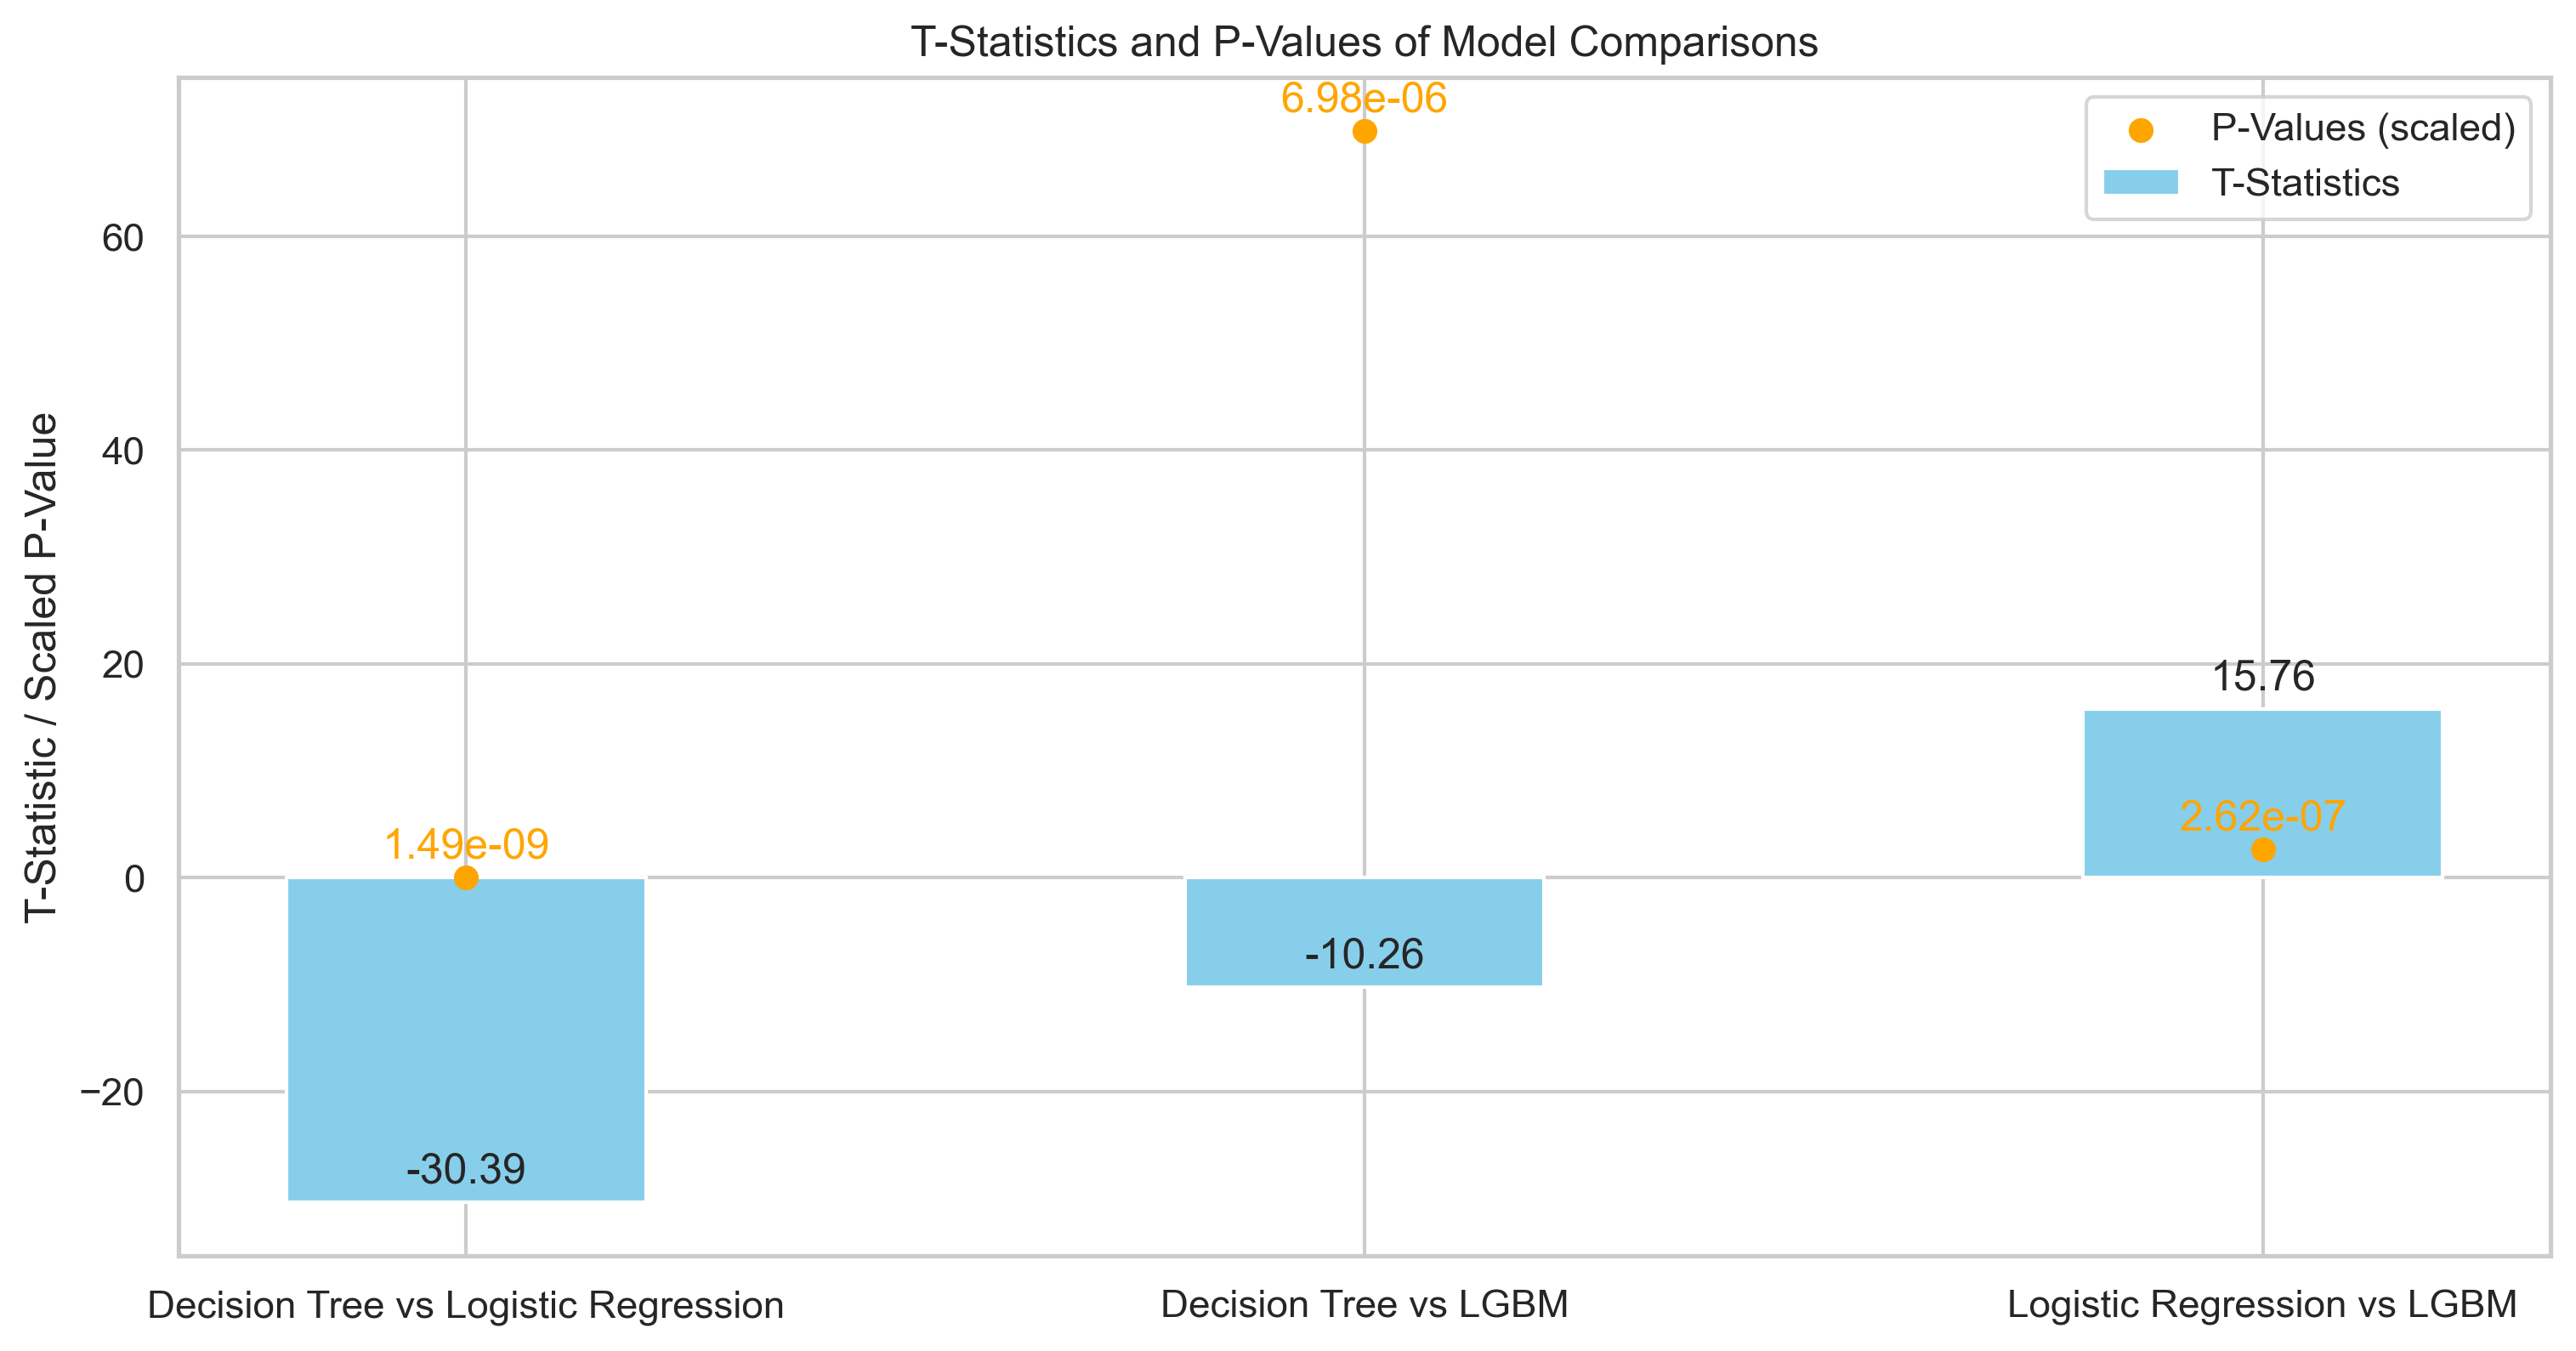

In [53]:
import matplotlib.pyplot as plt
import numpy as np


# Perform t-tests
t_stat_LG_DT, p_value_LG_DT = stats.ttest_ind(scores_DT, scores_LG)
t_stat_DT_LGB, p_value_DT_LGB = stats.ttest_ind(scores_DT, scores_LGB)
t_stat_LG_LGB, p_value_LG_LGB = stats.ttest_ind(scores_LG, scores_LGB)



# Data for plotting
t_stats = [t_stat_LG_DT, t_stat_DT_LGB, t_stat_LG_LGB]
p_values = [p_value_LG_DT, p_value_DT_LGB, p_value_LG_LGB]

# Data for plotting
comparisons = ['Decision Tree vs Logistic Regression', 'Decision Tree vs LGBM', 'Logistic Regression vs LGBM']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Bar plot for t-statistics
bars = ax.bar(comparisons, t_stats, width=0.4, label='T-Statistics', color='skyblue')

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Scatter plot for p-values
# Note: The p-values are scaled to be visible on the same plot as t-statistics
scaled_p_values = [p * 1e7 for p in p_values]  # Scale factor can be adjusted
ax.scatter(comparisons, scaled_p_values, color='orange', label='P-Values (scaled)')

# Add labels for p-values
for i, p_val in enumerate(scaled_p_values):
    ax.text(comparisons[i], p_val + 1, f'{p_values[i]:.2e}', ha='center', va='bottom', color='orange')

ax.set_ylabel('T-Statistic / Scaled P-Value')
ax.set_title('T-Statistics and P-Values of Model Comparisons')
ax.legend()

plt.show()

# Confusion Matrix 

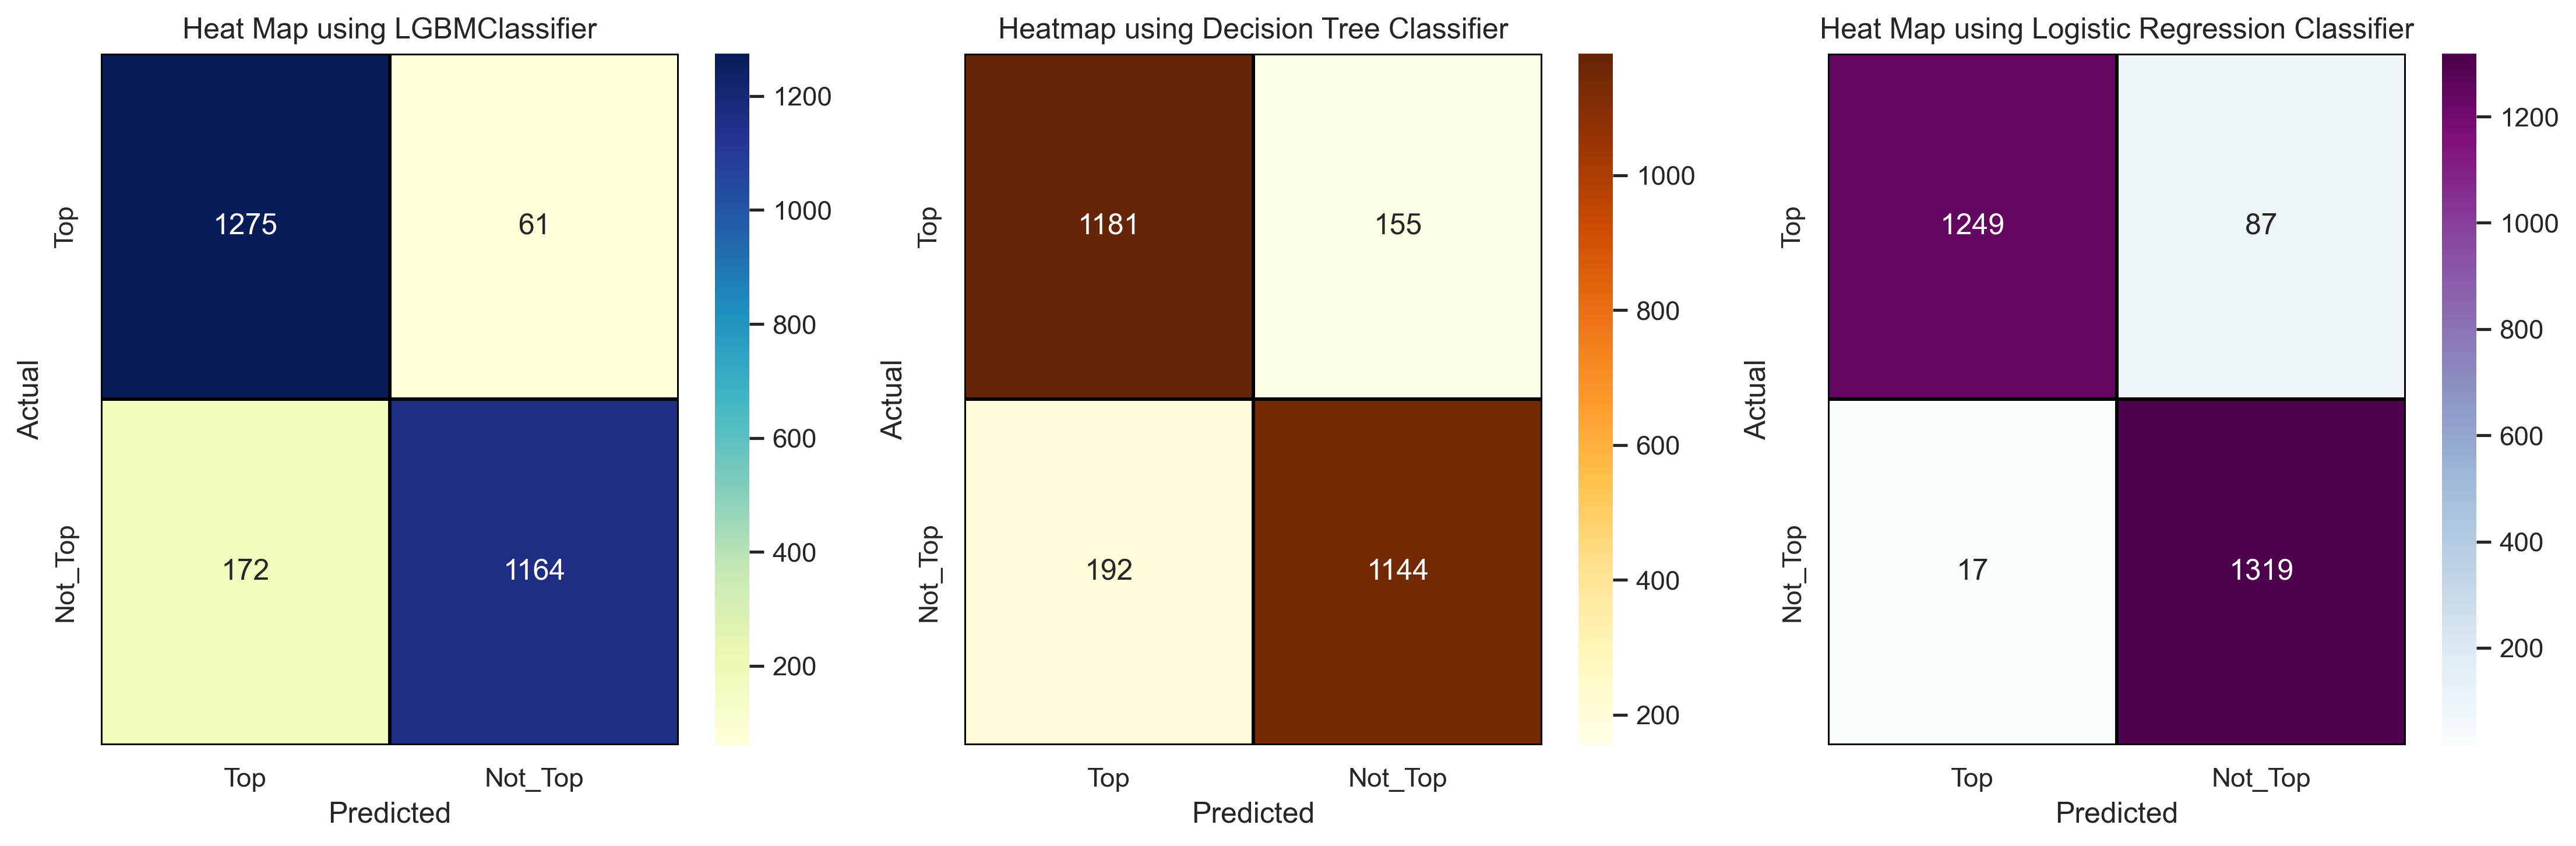

In [54]:
LGB_predict = LGB.predict(X_test)
DT_predict = DT.predict(X_test)
LG_predict = LG.predict(X_test)

# Create a 1x3 subplot grid
plt.figure(figsize=(15, 5), dpi=300)

# Plot the first heatmap
plt.subplot(1, 3, 1)
cm1 = confusion_matrix(y_test, LGB_predict)
sns.heatmap(cm1, cmap="YlGnBu", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Top', 'Not_Top'], yticklabels=['Top', 'Not_Top'])
plt.title('Heat Map using LGBMClassifier')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot the second heatmap
plt.subplot(1, 3, 2)
cm2 = confusion_matrix(y_test, DT_predict)
sns.heatmap(cm2, cmap="YlOrBr", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Top', 'Not_Top'], yticklabels=['Top', 'Not_Top'])
plt.title('Heatmap using Decision Tree Classifier')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot the third heatmap
plt.subplot(1, 3, 3)
cm3 = confusion_matrix(y_test, LG_predict)
sns.heatmap(cm3, cmap="BuPu", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Top', 'Not_Top'], yticklabels=['Top', 'Not_Top'])
plt.title('Heat Map using Logistic Regression Classifier')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Adjust layout
plt.tight_layout()
plt.show()


# Text Regression Model
X : title
y : Popularity_score
We are going to use the vectorized title to predict the popularity score. I have experimented with logistic regression and random forest regressor, but Light Gradient Boosting performed well in our case.

Filling missing values with 1.
Train and Test split
LGBMRegressor
learning_rate=0.01,
max_depth=20,
num_leaves=50,
n_estimators=150
Cross Validation
Training and Testing

In [55]:
list_labels = df_cleaned["Popularity_Score"].fillna(1)

X_train, X_test, y_train, y_test = train_test_split(train_tfidf,
                                                    list_labels,
                                                    test_size=0.2,
                                                    random_state=40)


## LGBMRegressor

In [56]:
model2_LGB = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

### Cross Validation using LGBMRegressor

In [57]:
scores_LGB = cross_val_score(
                 model2_LGB, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores_LGB)

Cross Validation RMSE Scores :  [2.66575313 2.63721637 2.67901512 2.66275585 2.5989654 ]


# DecisionTreeRegressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
model2_DTR = DecisionTreeRegressor()

### Cross Validation using DecisionTreeRegressor

In [59]:
scores_DTR = cross_val_score(
                 model2_DTR, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores_DTR)

Cross Validation RMSE Scores :  [3.63442089 3.61286093 3.70728497 3.38512458 3.62211561]


# Linear Regression 

In [60]:
from sklearn.linear_model import LinearRegression
model3_LR = LinearRegression()

### Cross Validation using Linear Regression

In [61]:
scores_LR = cross_val_score(
                 model3_LR, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores_LR)

Cross Validation RMSE Scores :  [2.94197329 2.91669279 3.0718173  2.9065655  2.74587064]


### Fitting the model and Prediction test data 

In [62]:
#LGBM Regressor
model2_LGB.fit(X_train,y_train)
pred1_LGB = model2_LGB.predict(X_test)

#Decision Tree Regressor
model2_DTR.fit(X_train,y_train)
pred1_DTR = model2_DTR.predict(X_test)

#Linear Regression
model3_LR.fit(X_train,y_train)
pred1_LR = model3_LR.predict(X_test)


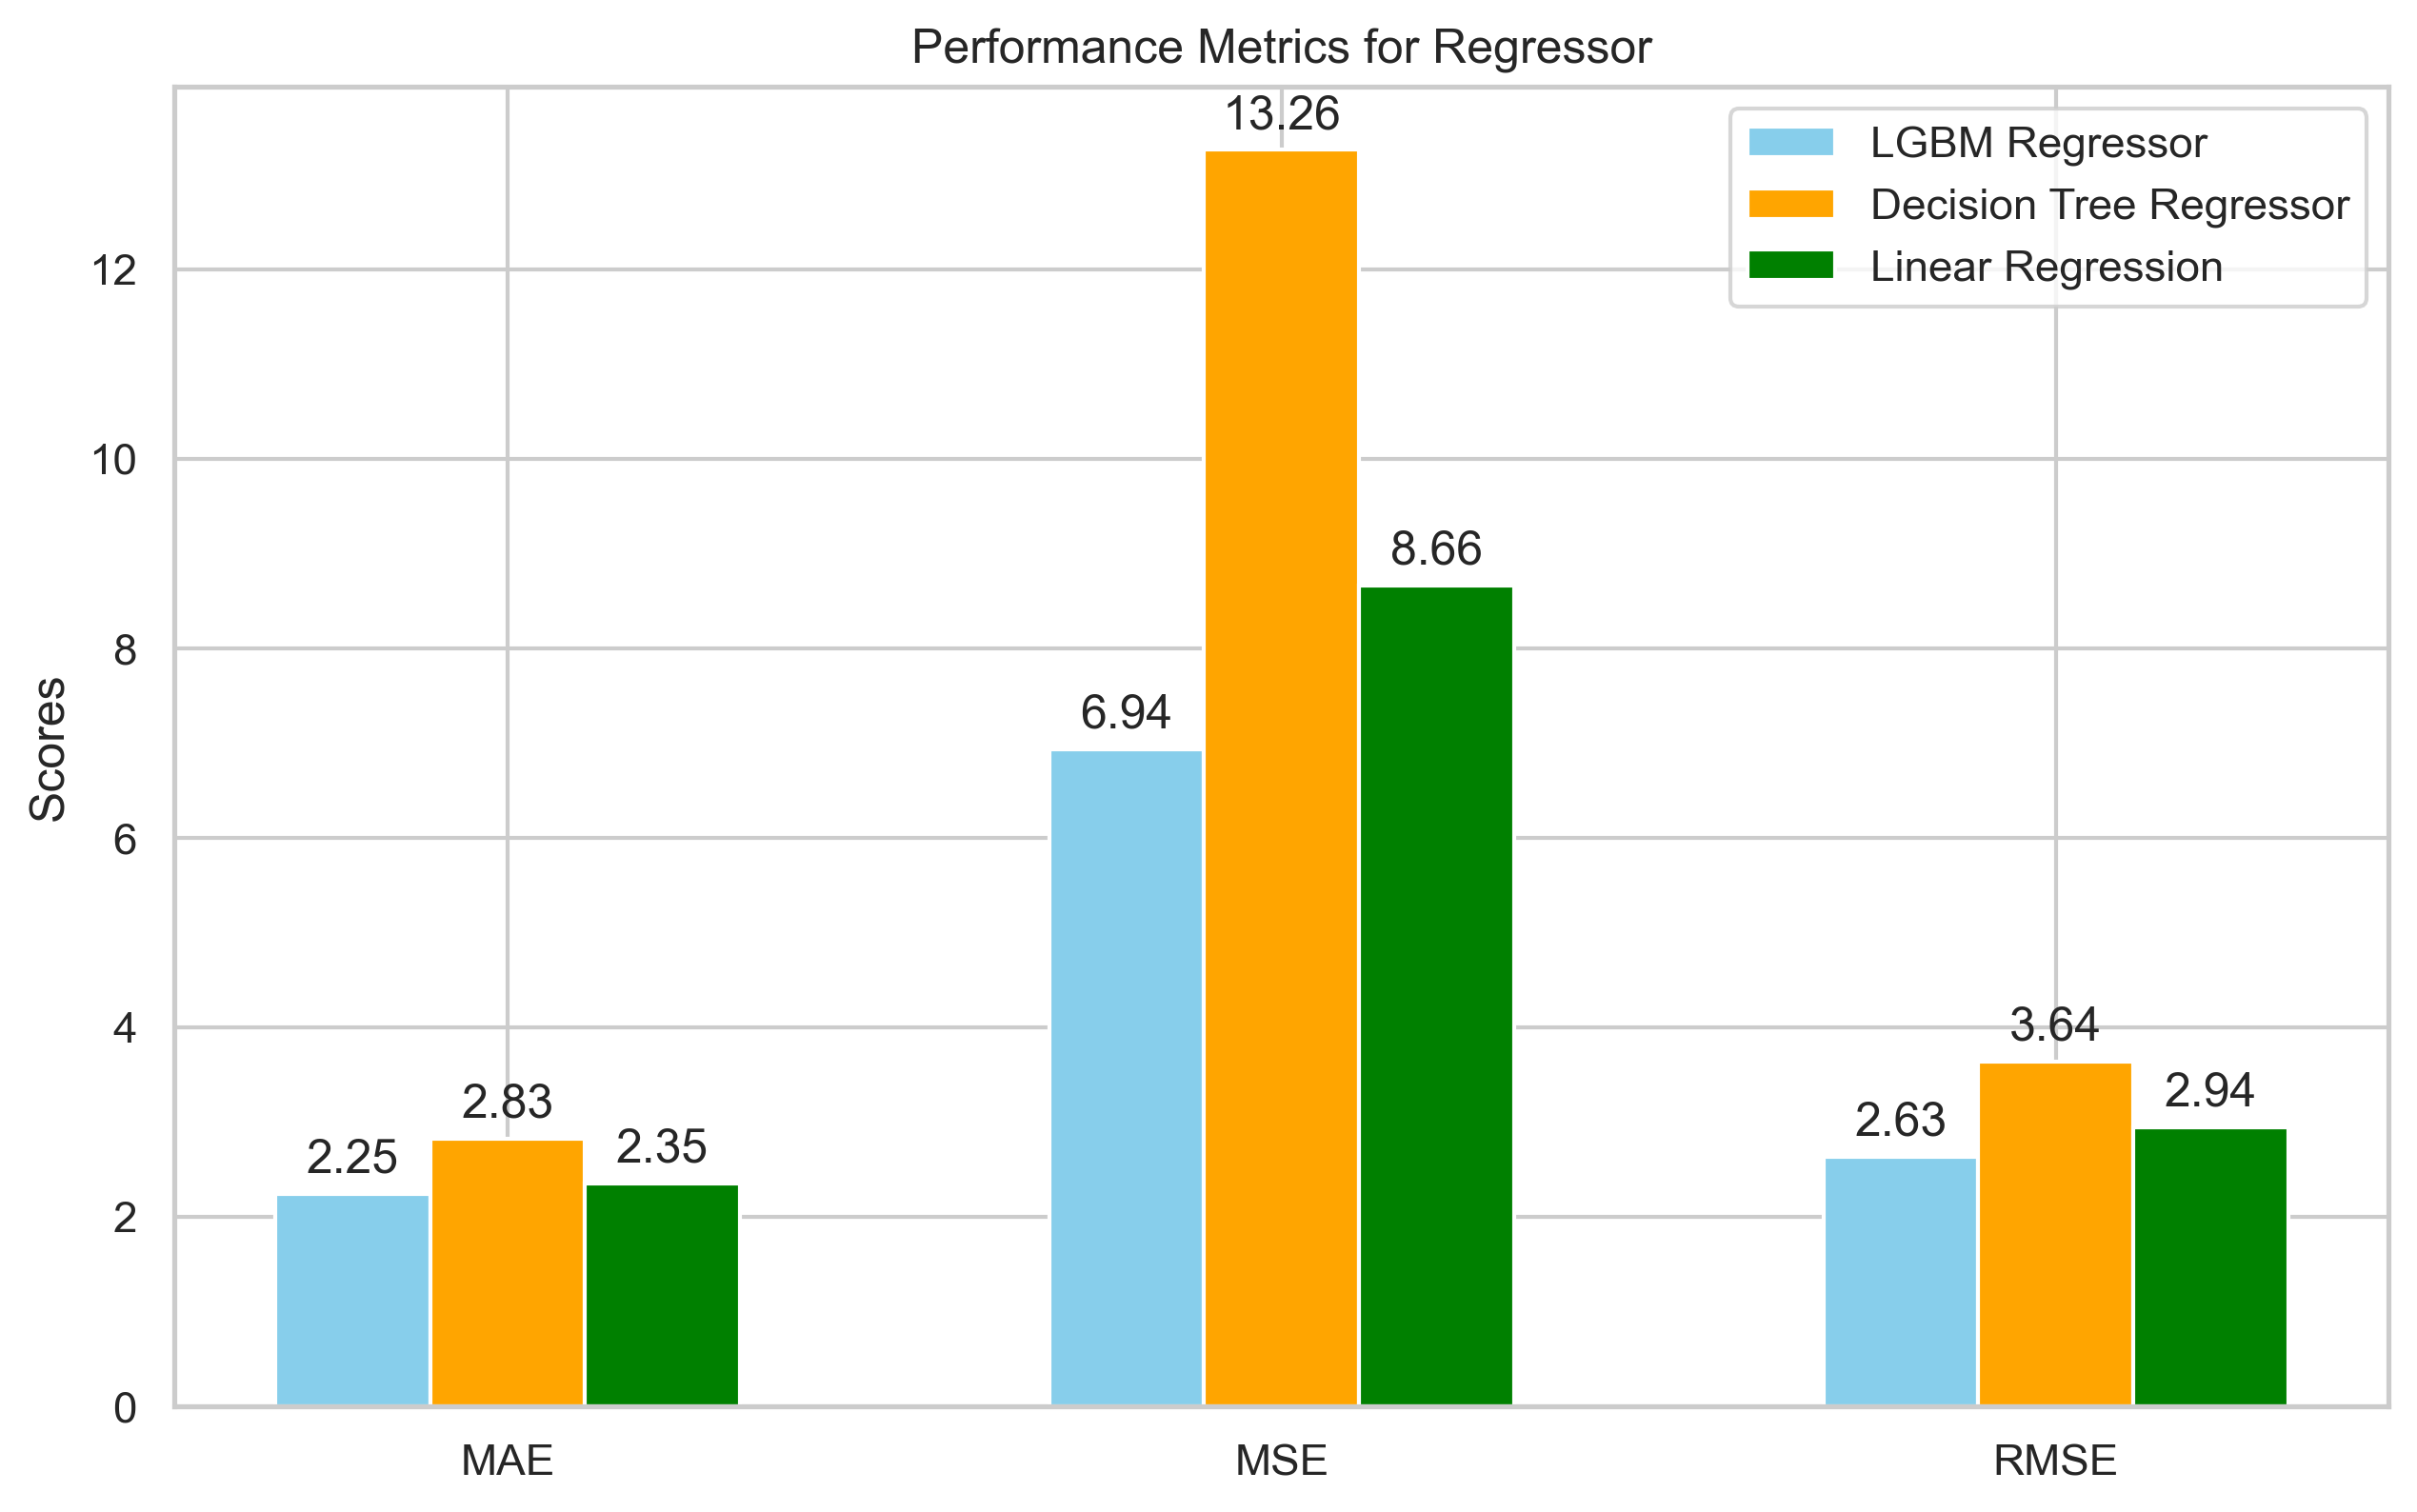

In [63]:
# Calculate the metrics for LGBM Regressor
mae_lgbm = mean_absolute_error(y_test, pred1_LGB)
mse_lgbm = mean_squared_error(y_test, pred1_LGB)
rmse_lgbm = np.sqrt(mse_lgbm)

# Calculate the metrics for Decision Tree Regressor
mae_dtr = mean_absolute_error(y_test, pred1_DTR)
mse_dtr = mean_squared_error(y_test, pred1_DTR)
rmse_dtr = np.sqrt(mse_dtr)

# Calculate the metrics for Linear Regression
mae_lr = mean_absolute_error(y_test, pred1_LR)
mse_lr = mean_squared_error(y_test, pred1_LR)
rmse_lr = np.sqrt(mse_lr)

# Prepare data for plotting
metrics = ['MAE', 'MSE', 'RMSE',]
lgbm_scores = [mae_lgbm, mse_lgbm, rmse_lgbm]
dtr_scores = [mae_dtr, mse_dtr, rmse_dtr]
lr_scores = [mae_lr, mse_lr, rmse_lr]

# Plotting the comparison chart
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

rects1 = ax.bar(x - width, lgbm_scores, width, label='LGBM Regressor', color='skyblue')
rects2 = ax.bar(x, dtr_scores, width, label='Decision Tree Regressor', color='orange')
rects3 = ax.bar(x + width, lr_scores, width, label='Linear Regression', color='green')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Regressor')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add values above bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)
add_values(rects3)

ax.grid(True)
plt.show()




# Title Scoring
title_score function takes the title and output the popularity score and classify top Article. Total Engagement which includes reaction, share, and comments. We can use these functions to create the best possible titles for our blogs.

Function Tasks:

Clean the text
Vectorized the text
Predict top article and popularity score
Print top article, the popularity score, and total engagement.

In [64]:
def title_scoreLGB(title):
    text = clean_title(title)
    text = tfidf_vec.transform([text])
    top_cat = LGB.predict(text)
    pop = model2_LGB.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score :" , round(pop[0],2))
    
    # Here we use np.expm1 which is a special math trick. When our computer made its guess earlier,
    # it used a method that makes big numbers smaller (kind of like squishing them). 
    # np.expm1 does the reverse - it 'unsquishes' this number to get back to the original big number.
    # This gives us a more accurate count of how many people will interact with the article.
    print("Total Engagement :" , int(np.expm1(pop[0])))
    return top_cat,pop

In [65]:
df[df['top_article']==1]['title'].values[10]

"Here's what Hurricane Dorian is expected to do as it crawls toward the US"

In [66]:
title_scoreLGB("Officers injured in knife attack at Paris police headquarters");

Top Article : False
Popularity Score : 3.43
Total Engagement : 29


In [67]:
def title_scoreDT(title):
    text = clean_title(title)
    text = tfidf_vec.transform([text])
    top_cat = DT.predict(text)
    pop = model2_DTR.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score :" , round(pop[0],2))
    print("Total Engagement :" , int(np.expm1(pop[0])))
    return top_cat,pop

In [68]:
title_scoreDT("Officers injured in knife attack at Paris police headquarters");

Top Article : False
Popularity Score : 2.2
Total Engagement : 8


In [89]:
def convert_score_to_engagement(popularity_score):
    return np.exp(popularity_score) - 1
def title_scoreLG(title):
    text = clean_title(title)
    text = tfidf_vec.transform([text])
    top_cat = LGB.predict(text)
    pop = model2_LGB.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score :" , round(pop[0],2))
    
    # Here we use np.expm1 which is a special math trick. When our computer made its guess earlier,
    # it used a method that makes big numbers smaller (kind of like squishing them). 
    # np.expm1 does the reverse - it 'unsquishes' this number to get back to the original big number.
    # This gives us a more accurate count of how many people will interact with the article.
    print("Total Engagement :" , int(np.expm1(pop[0])))
    return top_cat,pop

In [90]:
title_scoreLG("Hedge Fund Loses $1 Billion in One Month on Argentina Bet");

Top Article : False
Popularity Score : 3.28
Total Engagement : 25


In [91]:
title_scoreLG("Jeffrey Epstein‚Äôs New York Hunting Ground: Dance Studios");

Top Article : False
Popularity Score : 3.11
Total Engagement : 21


In [92]:
title_scoreLG("MPs return ahead of key Brexit vote");

Top Article : False
Popularity Score : 3.59
Total Engagement : 35
